<a href="https://colab.research.google.com/github/luisaespinoza/CSCI167-Project/blob/main/CSCI167Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!unzip -q test.zip
!unzip -q valid.zip
!unzip -q valid-mini.zip
!unzip -q train.zip

replace Alakazam/1115f34ff9884a6ab3ceaafa87a0dfd4_jpg.rf.8d4fee20d6a1f27951df8c2db027356a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace Alakazam/1115f34ff9884a6ab3ceaafa87a0dfd4_jpg.rf.10de930d8557662ab95e23156d52881a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Alakazam/5f696c035e35464b80243bb0e34be6df_jpg.rf.784b1ca53be9895e55ace7581567bbd2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace Alakazam/image.jpg0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace Abra/0282b2f3a22745f1a436054ea15a0ae5_jpg.rf.8672478a3b97f7c0c5b6737c3fd2d3d8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [12]:
!pip install datasets torchvision tqdm pandas matplotlib

In [32]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [16]:
CATEGORIES = ['Porygon', 'Goldeen', 'Hitmonlee', 'Hitmonchan', 'Gloom', 'Aerodactyl', 'Mankey', 'Seadra', 'Gengar', 'Venonat', 'Articuno', 'Seaking', 'Dugtrio',
               'Machop', 'Jynx', 'Oddish', 'Dodrio', 'Dragonair', 'Weedle', 'Golduck', 'Flareon', 'Krabby', 'Parasect', 'Ninetales', 'Nidoqueen', 'Kabutops', 'Drowzee',
               'Caterpie', 'Jigglypuff', 'Machamp', 'Clefairy', 'Kangaskhan', 'Dragonite', 'Weepinbell', 'Fearow', 'Bellsprout', 'Grimer', 'Nidorina', 'Staryu', 'Horsea',
              'Electabuzz', 'Dratini', 'Machoke', 'Magnemite', 'Squirtle', 'Gyarados', 'Pidgeot', 'Bulbasaur', 'Nidoking', 'Golem', 'Dewgong', 'Moltres', 'Zapdos', 'Poliwrath',
              'Vulpix', 'Beedrill', 'Charmander', 'Abra', 'Zubat', 'Golbat', 'Wigglytuff', 'Charizard', 'Slowpoke', 'Poliwag', 'Tentacruel', 'Rhyhorn', 'Onix', 'Butterfree',
              'Exeggcute', 'Sandslash', 'Pinsir', 'Rattata', 'Growlithe', 'Haunter', 'Pidgey', 'Ditto', 'Farfetchd', 'Pikachu', 'Raticate', 'Wartortle', 'Vaporeon', 'Cloyster',
              'Hypno', 'Arbok', 'Metapod', 'Tangela', 'Kingler', 'Exeggutor', 'Kadabra', 'Seel', 'Voltorb', 'Chansey', 'Venomoth', 'Ponyta', 'Vileplume', 'Koffing', 'Blastoise',
              'Tentacool', 'Lickitung', 'Paras', 'Clefable', 'Cubone', 'Marowak', 'Nidorino', 'Jolteon', 'Muk', 'Magikarp', 'Slowbro', 'Tauros', 'Kabuto', 'Spearow', 'Sandshrew',
              'Eevee', 'Kakuna', 'Omastar', 'Ekans', 'Geodude', 'Magmar', 'Snorlax', 'Meowth', 'Pidgeotto', 'Venusaur', 'Persian', 'Rhydon', 'Starmie', 'Charmeleon', 'Lapras',
              'Alakazam', 'Graveler', 'Psyduck', 'Rapidash', 'Doduo', 'Magneton', 'Arcanine', 'Electrode', 'Omanyte', 'Poliwhirl', 'Mew', 'Alolan Sandslash', 'Mewtwo', 'Weezing',
              'Gastly', 'Victreebel', 'Ivysaur', 'MrMime', 'Shellder', 'Scyther', 'Diglett', 'Primeape', 'Raichu']

In [29]:
image_size = 64

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Image transformation pipelines defined.")

Image transformation pipelines defined.


In [33]:
dataset_key = 'pokemon'

# 1. Load datasets using torchvision.datasets.ImageFolder
train_dataset = torchvision.datasets.ImageFolder(root="train", transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root="valid", transform=val_test_transform)
test_dataset = torchvision.datasets.ImageFolder(root="test", transform=val_test_transform)

# Create a dictionary idx_to_class that maps integer labels to class names
class_names = train_dataset.classes
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Create DataLoader objects
pin_memory = True if device.type == "cuda" else False

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=val_test_batch_size, shuffle=False, num_workers=4, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=val_test_batch_size, shuffle=False, num_workers=4, pin_memory=pin_memory)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"First 5 classes: {list(idx_to_class.values())[:5]}")


Number of training samples: 4869
Number of validation samples: 1390
Number of test samples: 732
Number of classes: 110
First 5 classes: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [41]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global Average Pooling to get 512 features
        out = F.avg_pool2d(out, out.size()[2:]) # Pool over remaining height and width
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        # Correct input size for the first linear layer based on 64x64 input images
        # After 3 MaxPool2d layers (stride 2 each), 64 / 2^3 = 64 / 8 = 8.
        # So, feature map size is 256 * 8 * 8
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        # Correct input size for the first linear layer based on 64x64 input images
        # After 4 MaxPool2d layers (stride 2 each), 64 / 2^4 = 64 / 16 = 4.
        # So, feature map size is 512 * 4 * 4
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ==================== HYPERPARAMETER CONFIGS (easy to modify) ====================
hyperparam_configs = [
    {
        "name": "SGD_StepDecay",
        "optimizer": "SGD",
        "lr": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "scheduler_type": "Step",      # Step, Cosine, Reduce, or None
        "epochs": 200,
    },
    {
        "name": "SGD_Cosine",
        "optimizer": "SGD",
        "lr": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "scheduler_type": "Cosine",
        "epochs": 200,
    },
    {
        "name": "Adam_NoReg",
        "optimizer": "Adam",
        "lr": 0.001,
        "weight_decay": 0.0,
        "scheduler_type": None,
        "epochs": 100,
    },
    {
        "name": "Adam_WD",
        "optimizer": "Adam",
        "lr": 0.0005,
        "weight_decay": 1e-4,
        "scheduler_type": "Reduce",
        "epochs": 150,
    },
]

models_to_test = ["SimpleCNN", "VGG11", "ResNet18"]   # change/order as you like

train_batch_size = 128
val_test_batch_size = 256


# ==================== TRAINING FUNCTION ====================
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, epochs, scheduler=None, scheduler_type=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is defined within function
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_val_acc = 0.0
    best_path = "best_model.pth"

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            images, labels = batch # Unpack tuple
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch # Unpack tuple
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Scheduler step
        if scheduler is not None:
            if scheduler_type == "Reduce":
                scheduler.step(val_loss)
            else:
                scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_path)

    # Test on best model
    model.load_state_dict(torch.load(best_path))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch # Unpack tuple
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"FINAL TEST ACCURACY: {test_acc:.2f}%\n")

    # Plot learning curves
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss Curves")

    plt.subplot(1,2,2)
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title(f"{dataset_key} - {model_name} - {hp['name']}")
    plt.show()

    return history, test_acc


----- Training SimpleCNN -----

--- Model: SimpleCNN, Config: SGD_StepDecay ---


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 1/200 [00:07<26:29,  7.99s/it]

Epoch   1/200 | Train Loss: 4.7353 | Val Loss: 5.2128 | Val Acc: 0.00%


  1%|          | 2/200 [00:16<27:23,  8.30s/it]

Epoch   2/200 | Train Loss: 4.6562 | Val Loss: 4.7668 | Val Acc: 0.00%


  2%|▏         | 3/200 [00:23<26:01,  7.93s/it]

Epoch   3/200 | Train Loss: 4.5988 | Val Loss: 4.8585 | Val Acc: 2.37%


  2%|▏         | 4/200 [00:32<26:45,  8.19s/it]

Epoch   4/200 | Train Loss: 4.6944 | Val Loss: 4.7372 | Val Acc: 0.00%


  2%|▎         | 5/200 [00:40<26:47,  8.25s/it]

Epoch   5/200 | Train Loss: 4.6889 | Val Loss: 4.7356 | Val Acc: 0.00%


  3%|▎         | 6/200 [00:48<26:04,  8.07s/it]

Epoch   6/200 | Train Loss: 4.6665 | Val Loss: 4.7399 | Val Acc: 0.00%


  4%|▎         | 7/200 [00:57<26:31,  8.24s/it]

Epoch   7/200 | Train Loss: 4.6870 | Val Loss: 4.7357 | Val Acc: 0.00%


  4%|▍         | 8/200 [01:04<25:34,  7.99s/it]

Epoch   8/200 | Train Loss: 4.6527 | Val Loss: 4.8057 | Val Acc: 0.00%


  4%|▍         | 9/200 [01:13<26:04,  8.19s/it]

Epoch   9/200 | Train Loss: 4.5945 | Val Loss: 4.7552 | Val Acc: 0.22%


  5%|▌         | 10/200 [01:21<26:13,  8.28s/it]

Epoch  10/200 | Train Loss: 4.6135 | Val Loss: 4.8057 | Val Acc: 0.07%


  6%|▌         | 11/200 [01:29<25:09,  7.98s/it]

Epoch  11/200 | Train Loss: 4.5677 | Val Loss: 4.8991 | Val Acc: 0.00%


  6%|▌         | 12/200 [01:37<25:41,  8.20s/it]

Epoch  12/200 | Train Loss: 4.5809 | Val Loss: 4.8080 | Val Acc: 0.00%


  6%|▋         | 13/200 [01:45<25:06,  8.06s/it]

Epoch  13/200 | Train Loss: 4.5823 | Val Loss: 4.8220 | Val Acc: 0.00%


  7%|▋         | 14/200 [01:53<25:01,  8.08s/it]

Epoch  14/200 | Train Loss: 4.5377 | Val Loss: 4.8292 | Val Acc: 0.00%


  8%|▊         | 15/200 [02:02<25:17,  8.21s/it]

Epoch  15/200 | Train Loss: 4.5039 | Val Loss: 4.8943 | Val Acc: 0.00%


  8%|▊         | 16/200 [02:09<24:30,  7.99s/it]

Epoch  16/200 | Train Loss: 4.4843 | Val Loss: 4.9188 | Val Acc: 2.45%


  8%|▊         | 17/200 [02:18<25:05,  8.22s/it]

Epoch  17/200 | Train Loss: 4.5806 | Val Loss: 4.8820 | Val Acc: 2.30%


  9%|▉         | 18/200 [02:26<25:01,  8.25s/it]

Epoch  18/200 | Train Loss: 4.5001 | Val Loss: 5.0418 | Val Acc: 0.29%


 10%|▉         | 19/200 [02:34<24:21,  8.07s/it]

Epoch  19/200 | Train Loss: 4.4000 | Val Loss: 4.9706 | Val Acc: 3.60%


 10%|█         | 20/200 [02:42<24:40,  8.22s/it]

Epoch  20/200 | Train Loss: 4.3377 | Val Loss: 4.9784 | Val Acc: 0.00%


 10%|█         | 21/200 [02:50<24:04,  8.07s/it]

Epoch  21/200 | Train Loss: 4.3211 | Val Loss: 5.0676 | Val Acc: 0.79%


 11%|█         | 22/200 [02:59<24:11,  8.15s/it]

Epoch  22/200 | Train Loss: 4.2247 | Val Loss: 5.3533 | Val Acc: 1.08%


 12%|█▏        | 23/200 [03:07<24:21,  8.26s/it]

Epoch  23/200 | Train Loss: 4.2098 | Val Loss: 5.2428 | Val Acc: 0.00%


 12%|█▏        | 24/200 [03:14<23:30,  8.01s/it]

Epoch  24/200 | Train Loss: 4.1508 | Val Loss: 5.3822 | Val Acc: 1.37%


 12%|█▎        | 25/200 [03:23<23:55,  8.20s/it]

Epoch  25/200 | Train Loss: 4.1536 | Val Loss: 5.5168 | Val Acc: 2.59%


 13%|█▎        | 26/200 [03:31<23:40,  8.16s/it]

Epoch  26/200 | Train Loss: 4.1036 | Val Loss: 5.1302 | Val Acc: 2.37%


 14%|█▎        | 27/200 [03:39<23:21,  8.10s/it]

Epoch  27/200 | Train Loss: 4.3716 | Val Loss: 5.2584 | Val Acc: 0.22%


 14%|█▍        | 28/200 [03:48<23:45,  8.29s/it]

Epoch  28/200 | Train Loss: 4.1924 | Val Loss: 5.2205 | Val Acc: 1.01%


 14%|█▍        | 29/200 [03:56<23:04,  8.09s/it]

Epoch  29/200 | Train Loss: 4.0606 | Val Loss: 5.2072 | Val Acc: 1.37%


 15%|█▌        | 30/200 [04:04<23:23,  8.26s/it]

Epoch  30/200 | Train Loss: 4.1858 | Val Loss: 5.5326 | Val Acc: 0.29%


 16%|█▌        | 31/200 [04:13<23:20,  8.29s/it]

Epoch  31/200 | Train Loss: 4.0237 | Val Loss: 5.4374 | Val Acc: 0.43%


 16%|█▌        | 32/200 [04:20<22:35,  8.07s/it]

Epoch  32/200 | Train Loss: 4.0022 | Val Loss: 5.4669 | Val Acc: 0.29%


 16%|█▋        | 33/200 [04:29<22:50,  8.20s/it]

Epoch  33/200 | Train Loss: 3.9926 | Val Loss: 6.1543 | Val Acc: 0.86%


 17%|█▋        | 34/200 [04:36<22:08,  8.00s/it]

Epoch  34/200 | Train Loss: 3.9628 | Val Loss: 5.8776 | Val Acc: 0.14%


 18%|█▊        | 35/200 [04:44<22:12,  8.07s/it]

Epoch  35/200 | Train Loss: 3.8531 | Val Loss: 5.8600 | Val Acc: 0.36%


 18%|█▊        | 36/200 [04:53<22:23,  8.19s/it]

Epoch  36/200 | Train Loss: 3.7861 | Val Loss: 6.2934 | Val Acc: 0.29%


 18%|█▊        | 37/200 [05:00<21:40,  7.98s/it]

Epoch  37/200 | Train Loss: 3.7438 | Val Loss: 6.4141 | Val Acc: 2.16%


 19%|█▉        | 38/200 [05:09<21:58,  8.14s/it]

Epoch  38/200 | Train Loss: 3.7464 | Val Loss: 5.9230 | Val Acc: 0.36%


 20%|█▉        | 39/200 [05:17<22:08,  8.25s/it]

Epoch  39/200 | Train Loss: 3.8636 | Val Loss: 6.2844 | Val Acc: 0.72%


 20%|██        | 40/200 [05:25<21:28,  8.06s/it]

Epoch  40/200 | Train Loss: 3.6657 | Val Loss: 6.3016 | Val Acc: 1.29%


 20%|██        | 41/200 [05:33<21:37,  8.16s/it]

Epoch  41/200 | Train Loss: 3.6018 | Val Loss: 6.3270 | Val Acc: 2.09%


 21%|██        | 42/200 [05:41<20:53,  7.93s/it]

Epoch  42/200 | Train Loss: 3.6371 | Val Loss: 6.4992 | Val Acc: 0.58%


 22%|██▏       | 43/200 [05:49<21:16,  8.13s/it]

Epoch  43/200 | Train Loss: 3.6152 | Val Loss: 6.2678 | Val Acc: 0.79%


 22%|██▏       | 44/200 [05:58<21:19,  8.20s/it]

Epoch  44/200 | Train Loss: 3.5944 | Val Loss: 6.3121 | Val Acc: 1.37%


 22%|██▎       | 45/200 [06:05<20:39,  8.00s/it]

Epoch  45/200 | Train Loss: 3.6047 | Val Loss: 6.5125 | Val Acc: 0.79%


 23%|██▎       | 46/200 [06:14<21:05,  8.22s/it]

Epoch  46/200 | Train Loss: 3.5940 | Val Loss: 7.2558 | Val Acc: 0.36%


 24%|██▎       | 47/200 [06:22<20:56,  8.21s/it]

Epoch  47/200 | Train Loss: 3.5961 | Val Loss: 6.3644 | Val Acc: 0.65%


 24%|██▍       | 48/200 [06:30<20:32,  8.11s/it]

Epoch  48/200 | Train Loss: 3.4699 | Val Loss: 6.6856 | Val Acc: 0.65%


 24%|██▍       | 49/200 [06:38<20:36,  8.19s/it]

Epoch  49/200 | Train Loss: 3.5498 | Val Loss: 6.9967 | Val Acc: 0.65%


 25%|██▌       | 50/200 [06:46<19:58,  7.99s/it]

Epoch  50/200 | Train Loss: 3.5293 | Val Loss: 7.2306 | Val Acc: 0.29%


 26%|██▌       | 51/200 [06:55<20:30,  8.26s/it]

Epoch  51/200 | Train Loss: 3.5060 | Val Loss: 6.6641 | Val Acc: 0.36%


 26%|██▌       | 52/200 [07:03<20:23,  8.27s/it]

Epoch  52/200 | Train Loss: 3.5503 | Val Loss: 6.9332 | Val Acc: 0.50%


 26%|██▋       | 53/200 [07:10<19:30,  7.96s/it]

Epoch  53/200 | Train Loss: 3.4318 | Val Loss: 6.6238 | Val Acc: 0.79%


 27%|██▋       | 54/200 [07:19<19:41,  8.09s/it]

Epoch  54/200 | Train Loss: 3.3706 | Val Loss: 6.7843 | Val Acc: 1.15%


 28%|██▊       | 55/200 [07:26<19:12,  7.95s/it]

Epoch  55/200 | Train Loss: 3.3168 | Val Loss: 6.9830 | Val Acc: 0.14%


 28%|██▊       | 56/200 [07:35<19:22,  8.07s/it]

Epoch  56/200 | Train Loss: 3.3557 | Val Loss: 7.1434 | Val Acc: 0.43%


 28%|██▊       | 57/200 [07:43<19:24,  8.14s/it]

Epoch  57/200 | Train Loss: 3.2612 | Val Loss: 7.6438 | Val Acc: 0.29%


 29%|██▉       | 58/200 [07:50<18:42,  7.91s/it]

Epoch  58/200 | Train Loss: 3.3808 | Val Loss: 7.0478 | Val Acc: 1.51%


 30%|██▉       | 59/200 [07:59<19:08,  8.15s/it]

Epoch  59/200 | Train Loss: 3.4405 | Val Loss: 6.7853 | Val Acc: 1.22%


 30%|███       | 60/200 [08:07<18:46,  8.05s/it]

Epoch  60/200 | Train Loss: 3.3085 | Val Loss: 7.4358 | Val Acc: 0.72%


 30%|███       | 61/200 [08:15<18:42,  8.07s/it]

Epoch  61/200 | Train Loss: 3.3588 | Val Loss: 7.6946 | Val Acc: 0.22%


 31%|███       | 62/200 [08:24<18:56,  8.23s/it]

Epoch  62/200 | Train Loss: 3.2785 | Val Loss: 7.3207 | Val Acc: 0.14%


 32%|███▏      | 63/200 [08:31<18:12,  7.97s/it]

Epoch  63/200 | Train Loss: 3.2960 | Val Loss: 6.8024 | Val Acc: 0.29%


 32%|███▏      | 64/200 [08:40<18:37,  8.22s/it]

Epoch  64/200 | Train Loss: 3.4918 | Val Loss: 7.0442 | Val Acc: 0.29%


 32%|███▎      | 65/200 [08:48<18:37,  8.28s/it]

Epoch  65/200 | Train Loss: 3.2293 | Val Loss: 7.3074 | Val Acc: 1.08%


 33%|███▎      | 66/200 [08:56<17:58,  8.05s/it]

Epoch  66/200 | Train Loss: 3.1601 | Val Loss: 7.1244 | Val Acc: 0.14%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 34%|███▎      | 67/200 [09:04<18:18,  8.26s/it]

Epoch  67/200 | Train Loss: 3.0216 | Val Loss: 7.3478 | Val Acc: 0.50%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 34%|███▍      | 68/200 [09:12<17:45,  8.07s/it]

Epoch  68/200 | Train Loss: 2.9062 | Val Loss: 7.6293 | Val Acc: 0.43%


 34%|███▍      | 69/200 [09:20<17:45,  8.13s/it]

Epoch  69/200 | Train Loss: 2.8491 | Val Loss: 7.6686 | Val Acc: 0.36%


 35%|███▌      | 70/200 [09:29<17:56,  8.28s/it]

Epoch  70/200 | Train Loss: 2.8383 | Val Loss: 7.9300 | Val Acc: 0.22%


 36%|███▌      | 71/200 [09:36<17:13,  8.01s/it]

Epoch  71/200 | Train Loss: 2.7905 | Val Loss: 8.0891 | Val Acc: 0.29%


 36%|███▌      | 72/200 [09:45<17:28,  8.19s/it]

Epoch  72/200 | Train Loss: 2.8000 | Val Loss: 8.1296 | Val Acc: 0.36%


 36%|███▋      | 73/200 [09:53<17:12,  8.13s/it]

Epoch  73/200 | Train Loss: 2.7827 | Val Loss: 8.0971 | Val Acc: 0.36%


 37%|███▋      | 74/200 [10:01<16:56,  8.06s/it]

Epoch  74/200 | Train Loss: 2.7183 | Val Loss: 8.2604 | Val Acc: 0.43%


 38%|███▊      | 75/200 [10:09<16:59,  8.16s/it]

Epoch  75/200 | Train Loss: 2.7596 | Val Loss: 8.1993 | Val Acc: 0.50%


 38%|███▊      | 76/200 [10:17<16:24,  7.94s/it]

Epoch  76/200 | Train Loss: 2.7104 | Val Loss: 8.3151 | Val Acc: 0.58%


 38%|███▊      | 77/200 [10:25<16:43,  8.16s/it]

Epoch  77/200 | Train Loss: 2.6564 | Val Loss: 8.4681 | Val Acc: 0.43%


 39%|███▉      | 78/200 [10:34<16:49,  8.27s/it]

Epoch  78/200 | Train Loss: 2.7104 | Val Loss: 8.2835 | Val Acc: 0.36%


 40%|███▉      | 79/200 [10:41<16:13,  8.05s/it]

Epoch  79/200 | Train Loss: 2.7159 | Val Loss: 8.4449 | Val Acc: 0.29%


 40%|████      | 80/200 [10:50<16:23,  8.19s/it]

Epoch  80/200 | Train Loss: 2.6529 | Val Loss: 8.4832 | Val Acc: 0.22%


 40%|████      | 81/200 [10:58<16:00,  8.08s/it]

Epoch  81/200 | Train Loss: 2.6871 | Val Loss: 8.4627 | Val Acc: 0.43%


 41%|████      | 82/200 [11:06<16:00,  8.14s/it]

Epoch  82/200 | Train Loss: 2.6479 | Val Loss: 8.6844 | Val Acc: 0.50%


 42%|████▏     | 83/200 [11:14<15:59,  8.20s/it]

Epoch  83/200 | Train Loss: 2.6090 | Val Loss: 8.7226 | Val Acc: 0.58%


 42%|████▏     | 84/200 [11:22<15:16,  7.90s/it]

Epoch  84/200 | Train Loss: 2.5910 | Val Loss: 8.9029 | Val Acc: 0.43%


 42%|████▎     | 85/200 [11:30<15:31,  8.10s/it]

Epoch  85/200 | Train Loss: 2.6052 | Val Loss: 8.4908 | Val Acc: 0.58%


 43%|████▎     | 86/200 [11:38<15:11,  8.00s/it]

Epoch  86/200 | Train Loss: 2.6125 | Val Loss: 8.6773 | Val Acc: 0.58%


 44%|████▎     | 87/200 [11:46<15:04,  8.01s/it]

Epoch  87/200 | Train Loss: 2.5624 | Val Loss: 8.9163 | Val Acc: 0.22%


 44%|████▍     | 88/200 [11:54<15:07,  8.10s/it]

Epoch  88/200 | Train Loss: 2.5912 | Val Loss: 8.6023 | Val Acc: 0.50%


 44%|████▍     | 89/200 [12:02<14:35,  7.89s/it]

Epoch  89/200 | Train Loss: 2.5429 | Val Loss: 8.8727 | Val Acc: 0.43%


 45%|████▌     | 90/200 [12:10<14:45,  8.05s/it]

Epoch  90/200 | Train Loss: 2.5358 | Val Loss: 9.2422 | Val Acc: 0.14%


 46%|████▌     | 91/200 [12:18<14:41,  8.09s/it]

Epoch  91/200 | Train Loss: 2.5380 | Val Loss: 9.0076 | Val Acc: 0.43%


 46%|████▌     | 92/200 [12:26<14:17,  7.94s/it]

Epoch  92/200 | Train Loss: 2.5088 | Val Loss: 8.9985 | Val Acc: 0.50%


 46%|████▋     | 93/200 [12:34<14:27,  8.10s/it]

Epoch  93/200 | Train Loss: 2.5557 | Val Loss: 8.8639 | Val Acc: 0.58%


 47%|████▋     | 94/200 [12:42<13:55,  7.88s/it]

Epoch  94/200 | Train Loss: 2.4787 | Val Loss: 9.4607 | Val Acc: 0.43%


 48%|████▊     | 95/200 [12:50<14:10,  8.10s/it]

Epoch  95/200 | Train Loss: 2.5131 | Val Loss: 9.2304 | Val Acc: 0.72%


 48%|████▊     | 96/200 [12:59<14:10,  8.17s/it]

Epoch  96/200 | Train Loss: 2.4448 | Val Loss: 9.3014 | Val Acc: 0.43%


 48%|████▊     | 97/200 [13:06<13:37,  7.94s/it]

Epoch  97/200 | Train Loss: 2.4104 | Val Loss: 9.3702 | Val Acc: 0.29%


 49%|████▉     | 98/200 [13:15<13:54,  8.18s/it]

Epoch  98/200 | Train Loss: 2.4613 | Val Loss: 9.1090 | Val Acc: 0.36%


 50%|████▉     | 99/200 [13:22<13:26,  7.99s/it]

Epoch  99/200 | Train Loss: 2.4482 | Val Loss: 9.3681 | Val Acc: 0.43%


 50%|█████     | 100/200 [13:31<13:31,  8.12s/it]

Epoch 100/200 | Train Loss: 2.4537 | Val Loss: 9.0336 | Val Acc: 0.36%


 50%|█████     | 101/200 [13:39<13:31,  8.20s/it]

Epoch 101/200 | Train Loss: 2.4196 | Val Loss: 9.5464 | Val Acc: 0.22%


 51%|█████     | 102/200 [13:46<12:57,  7.93s/it]

Epoch 102/200 | Train Loss: 2.4401 | Val Loss: 9.7479 | Val Acc: 0.36%


 52%|█████▏    | 103/200 [13:55<13:08,  8.13s/it]

Epoch 103/200 | Train Loss: 2.3710 | Val Loss: 9.6227 | Val Acc: 0.65%


 52%|█████▏    | 104/200 [14:03<13:02,  8.15s/it]

Epoch 104/200 | Train Loss: 2.3340 | Val Loss: 9.6766 | Val Acc: 0.29%


 52%|█████▎    | 105/200 [14:11<12:47,  8.08s/it]

Epoch 105/200 | Train Loss: 2.4750 | Val Loss: 9.5243 | Val Acc: 0.50%


 53%|█████▎    | 106/200 [14:20<12:51,  8.20s/it]

Epoch 106/200 | Train Loss: 2.3800 | Val Loss: 9.7002 | Val Acc: 0.79%


 54%|█████▎    | 107/200 [14:27<12:21,  7.97s/it]

Epoch 107/200 | Train Loss: 2.3540 | Val Loss: 9.3090 | Val Acc: 0.58%


 54%|█████▍    | 108/200 [14:36<12:36,  8.23s/it]

Epoch 108/200 | Train Loss: 2.3825 | Val Loss: 9.6682 | Val Acc: 0.65%


 55%|█████▍    | 109/200 [14:44<12:32,  8.27s/it]

Epoch 109/200 | Train Loss: 2.3204 | Val Loss: 9.7467 | Val Acc: 0.50%


 55%|█████▌    | 110/200 [14:52<12:03,  8.04s/it]

Epoch 110/200 | Train Loss: 2.3491 | Val Loss: 9.7859 | Val Acc: 0.58%


 56%|█████▌    | 111/200 [15:00<12:11,  8.22s/it]

Epoch 111/200 | Train Loss: 2.3137 | Val Loss: 10.2060 | Val Acc: 0.58%


 56%|█████▌    | 112/200 [15:08<11:41,  7.97s/it]

Epoch 112/200 | Train Loss: 2.3435 | Val Loss: 9.6417 | Val Acc: 0.43%


 56%|█████▋    | 113/200 [15:16<11:51,  8.18s/it]

Epoch 113/200 | Train Loss: 2.2829 | Val Loss: 9.8914 | Val Acc: 0.50%


 57%|█████▋    | 114/200 [15:25<11:48,  8.24s/it]

Epoch 114/200 | Train Loss: 2.3040 | Val Loss: 9.5909 | Val Acc: 0.86%


 57%|█████▊    | 115/200 [15:32<11:23,  8.05s/it]

Epoch 115/200 | Train Loss: 2.2902 | Val Loss: 9.4109 | Val Acc: 0.50%


 58%|█████▊    | 116/200 [15:41<11:32,  8.25s/it]

Epoch 116/200 | Train Loss: 2.2472 | Val Loss: 9.9331 | Val Acc: 0.29%


 58%|█████▊    | 117/200 [15:49<11:16,  8.16s/it]

Epoch 117/200 | Train Loss: 2.3213 | Val Loss: 9.3960 | Val Acc: 0.65%


 59%|█████▉    | 118/200 [15:57<11:08,  8.15s/it]

Epoch 118/200 | Train Loss: 2.2215 | Val Loss: 10.0717 | Val Acc: 0.58%


 60%|█████▉    | 119/200 [16:06<11:11,  8.29s/it]

Epoch 119/200 | Train Loss: 2.2619 | Val Loss: 9.9749 | Val Acc: 0.58%


 60%|██████    | 120/200 [16:13<10:43,  8.04s/it]

Epoch 120/200 | Train Loss: 2.2626 | Val Loss: 9.7667 | Val Acc: 0.58%


 60%|██████    | 121/200 [16:22<10:49,  8.22s/it]

Epoch 121/200 | Train Loss: 2.2389 | Val Loss: 9.9950 | Val Acc: 0.72%


 61%|██████    | 122/200 [16:31<10:49,  8.33s/it]

Epoch 122/200 | Train Loss: 2.2424 | Val Loss: 10.0240 | Val Acc: 0.29%


 62%|██████▏   | 123/200 [16:38<10:26,  8.14s/it]

Epoch 123/200 | Train Loss: 2.2247 | Val Loss: 10.1610 | Val Acc: 0.58%


 62%|██████▏   | 124/200 [16:47<10:31,  8.31s/it]

Epoch 124/200 | Train Loss: 2.2015 | Val Loss: 10.4870 | Val Acc: 0.58%


 62%|██████▎   | 125/200 [16:55<10:06,  8.09s/it]

Epoch 125/200 | Train Loss: 2.1931 | Val Loss: 9.8091 | Val Acc: 0.65%


 63%|██████▎   | 126/200 [17:03<10:06,  8.20s/it]

Epoch 126/200 | Train Loss: 2.1321 | Val Loss: 10.0592 | Val Acc: 0.58%


 64%|██████▎   | 127/200 [17:11<10:02,  8.26s/it]

Epoch 127/200 | Train Loss: 2.1754 | Val Loss: 10.4824 | Val Acc: 0.50%


 64%|██████▍   | 128/200 [17:19<09:37,  8.02s/it]

Epoch 128/200 | Train Loss: 2.1523 | Val Loss: 9.7444 | Val Acc: 0.79%


 64%|██████▍   | 129/200 [17:27<09:40,  8.18s/it]

Epoch 129/200 | Train Loss: 2.1429 | Val Loss: 10.3478 | Val Acc: 0.58%


 65%|██████▌   | 130/200 [17:36<09:32,  8.17s/it]

Epoch 130/200 | Train Loss: 2.1494 | Val Loss: 10.2191 | Val Acc: 0.72%


 66%|██████▌   | 131/200 [17:43<09:16,  8.06s/it]

Epoch 131/200 | Train Loss: 2.2090 | Val Loss: 9.6937 | Val Acc: 0.50%


 66%|██████▌   | 132/200 [17:52<09:17,  8.20s/it]

Epoch 132/200 | Train Loss: 2.1312 | Val Loss: 10.7368 | Val Acc: 0.36%


 66%|██████▋   | 133/200 [17:59<08:53,  7.96s/it]

Epoch 133/200 | Train Loss: 2.0551 | Val Loss: 10.6512 | Val Acc: 0.50%


 67%|██████▋   | 134/200 [18:08<09:05,  8.26s/it]

Epoch 134/200 | Train Loss: 2.0286 | Val Loss: 10.6302 | Val Acc: 0.58%


 68%|██████▊   | 135/200 [18:17<08:59,  8.30s/it]

Epoch 135/200 | Train Loss: 2.0291 | Val Loss: 10.6929 | Val Acc: 0.50%


 68%|██████▊   | 136/200 [18:24<08:37,  8.09s/it]

Epoch 136/200 | Train Loss: 2.0474 | Val Loss: 10.6369 | Val Acc: 0.72%


 68%|██████▊   | 137/200 [18:33<08:39,  8.25s/it]

Epoch 137/200 | Train Loss: 2.0327 | Val Loss: 10.4392 | Val Acc: 0.79%


 69%|██████▉   | 138/200 [18:41<08:30,  8.23s/it]

Epoch 138/200 | Train Loss: 1.9928 | Val Loss: 10.5737 | Val Acc: 0.50%


 70%|██████▉   | 139/200 [18:49<08:15,  8.13s/it]

Epoch 139/200 | Train Loss: 2.0119 | Val Loss: 10.8290 | Val Acc: 0.58%


 70%|███████   | 140/200 [18:57<08:13,  8.22s/it]

Epoch 140/200 | Train Loss: 2.0012 | Val Loss: 10.7373 | Val Acc: 0.58%


 70%|███████   | 141/200 [19:05<07:53,  8.02s/it]

Epoch 141/200 | Train Loss: 2.0207 | Val Loss: 10.5875 | Val Acc: 0.50%


 71%|███████   | 142/200 [19:14<07:58,  8.25s/it]

Epoch 142/200 | Train Loss: 2.0046 | Val Loss: 10.7206 | Val Acc: 0.58%


 72%|███████▏  | 143/200 [19:22<07:55,  8.34s/it]

Epoch 143/200 | Train Loss: 2.0259 | Val Loss: 10.5233 | Val Acc: 0.58%


 72%|███████▏  | 144/200 [19:30<07:36,  8.15s/it]

Epoch 144/200 | Train Loss: 1.9817 | Val Loss: 10.6350 | Val Acc: 0.43%


 72%|███████▎  | 145/200 [19:39<07:41,  8.38s/it]

Epoch 145/200 | Train Loss: 2.0033 | Val Loss: 10.8949 | Val Acc: 0.43%


 73%|███████▎  | 146/200 [19:47<07:23,  8.21s/it]

Epoch 146/200 | Train Loss: 1.9622 | Val Loss: 10.7700 | Val Acc: 0.50%


 74%|███████▎  | 147/200 [19:55<07:15,  8.22s/it]

Epoch 147/200 | Train Loss: 1.9904 | Val Loss: 10.7961 | Val Acc: 0.43%


 74%|███████▍  | 148/200 [20:03<07:12,  8.32s/it]

Epoch 148/200 | Train Loss: 1.9703 | Val Loss: 10.5524 | Val Acc: 0.50%


 74%|███████▍  | 149/200 [20:11<06:53,  8.10s/it]

Epoch 149/200 | Train Loss: 1.9937 | Val Loss: 10.7931 | Val Acc: 0.43%


 75%|███████▌  | 150/200 [20:20<06:54,  8.29s/it]

Epoch 150/200 | Train Loss: 2.0046 | Val Loss: 10.8285 | Val Acc: 0.58%


 76%|███████▌  | 151/200 [20:28<06:45,  8.27s/it]

Epoch 151/200 | Train Loss: 1.9769 | Val Loss: 10.9582 | Val Acc: 0.50%


 76%|███████▌  | 152/200 [20:35<06:25,  8.02s/it]

Epoch 152/200 | Train Loss: 2.0052 | Val Loss: 10.9003 | Val Acc: 0.58%


 76%|███████▋  | 153/200 [20:44<06:27,  8.23s/it]

Epoch 153/200 | Train Loss: 1.9779 | Val Loss: 10.7382 | Val Acc: 0.43%


 77%|███████▋  | 154/200 [20:52<06:06,  7.96s/it]

Epoch 154/200 | Train Loss: 1.9522 | Val Loss: 10.7964 | Val Acc: 0.36%


 78%|███████▊  | 155/200 [21:00<06:04,  8.10s/it]

Epoch 155/200 | Train Loss: 1.9484 | Val Loss: 10.9354 | Val Acc: 0.50%


 78%|███████▊  | 156/200 [21:08<06:01,  8.21s/it]

Epoch 156/200 | Train Loss: 1.9877 | Val Loss: 10.9161 | Val Acc: 0.65%


 78%|███████▊  | 157/200 [21:16<05:42,  7.96s/it]

Epoch 157/200 | Train Loss: 1.9765 | Val Loss: 10.9311 | Val Acc: 0.43%


 79%|███████▉  | 158/200 [21:24<05:39,  8.09s/it]

Epoch 158/200 | Train Loss: 2.0033 | Val Loss: 10.9698 | Val Acc: 0.50%


 80%|███████▉  | 159/200 [21:32<05:24,  7.91s/it]

Epoch 159/200 | Train Loss: 1.9656 | Val Loss: 10.8713 | Val Acc: 0.58%


 80%|████████  | 160/200 [21:40<05:22,  8.06s/it]

Epoch 160/200 | Train Loss: 1.9406 | Val Loss: 10.9903 | Val Acc: 0.65%


 80%|████████  | 161/200 [21:48<05:17,  8.15s/it]

Epoch 161/200 | Train Loss: 1.9373 | Val Loss: 11.0239 | Val Acc: 0.43%


 81%|████████  | 162/200 [21:56<05:01,  7.94s/it]

Epoch 162/200 | Train Loss: 1.9291 | Val Loss: 10.7749 | Val Acc: 0.50%


 82%|████████▏ | 163/200 [22:04<05:00,  8.12s/it]

Epoch 163/200 | Train Loss: 1.9267 | Val Loss: 10.8711 | Val Acc: 0.65%


 82%|████████▏ | 164/200 [22:13<04:55,  8.22s/it]

Epoch 164/200 | Train Loss: 1.9392 | Val Loss: 10.7272 | Val Acc: 0.50%


 82%|████████▎ | 165/200 [22:20<04:40,  8.02s/it]

Epoch 165/200 | Train Loss: 1.9365 | Val Loss: 10.9805 | Val Acc: 0.58%


 83%|████████▎ | 166/200 [22:29<04:37,  8.15s/it]

Epoch 166/200 | Train Loss: 1.9584 | Val Loss: 10.7722 | Val Acc: 0.36%


 84%|████████▎ | 167/200 [22:36<04:22,  7.96s/it]

Epoch 167/200 | Train Loss: 1.9281 | Val Loss: 10.8874 | Val Acc: 0.43%


 84%|████████▍ | 168/200 [22:45<04:22,  8.22s/it]

Epoch 168/200 | Train Loss: 1.9569 | Val Loss: 10.9191 | Val Acc: 0.43%


 84%|████████▍ | 169/200 [22:54<04:16,  8.28s/it]

Epoch 169/200 | Train Loss: 1.9371 | Val Loss: 10.8861 | Val Acc: 0.50%


 85%|████████▌ | 170/200 [23:01<04:00,  8.03s/it]

Epoch 170/200 | Train Loss: 1.9770 | Val Loss: 10.9520 | Val Acc: 0.65%


 86%|████████▌ | 171/200 [23:10<03:57,  8.20s/it]

Epoch 171/200 | Train Loss: 1.9572 | Val Loss: 10.6950 | Val Acc: 0.58%


 86%|████████▌ | 172/200 [23:17<03:45,  8.05s/it]

Epoch 172/200 | Train Loss: 1.9357 | Val Loss: 10.6690 | Val Acc: 0.43%


 86%|████████▋ | 173/200 [23:26<03:38,  8.11s/it]

Epoch 173/200 | Train Loss: 1.9386 | Val Loss: 10.7054 | Val Acc: 0.65%


 87%|████████▋ | 174/200 [23:34<03:32,  8.16s/it]

Epoch 174/200 | Train Loss: 1.9622 | Val Loss: 10.9934 | Val Acc: 0.72%


 88%|████████▊ | 175/200 [23:41<03:19,  7.97s/it]

Epoch 175/200 | Train Loss: 1.9240 | Val Loss: 11.1672 | Val Acc: 0.58%


 88%|████████▊ | 176/200 [23:50<03:15,  8.13s/it]

Epoch 176/200 | Train Loss: 1.9359 | Val Loss: 10.9573 | Val Acc: 0.50%


 88%|████████▊ | 177/200 [23:58<03:06,  8.10s/it]

Epoch 177/200 | Train Loss: 1.9061 | Val Loss: 10.9904 | Val Acc: 0.58%


 89%|████████▉ | 178/200 [24:06<02:55,  7.98s/it]

Epoch 178/200 | Train Loss: 1.9329 | Val Loss: 11.0986 | Val Acc: 0.50%


 90%|████████▉ | 179/200 [24:14<02:51,  8.18s/it]

Epoch 179/200 | Train Loss: 1.9187 | Val Loss: 10.9568 | Val Acc: 0.43%


 90%|█████████ | 180/200 [24:22<02:38,  7.94s/it]

Epoch 180/200 | Train Loss: 1.9203 | Val Loss: 10.8437 | Val Acc: 0.43%


 90%|█████████ | 181/200 [24:30<02:35,  8.16s/it]

Epoch 181/200 | Train Loss: 1.8895 | Val Loss: 11.0184 | Val Acc: 0.58%


 91%|█████████ | 182/200 [24:39<02:28,  8.23s/it]

Epoch 182/200 | Train Loss: 1.9019 | Val Loss: 11.1838 | Val Acc: 0.43%


 92%|█████████▏| 183/200 [24:46<02:16,  8.03s/it]

Epoch 183/200 | Train Loss: 1.9520 | Val Loss: 11.0756 | Val Acc: 0.65%


 92%|█████████▏| 184/200 [24:55<02:10,  8.18s/it]

Epoch 184/200 | Train Loss: 1.8928 | Val Loss: 11.0027 | Val Acc: 0.50%


 92%|█████████▎| 185/200 [25:03<02:00,  8.04s/it]

Epoch 185/200 | Train Loss: 1.8787 | Val Loss: 11.0044 | Val Acc: 0.65%


 93%|█████████▎| 186/200 [25:11<01:53,  8.13s/it]

Epoch 186/200 | Train Loss: 1.9040 | Val Loss: 11.0582 | Val Acc: 0.58%


 94%|█████████▎| 187/200 [25:20<01:47,  8.28s/it]

Epoch 187/200 | Train Loss: 1.9576 | Val Loss: 11.2498 | Val Acc: 0.43%


 94%|█████████▍| 188/200 [25:27<01:36,  8.01s/it]

Epoch 188/200 | Train Loss: 1.8963 | Val Loss: 11.1419 | Val Acc: 0.50%


 94%|█████████▍| 189/200 [25:36<01:30,  8.22s/it]

Epoch 189/200 | Train Loss: 1.8810 | Val Loss: 11.2257 | Val Acc: 0.50%


 95%|█████████▌| 190/200 [25:44<01:23,  8.36s/it]

Epoch 190/200 | Train Loss: 1.8961 | Val Loss: 11.1423 | Val Acc: 0.43%


 96%|█████████▌| 191/200 [25:52<01:13,  8.12s/it]

Epoch 191/200 | Train Loss: 1.9153 | Val Loss: 10.8697 | Val Acc: 0.58%


 96%|█████████▌| 192/200 [26:00<01:05,  8.23s/it]

Epoch 192/200 | Train Loss: 1.9327 | Val Loss: 11.0714 | Val Acc: 0.50%


 96%|█████████▋| 193/200 [26:08<00:55,  7.98s/it]

Epoch 193/200 | Train Loss: 1.9268 | Val Loss: 11.0469 | Val Acc: 0.65%


 97%|█████████▋| 194/200 [26:16<00:49,  8.20s/it]

Epoch 194/200 | Train Loss: 1.9010 | Val Loss: 11.1457 | Val Acc: 0.58%


 98%|█████████▊| 195/200 [26:25<00:41,  8.20s/it]

Epoch 195/200 | Train Loss: 1.8630 | Val Loss: 11.2247 | Val Acc: 0.58%


 98%|█████████▊| 196/200 [26:32<00:31,  7.95s/it]

Epoch 196/200 | Train Loss: 1.8936 | Val Loss: 11.4349 | Val Acc: 0.29%


 98%|█████████▊| 197/200 [26:41<00:24,  8.13s/it]

Epoch 197/200 | Train Loss: 1.9170 | Val Loss: 11.1234 | Val Acc: 0.50%


 99%|█████████▉| 198/200 [26:49<00:16,  8.14s/it]

Epoch 198/200 | Train Loss: 1.9096 | Val Loss: 11.4083 | Val Acc: 0.58%


100%|█████████▉| 199/200 [26:57<00:08,  8.05s/it]

Epoch 199/200 | Train Loss: 1.9012 | Val Loss: 11.2335 | Val Acc: 0.65%


100%|██████████| 200/200 [27:05<00:00,  8.13s/it]

Epoch 200/200 | Train Loss: 1.8851 | Val Loss: 11.2957 | Val Acc: 0.43%


FINAL TEST ACCURACY: 0.27%



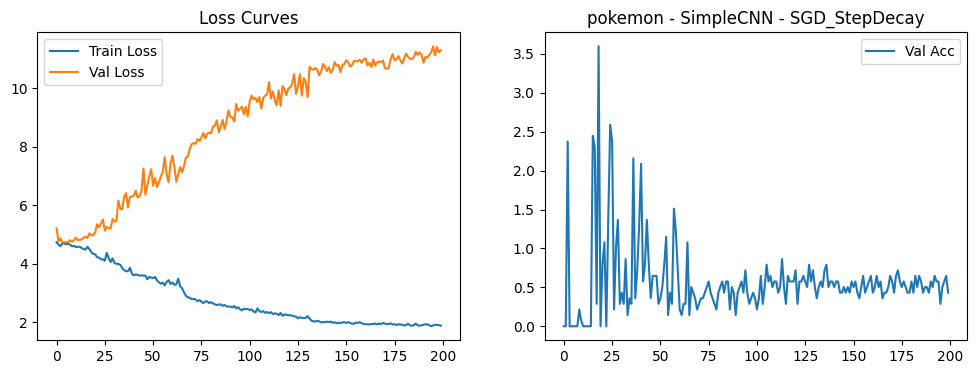


--- Model: SimpleCNN, Config: SGD_Cosine ---


  0%|          | 1/200 [00:07<26:05,  7.87s/it]

Epoch   1/200 | Train Loss: 4.3100 | Val Loss: 4.9040 | Val Acc: 0.79%


  1%|          | 2/200 [00:15<26:07,  7.92s/it]

Epoch   2/200 | Train Loss: 4.3552 | Val Loss: 4.9545 | Val Acc: 0.00%


  2%|▏         | 3/200 [00:24<26:36,  8.10s/it]

Epoch   3/200 | Train Loss: 4.3448 | Val Loss: 5.3208 | Val Acc: 2.09%


  2%|▏         | 4/200 [00:31<25:35,  7.83s/it]

Epoch   4/200 | Train Loss: 4.2410 | Val Loss: 5.2602 | Val Acc: 0.86%


  2%|▎         | 5/200 [00:40<26:18,  8.10s/it]

Epoch   5/200 | Train Loss: 4.1922 | Val Loss: 5.5184 | Val Acc: 1.08%


  3%|▎         | 6/200 [00:48<26:19,  8.14s/it]

Epoch   6/200 | Train Loss: 4.1068 | Val Loss: 5.5326 | Val Acc: 0.72%


  4%|▎         | 7/200 [00:55<25:19,  7.88s/it]

Epoch   7/200 | Train Loss: 4.1399 | Val Loss: 5.8180 | Val Acc: 0.00%


  4%|▍         | 8/200 [01:04<25:42,  8.04s/it]

Epoch   8/200 | Train Loss: 4.0466 | Val Loss: 6.1641 | Val Acc: 0.43%


  4%|▍         | 9/200 [01:11<25:10,  7.91s/it]

Epoch   9/200 | Train Loss: 4.2816 | Val Loss: 5.6221 | Val Acc: 1.51%


  5%|▌         | 10/200 [01:19<25:24,  8.03s/it]

Epoch  10/200 | Train Loss: 4.1471 | Val Loss: 5.4483 | Val Acc: 2.52%


  6%|▌         | 11/200 [01:28<25:27,  8.08s/it]

Epoch  11/200 | Train Loss: 4.2124 | Val Loss: 5.5073 | Val Acc: 0.36%


  6%|▌         | 12/200 [01:35<24:44,  7.90s/it]

Epoch  12/200 | Train Loss: 4.0349 | Val Loss: 5.7567 | Val Acc: 0.00%


  6%|▋         | 13/200 [01:44<25:12,  8.09s/it]

Epoch  13/200 | Train Loss: 3.9889 | Val Loss: 5.7290 | Val Acc: 0.14%


  7%|▋         | 14/200 [01:52<25:17,  8.16s/it]

Epoch  14/200 | Train Loss: 3.9462 | Val Loss: 6.0469 | Val Acc: 0.14%


  8%|▊         | 15/200 [02:00<24:32,  7.96s/it]

Epoch  15/200 | Train Loss: 3.8730 | Val Loss: 6.4725 | Val Acc: 0.65%


  8%|▊         | 16/200 [02:08<24:53,  8.12s/it]

Epoch  16/200 | Train Loss: 3.7905 | Val Loss: 5.8506 | Val Acc: 1.44%


  8%|▊         | 17/200 [02:16<24:13,  7.94s/it]

Epoch  17/200 | Train Loss: 3.7182 | Val Loss: 6.1808 | Val Acc: 1.44%


  9%|▉         | 18/200 [02:24<24:29,  8.07s/it]

Epoch  18/200 | Train Loss: 3.6093 | Val Loss: 6.4968 | Val Acc: 0.94%


 10%|▉         | 19/200 [02:32<24:31,  8.13s/it]

Epoch  19/200 | Train Loss: 3.4873 | Val Loss: 6.2681 | Val Acc: 0.72%


 10%|█         | 20/200 [02:39<23:39,  7.88s/it]

Epoch  20/200 | Train Loss: 3.5421 | Val Loss: 6.1697 | Val Acc: 0.65%


 10%|█         | 21/200 [02:48<24:07,  8.08s/it]

Epoch  21/200 | Train Loss: 3.5249 | Val Loss: 6.3122 | Val Acc: 0.58%


 11%|█         | 22/200 [02:56<23:54,  8.06s/it]

Epoch  22/200 | Train Loss: 3.4504 | Val Loss: 6.8686 | Val Acc: 0.36%


 12%|█▏        | 23/200 [03:04<23:24,  7.94s/it]

Epoch  23/200 | Train Loss: 3.7053 | Val Loss: 6.6397 | Val Acc: 0.22%


 12%|█▏        | 24/200 [03:12<23:40,  8.07s/it]

Epoch  24/200 | Train Loss: 3.6203 | Val Loss: 6.3513 | Val Acc: 1.29%


 12%|█▎        | 25/200 [03:20<23:00,  7.89s/it]

Epoch  25/200 | Train Loss: 3.4910 | Val Loss: 6.5648 | Val Acc: 0.43%


 13%|█▎        | 26/200 [03:28<23:17,  8.03s/it]

Epoch  26/200 | Train Loss: 3.5381 | Val Loss: 6.4753 | Val Acc: 1.22%


 14%|█▎        | 27/200 [03:36<23:18,  8.08s/it]

Epoch  27/200 | Train Loss: 3.3604 | Val Loss: 6.5614 | Val Acc: 0.50%


 14%|█▍        | 28/200 [03:44<22:56,  8.00s/it]

Epoch  28/200 | Train Loss: 3.2784 | Val Loss: 7.0633 | Val Acc: 0.65%


 14%|█▍        | 29/200 [03:52<23:12,  8.14s/it]

Epoch  29/200 | Train Loss: 3.3851 | Val Loss: 6.7298 | Val Acc: 0.43%


 15%|█▌        | 30/200 [04:00<22:29,  7.94s/it]

Epoch  30/200 | Train Loss: 3.6126 | Val Loss: 6.9757 | Val Acc: 0.94%


 16%|█▌        | 31/200 [04:08<22:35,  8.02s/it]

Epoch  31/200 | Train Loss: 3.3540 | Val Loss: 6.8684 | Val Acc: 1.65%


 16%|█▌        | 32/200 [04:16<22:43,  8.12s/it]

Epoch  32/200 | Train Loss: 3.4020 | Val Loss: 6.6617 | Val Acc: 0.79%


 16%|█▋        | 33/200 [04:24<21:59,  7.90s/it]

Epoch  33/200 | Train Loss: 3.2796 | Val Loss: 6.8594 | Val Acc: 1.01%


 17%|█▋        | 34/200 [04:32<22:20,  8.07s/it]

Epoch  34/200 | Train Loss: 3.2053 | Val Loss: 7.0021 | Val Acc: 0.43%


 18%|█▊        | 35/200 [04:41<22:30,  8.19s/it]

Epoch  35/200 | Train Loss: 3.2099 | Val Loss: 7.0294 | Val Acc: 0.29%


 18%|█▊        | 36/200 [04:48<21:40,  7.93s/it]

Epoch  36/200 | Train Loss: 3.1449 | Val Loss: 7.0983 | Val Acc: 0.50%


 18%|█▊        | 37/200 [04:56<21:49,  8.04s/it]

Epoch  37/200 | Train Loss: 3.3754 | Val Loss: 6.9221 | Val Acc: 0.94%


 19%|█▉        | 38/200 [05:04<21:10,  7.84s/it]

Epoch  38/200 | Train Loss: 3.2753 | Val Loss: 6.8683 | Val Acc: 0.43%


 20%|█▉        | 39/200 [05:12<21:37,  8.06s/it]

Epoch  39/200 | Train Loss: 3.4232 | Val Loss: 6.5418 | Val Acc: 1.87%


 20%|██        | 40/200 [05:20<21:29,  8.06s/it]

Epoch  40/200 | Train Loss: 3.2783 | Val Loss: 6.8479 | Val Acc: 0.72%


 20%|██        | 41/200 [05:28<20:43,  7.82s/it]

Epoch  41/200 | Train Loss: 3.2737 | Val Loss: 6.8952 | Val Acc: 0.22%


 21%|██        | 42/200 [05:36<21:07,  8.02s/it]

Epoch  42/200 | Train Loss: 3.3292 | Val Loss: 7.1416 | Val Acc: 0.29%


 22%|██▏       | 43/200 [05:44<20:55,  8.00s/it]

Epoch  43/200 | Train Loss: 3.2671 | Val Loss: 7.9197 | Val Acc: 0.43%


 22%|██▏       | 44/200 [05:52<20:42,  7.96s/it]

Epoch  44/200 | Train Loss: 3.2185 | Val Loss: 7.1213 | Val Acc: 0.65%


 22%|██▎       | 45/200 [06:00<20:41,  8.01s/it]

Epoch  45/200 | Train Loss: 3.0382 | Val Loss: 8.4837 | Val Acc: 0.22%


 23%|██▎       | 46/200 [06:07<20:05,  7.83s/it]

Epoch  46/200 | Train Loss: 3.2404 | Val Loss: 7.1822 | Val Acc: 0.58%


 24%|██▎       | 47/200 [06:16<20:25,  8.01s/it]

Epoch  47/200 | Train Loss: 3.2921 | Val Loss: 6.9185 | Val Acc: 0.58%


 24%|██▍       | 48/200 [06:24<20:09,  7.96s/it]

Epoch  48/200 | Train Loss: 3.2503 | Val Loss: 7.6205 | Val Acc: 0.22%


 24%|██▍       | 49/200 [06:31<19:37,  7.80s/it]

Epoch  49/200 | Train Loss: 3.2275 | Val Loss: 7.6912 | Val Acc: 0.43%


 25%|██▌       | 50/200 [06:39<19:48,  7.92s/it]

Epoch  50/200 | Train Loss: 3.2328 | Val Loss: 7.6210 | Val Acc: 0.65%


 26%|██▌       | 51/200 [06:47<19:15,  7.76s/it]

Epoch  51/200 | Train Loss: 3.0617 | Val Loss: 7.4114 | Val Acc: 0.58%


 26%|██▌       | 52/200 [06:55<19:38,  7.96s/it]

Epoch  52/200 | Train Loss: 3.0807 | Val Loss: 7.8880 | Val Acc: 0.43%


 26%|██▋       | 53/200 [07:03<19:39,  8.03s/it]

Epoch  53/200 | Train Loss: 2.9619 | Val Loss: 8.1161 | Val Acc: 1.94%


 27%|██▋       | 54/200 [07:11<18:59,  7.80s/it]

Epoch  54/200 | Train Loss: 3.0765 | Val Loss: 6.7927 | Val Acc: 0.58%


 28%|██▊       | 55/200 [07:19<19:25,  8.04s/it]

Epoch  55/200 | Train Loss: 3.0050 | Val Loss: 8.3262 | Val Acc: 0.07%


 28%|██▊       | 56/200 [07:27<18:53,  7.87s/it]

Epoch  56/200 | Train Loss: 3.1389 | Val Loss: 7.6089 | Val Acc: 0.58%


 28%|██▊       | 57/200 [07:35<19:07,  8.02s/it]

Epoch  57/200 | Train Loss: 3.0473 | Val Loss: 8.4150 | Val Acc: 0.50%


 29%|██▉       | 58/200 [07:43<19:08,  8.09s/it]

Epoch  58/200 | Train Loss: 3.0234 | Val Loss: 7.1677 | Val Acc: 0.36%


 30%|██▉       | 59/200 [07:51<18:35,  7.91s/it]

Epoch  59/200 | Train Loss: 2.8866 | Val Loss: 7.9991 | Val Acc: 0.79%


 30%|███       | 60/200 [07:59<18:47,  8.05s/it]

Epoch  60/200 | Train Loss: 2.9769 | Val Loss: 8.5542 | Val Acc: 0.50%


 30%|███       | 61/200 [08:07<18:35,  8.03s/it]

Epoch  61/200 | Train Loss: 3.0376 | Val Loss: 7.3851 | Val Acc: 0.29%


 31%|███       | 62/200 [08:15<18:17,  7.95s/it]

Epoch  62/200 | Train Loss: 2.9408 | Val Loss: 7.5138 | Val Acc: 1.01%


 32%|███▏      | 63/200 [08:24<18:35,  8.15s/it]

Epoch  63/200 | Train Loss: 2.8739 | Val Loss: 8.2995 | Val Acc: 0.43%


 32%|███▏      | 64/200 [08:31<17:50,  7.87s/it]

Epoch  64/200 | Train Loss: 2.9662 | Val Loss: 7.7992 | Val Acc: 0.43%


 32%|███▎      | 65/200 [08:39<18:05,  8.04s/it]

Epoch  65/200 | Train Loss: 2.8742 | Val Loss: 7.5568 | Val Acc: 0.50%


 33%|███▎      | 66/200 [08:47<18:05,  8.10s/it]

Epoch  66/200 | Train Loss: 2.9500 | Val Loss: 7.0910 | Val Acc: 0.94%


 34%|███▎      | 67/200 [08:55<17:26,  7.87s/it]

Epoch  67/200 | Train Loss: 3.1076 | Val Loss: 8.2173 | Val Acc: 0.50%


 34%|███▍      | 68/200 [09:03<17:43,  8.06s/it]

Epoch  68/200 | Train Loss: 2.8499 | Val Loss: 8.3070 | Val Acc: 0.79%


 34%|███▍      | 69/200 [09:11<17:11,  7.88s/it]

Epoch  69/200 | Train Loss: 2.8385 | Val Loss: 8.2345 | Val Acc: 0.22%


 35%|███▌      | 70/200 [09:19<17:27,  8.06s/it]

Epoch  70/200 | Train Loss: 2.7731 | Val Loss: 8.4985 | Val Acc: 0.79%


 36%|███▌      | 71/200 [09:27<17:25,  8.10s/it]

Epoch  71/200 | Train Loss: 2.7132 | Val Loss: 8.0782 | Val Acc: 0.22%


 36%|███▌      | 72/200 [09:35<16:48,  7.88s/it]

Epoch  72/200 | Train Loss: 2.7094 | Val Loss: 9.1879 | Val Acc: 0.07%


 36%|███▋      | 73/200 [09:43<16:59,  8.03s/it]

Epoch  73/200 | Train Loss: 2.6900 | Val Loss: 8.5730 | Val Acc: 0.29%


 37%|███▋      | 74/200 [09:52<17:05,  8.14s/it]

Epoch  74/200 | Train Loss: 2.6333 | Val Loss: 8.8086 | Val Acc: 0.29%


 38%|███▊      | 75/200 [09:59<16:28,  7.91s/it]

Epoch  75/200 | Train Loss: 2.7705 | Val Loss: 8.6706 | Val Acc: 0.29%


 38%|███▊      | 76/200 [10:07<16:36,  8.04s/it]

Epoch  76/200 | Train Loss: 2.8130 | Val Loss: 7.8716 | Val Acc: 0.07%


 38%|███▊      | 77/200 [10:15<16:06,  7.86s/it]

Epoch  77/200 | Train Loss: 2.7260 | Val Loss: 8.4363 | Val Acc: 0.29%


 39%|███▉      | 78/200 [10:23<16:13,  7.98s/it]

Epoch  78/200 | Train Loss: 2.7175 | Val Loss: 8.7249 | Val Acc: 0.29%


 40%|███▉      | 79/200 [10:31<16:14,  8.05s/it]

Epoch  79/200 | Train Loss: 2.7564 | Val Loss: 7.7422 | Val Acc: 1.08%


 40%|████      | 80/200 [10:39<15:46,  7.88s/it]

Epoch  80/200 | Train Loss: 2.7570 | Val Loss: 9.1472 | Val Acc: 0.00%


 40%|████      | 81/200 [10:47<15:56,  8.04s/it]

Epoch  81/200 | Train Loss: 2.6144 | Val Loss: 8.6949 | Val Acc: 0.50%


 41%|████      | 82/200 [10:55<15:57,  8.11s/it]

Epoch  82/200 | Train Loss: 2.6193 | Val Loss: 9.0022 | Val Acc: 0.29%


 42%|████▏     | 83/200 [11:03<15:33,  7.98s/it]

Epoch  83/200 | Train Loss: 2.6347 | Val Loss: 9.3865 | Val Acc: 0.43%


 42%|████▏     | 84/200 [11:11<15:38,  8.09s/it]

Epoch  84/200 | Train Loss: 2.5075 | Val Loss: 8.1024 | Val Acc: 0.50%


 42%|████▎     | 85/200 [11:19<15:05,  7.88s/it]

Epoch  85/200 | Train Loss: 2.4475 | Val Loss: 8.3606 | Val Acc: 0.50%


 43%|████▎     | 86/200 [11:27<15:14,  8.02s/it]

Epoch  86/200 | Train Loss: 2.5557 | Val Loss: 8.5835 | Val Acc: 0.65%


 44%|████▎     | 87/200 [11:35<15:14,  8.10s/it]

Epoch  87/200 | Train Loss: 2.4497 | Val Loss: 8.6077 | Val Acc: 0.43%


 44%|████▍     | 88/200 [11:43<14:45,  7.90s/it]

Epoch  88/200 | Train Loss: 2.6162 | Val Loss: 8.6135 | Val Acc: 0.29%


 44%|████▍     | 89/200 [11:51<14:53,  8.05s/it]

Epoch  89/200 | Train Loss: 2.4707 | Val Loss: 8.9393 | Val Acc: 0.36%


 45%|████▌     | 90/200 [11:59<14:42,  8.02s/it]

Epoch  90/200 | Train Loss: 2.5129 | Val Loss: 8.2384 | Val Acc: 0.50%


 46%|████▌     | 91/200 [12:07<14:22,  7.92s/it]

Epoch  91/200 | Train Loss: 2.4053 | Val Loss: 9.3118 | Val Acc: 0.22%


 46%|████▌     | 92/200 [12:15<14:25,  8.01s/it]

Epoch  92/200 | Train Loss: 2.7786 | Val Loss: 9.0331 | Val Acc: 0.94%


 46%|████▋     | 93/200 [12:22<13:56,  7.82s/it]

Epoch  93/200 | Train Loss: 2.5994 | Val Loss: 8.6457 | Val Acc: 0.79%


 47%|████▋     | 94/200 [12:31<14:00,  7.93s/it]

Epoch  94/200 | Train Loss: 2.4323 | Val Loss: 8.7090 | Val Acc: 0.43%


 48%|████▊     | 95/200 [12:39<14:00,  8.01s/it]

Epoch  95/200 | Train Loss: 2.5914 | Val Loss: 8.9572 | Val Acc: 0.65%


 48%|████▊     | 96/200 [12:46<13:31,  7.80s/it]

Epoch  96/200 | Train Loss: 2.4657 | Val Loss: 8.0853 | Val Acc: 0.36%


 48%|████▊     | 97/200 [12:55<13:46,  8.03s/it]

Epoch  97/200 | Train Loss: 2.4434 | Val Loss: 8.4288 | Val Acc: 0.65%


 49%|████▉     | 98/200 [13:02<13:19,  7.84s/it]

Epoch  98/200 | Train Loss: 2.3667 | Val Loss: 8.0333 | Val Acc: 0.79%


 50%|████▉     | 99/200 [13:10<13:21,  7.94s/it]

Epoch  99/200 | Train Loss: 2.4418 | Val Loss: 9.2765 | Val Acc: 0.22%


 50%|█████     | 100/200 [13:18<13:20,  8.00s/it]

Epoch 100/200 | Train Loss: 2.3286 | Val Loss: 8.3808 | Val Acc: 0.72%


 50%|█████     | 101/200 [13:26<12:55,  7.83s/it]

Epoch 101/200 | Train Loss: 2.3957 | Val Loss: 8.6565 | Val Acc: 0.43%


 51%|█████     | 102/200 [13:34<13:02,  7.98s/it]

Epoch 102/200 | Train Loss: 2.2987 | Val Loss: 9.2100 | Val Acc: 0.29%


 52%|█████▏    | 103/200 [13:42<12:39,  7.83s/it]

Epoch 103/200 | Train Loss: 2.2394 | Val Loss: 8.7567 | Val Acc: 0.58%


 52%|█████▏    | 104/200 [13:50<12:35,  7.87s/it]

Epoch 104/200 | Train Loss: 2.3596 | Val Loss: 9.1093 | Val Acc: 0.94%


 52%|█████▎    | 105/200 [13:58<12:38,  7.98s/it]

Epoch 105/200 | Train Loss: 2.2155 | Val Loss: 9.8850 | Val Acc: 0.43%


 53%|█████▎    | 106/200 [14:05<12:06,  7.73s/it]

Epoch 106/200 | Train Loss: 2.2419 | Val Loss: 8.6102 | Val Acc: 0.79%


 54%|█████▎    | 107/200 [14:13<12:15,  7.90s/it]

Epoch 107/200 | Train Loss: 2.1932 | Val Loss: 9.2122 | Val Acc: 0.50%


 54%|█████▍    | 108/200 [14:21<12:02,  7.86s/it]

Epoch 108/200 | Train Loss: 2.2021 | Val Loss: 8.8269 | Val Acc: 0.58%


 55%|█████▍    | 109/200 [14:29<12:01,  7.93s/it]

Epoch 109/200 | Train Loss: 2.1521 | Val Loss: 9.4490 | Val Acc: 0.36%


 55%|█████▌    | 110/200 [14:38<12:04,  8.05s/it]

Epoch 110/200 | Train Loss: 2.1978 | Val Loss: 9.1851 | Val Acc: 0.58%


 56%|█████▌    | 111/200 [14:45<11:37,  7.84s/it]

Epoch 111/200 | Train Loss: 2.1038 | Val Loss: 9.6172 | Val Acc: 0.00%


 56%|█████▌    | 112/200 [14:53<11:49,  8.07s/it]

Epoch 112/200 | Train Loss: 2.3380 | Val Loss: 9.1932 | Val Acc: 0.86%


 56%|█████▋    | 113/200 [15:02<11:47,  8.13s/it]

Epoch 113/200 | Train Loss: 2.1719 | Val Loss: 8.4890 | Val Acc: 0.29%


 57%|█████▋    | 114/200 [15:09<11:19,  7.90s/it]

Epoch 114/200 | Train Loss: 2.1347 | Val Loss: 9.7838 | Val Acc: 0.14%


 57%|█████▊    | 115/200 [15:17<11:22,  8.02s/it]

Epoch 115/200 | Train Loss: 2.0543 | Val Loss: 9.1849 | Val Acc: 0.58%


 58%|█████▊    | 116/200 [15:25<10:56,  7.82s/it]

Epoch 116/200 | Train Loss: 2.0739 | Val Loss: 9.4401 | Val Acc: 0.29%


 58%|█████▊    | 117/200 [15:33<11:02,  7.98s/it]

Epoch 117/200 | Train Loss: 2.0482 | Val Loss: 8.9527 | Val Acc: 0.00%


 59%|█████▉    | 118/200 [15:41<10:58,  8.03s/it]

Epoch 118/200 | Train Loss: 2.1267 | Val Loss: 9.4460 | Val Acc: 0.22%


 60%|█████▉    | 119/200 [15:49<10:32,  7.81s/it]

Epoch 119/200 | Train Loss: 2.0040 | Val Loss: 9.9082 | Val Acc: 0.65%


 60%|██████    | 120/200 [15:57<10:42,  8.03s/it]

Epoch 120/200 | Train Loss: 2.0667 | Val Loss: 8.9231 | Val Acc: 0.79%


 60%|██████    | 121/200 [16:05<10:22,  7.87s/it]

Epoch 121/200 | Train Loss: 2.1350 | Val Loss: 10.4138 | Val Acc: 0.50%


 61%|██████    | 122/200 [16:12<10:13,  7.87s/it]

Epoch 122/200 | Train Loss: 1.9917 | Val Loss: 9.7950 | Val Acc: 0.50%


 62%|██████▏   | 123/200 [16:21<10:10,  7.93s/it]

Epoch 123/200 | Train Loss: 1.9980 | Val Loss: 10.2580 | Val Acc: 0.58%


 62%|██████▏   | 124/200 [16:28<09:51,  7.78s/it]

Epoch 124/200 | Train Loss: 2.0828 | Val Loss: 9.4337 | Val Acc: 0.43%


 62%|██████▎   | 125/200 [16:36<09:56,  7.95s/it]

Epoch 125/200 | Train Loss: 2.0057 | Val Loss: 9.5505 | Val Acc: 0.36%


 63%|██████▎   | 126/200 [16:44<09:43,  7.89s/it]

Epoch 126/200 | Train Loss: 1.9956 | Val Loss: 9.3054 | Val Acc: 0.22%


 64%|██████▎   | 127/200 [16:52<09:29,  7.80s/it]

Epoch 127/200 | Train Loss: 1.8832 | Val Loss: 9.8344 | Val Acc: 0.22%


 64%|██████▍   | 128/200 [17:00<09:29,  7.91s/it]

Epoch 128/200 | Train Loss: 1.9214 | Val Loss: 10.3561 | Val Acc: 0.58%


 64%|██████▍   | 129/200 [17:07<09:07,  7.71s/it]

Epoch 129/200 | Train Loss: 1.9700 | Val Loss: 9.7888 | Val Acc: 0.58%


 65%|██████▌   | 130/200 [17:15<09:14,  7.92s/it]

Epoch 130/200 | Train Loss: 1.8690 | Val Loss: 9.4671 | Val Acc: 0.36%


 66%|██████▌   | 131/200 [17:23<09:07,  7.93s/it]

Epoch 131/200 | Train Loss: 1.8734 | Val Loss: 9.9701 | Val Acc: 0.36%


 66%|██████▌   | 132/200 [17:31<08:52,  7.83s/it]

Epoch 132/200 | Train Loss: 1.8609 | Val Loss: 9.5981 | Val Acc: 0.22%


 66%|██████▋   | 133/200 [17:39<08:55,  8.00s/it]

Epoch 133/200 | Train Loss: 1.7573 | Val Loss: 10.3421 | Val Acc: 0.58%


 67%|██████▋   | 134/200 [17:47<08:31,  7.76s/it]

Epoch 134/200 | Train Loss: 1.8368 | Val Loss: 10.2615 | Val Acc: 0.36%


 68%|██████▊   | 135/200 [17:55<08:32,  7.88s/it]

Epoch 135/200 | Train Loss: 1.8444 | Val Loss: 10.2353 | Val Acc: 0.43%


 68%|██████▊   | 136/200 [18:03<08:33,  8.02s/it]

Epoch 136/200 | Train Loss: 1.7937 | Val Loss: 10.2310 | Val Acc: 0.65%


 68%|██████▊   | 137/200 [18:10<08:11,  7.80s/it]

Epoch 137/200 | Train Loss: 1.7333 | Val Loss: 10.2982 | Val Acc: 0.22%


 69%|██████▉   | 138/200 [18:19<08:12,  7.94s/it]

Epoch 138/200 | Train Loss: 1.7964 | Val Loss: 10.2277 | Val Acc: 0.58%


 70%|██████▉   | 139/200 [18:26<07:53,  7.76s/it]

Epoch 139/200 | Train Loss: 1.7440 | Val Loss: 10.6702 | Val Acc: 0.50%


 70%|███████   | 140/200 [18:34<07:53,  7.89s/it]

Epoch 140/200 | Train Loss: 1.6815 | Val Loss: 11.0336 | Val Acc: 0.36%


 70%|███████   | 141/200 [18:42<07:50,  7.97s/it]

Epoch 141/200 | Train Loss: 1.7467 | Val Loss: 10.3263 | Val Acc: 0.29%


 71%|███████   | 142/200 [18:50<07:29,  7.75s/it]

Epoch 142/200 | Train Loss: 1.7617 | Val Loss: 10.6318 | Val Acc: 0.22%


 72%|███████▏  | 143/200 [18:58<07:34,  7.98s/it]

Epoch 143/200 | Train Loss: 1.6704 | Val Loss: 10.4273 | Val Acc: 0.36%


 72%|███████▏  | 144/200 [19:06<07:21,  7.89s/it]

Epoch 144/200 | Train Loss: 1.6777 | Val Loss: 10.3912 | Val Acc: 0.29%


 72%|███████▎  | 145/200 [19:14<07:12,  7.86s/it]

Epoch 145/200 | Train Loss: 1.6221 | Val Loss: 10.3692 | Val Acc: 0.43%


 73%|███████▎  | 146/200 [19:22<07:06,  7.90s/it]

Epoch 146/200 | Train Loss: 1.5848 | Val Loss: 10.8024 | Val Acc: 0.86%


 74%|███████▎  | 147/200 [19:29<06:51,  7.77s/it]

Epoch 147/200 | Train Loss: 1.6787 | Val Loss: 10.7026 | Val Acc: 0.58%


 74%|███████▍  | 148/200 [19:37<06:54,  7.97s/it]

Epoch 148/200 | Train Loss: 1.6532 | Val Loss: 10.7268 | Val Acc: 0.22%


 74%|███████▍  | 149/200 [19:45<06:46,  7.97s/it]

Epoch 149/200 | Train Loss: 1.6354 | Val Loss: 10.4654 | Val Acc: 0.50%


 75%|███████▌  | 150/200 [19:53<06:30,  7.80s/it]

Epoch 150/200 | Train Loss: 1.5602 | Val Loss: 10.8282 | Val Acc: 0.58%


 76%|███████▌  | 151/200 [20:01<06:29,  7.95s/it]

Epoch 151/200 | Train Loss: 1.6404 | Val Loss: 10.6781 | Val Acc: 0.29%


 76%|███████▌  | 152/200 [20:09<06:13,  7.77s/it]

Epoch 152/200 | Train Loss: 1.6409 | Val Loss: 10.5899 | Val Acc: 0.58%


 76%|███████▋  | 153/200 [20:17<06:15,  7.98s/it]

Epoch 153/200 | Train Loss: 1.5366 | Val Loss: 11.0795 | Val Acc: 0.72%


 77%|███████▋  | 154/200 [20:25<06:09,  8.03s/it]

Epoch 154/200 | Train Loss: 1.5801 | Val Loss: 11.1232 | Val Acc: 0.43%


 78%|███████▊  | 155/200 [20:32<05:51,  7.81s/it]

Epoch 155/200 | Train Loss: 1.4931 | Val Loss: 11.2752 | Val Acc: 0.65%


 78%|███████▊  | 156/200 [20:41<05:50,  7.97s/it]

Epoch 156/200 | Train Loss: 1.5401 | Val Loss: 11.2035 | Val Acc: 0.43%


 78%|███████▊  | 157/200 [20:48<05:34,  7.78s/it]

Epoch 157/200 | Train Loss: 1.4976 | Val Loss: 11.0251 | Val Acc: 0.58%


 79%|███████▉  | 158/200 [20:56<05:32,  7.91s/it]

Epoch 158/200 | Train Loss: 1.5536 | Val Loss: 11.0716 | Val Acc: 0.43%


 80%|███████▉  | 159/200 [21:05<05:28,  8.01s/it]

Epoch 159/200 | Train Loss: 1.4959 | Val Loss: 11.7235 | Val Acc: 0.29%


 80%|████████  | 160/200 [21:12<05:11,  7.79s/it]

Epoch 160/200 | Train Loss: 1.5579 | Val Loss: 11.5086 | Val Acc: 0.50%


 80%|████████  | 161/200 [21:20<05:10,  7.95s/it]

Epoch 161/200 | Train Loss: 1.4982 | Val Loss: 11.5542 | Val Acc: 0.36%


 81%|████████  | 162/200 [21:28<04:58,  7.85s/it]

Epoch 162/200 | Train Loss: 1.4771 | Val Loss: 11.2407 | Val Acc: 0.29%


 82%|████████▏ | 163/200 [21:36<04:52,  7.90s/it]

Epoch 163/200 | Train Loss: 1.4782 | Val Loss: 11.3355 | Val Acc: 0.50%


 82%|████████▏ | 164/200 [21:44<04:47,  7.99s/it]

Epoch 164/200 | Train Loss: 1.4620 | Val Loss: 11.2708 | Val Acc: 0.29%


 82%|████████▎ | 165/200 [21:51<04:32,  7.79s/it]

Epoch 165/200 | Train Loss: 1.4549 | Val Loss: 11.6247 | Val Acc: 0.50%


 83%|████████▎ | 166/200 [22:00<04:29,  7.93s/it]

Epoch 166/200 | Train Loss: 1.4525 | Val Loss: 11.2772 | Val Acc: 0.58%


 84%|████████▎ | 167/200 [22:08<04:25,  8.05s/it]

Epoch 167/200 | Train Loss: 1.4402 | Val Loss: 11.3666 | Val Acc: 0.43%


 84%|████████▍ | 168/200 [22:15<04:09,  7.81s/it]

Epoch 168/200 | Train Loss: 1.4186 | Val Loss: 11.5377 | Val Acc: 0.65%


 84%|████████▍ | 169/200 [22:23<04:06,  7.96s/it]

Epoch 169/200 | Train Loss: 1.3979 | Val Loss: 11.5649 | Val Acc: 0.65%


 85%|████████▌ | 170/200 [22:31<03:51,  7.72s/it]

Epoch 170/200 | Train Loss: 1.3983 | Val Loss: 11.6583 | Val Acc: 0.50%


 86%|████████▌ | 171/200 [22:39<03:50,  7.95s/it]

Epoch 171/200 | Train Loss: 1.3679 | Val Loss: 11.6423 | Val Acc: 0.50%


 86%|████████▌ | 172/200 [22:47<03:45,  8.04s/it]

Epoch 172/200 | Train Loss: 1.3892 | Val Loss: 11.3430 | Val Acc: 0.65%


 86%|████████▋ | 173/200 [22:55<03:31,  7.84s/it]

Epoch 173/200 | Train Loss: 1.3380 | Val Loss: 11.7460 | Val Acc: 0.65%


 87%|████████▋ | 174/200 [23:03<03:29,  8.05s/it]

Epoch 174/200 | Train Loss: 1.3408 | Val Loss: 11.7247 | Val Acc: 0.58%


 88%|████████▊ | 175/200 [23:11<03:18,  7.96s/it]

Epoch 175/200 | Train Loss: 1.3189 | Val Loss: 11.6874 | Val Acc: 0.72%


 88%|████████▊ | 176/200 [23:19<03:10,  7.95s/it]

Epoch 176/200 | Train Loss: 1.3691 | Val Loss: 11.6261 | Val Acc: 0.58%


 88%|████████▊ | 177/200 [23:27<03:04,  8.02s/it]

Epoch 177/200 | Train Loss: 1.3356 | Val Loss: 11.7418 | Val Acc: 0.50%


 89%|████████▉ | 178/200 [23:34<02:51,  7.81s/it]

Epoch 178/200 | Train Loss: 1.3402 | Val Loss: 11.5191 | Val Acc: 0.50%


 90%|████████▉ | 179/200 [23:43<02:48,  8.01s/it]

Epoch 179/200 | Train Loss: 1.3380 | Val Loss: 11.8870 | Val Acc: 0.50%


 90%|█████████ | 180/200 [23:51<02:42,  8.11s/it]

Epoch 180/200 | Train Loss: 1.3158 | Val Loss: 11.9010 | Val Acc: 0.58%


 90%|█████████ | 181/200 [23:59<02:29,  7.86s/it]

Epoch 181/200 | Train Loss: 1.2972 | Val Loss: 12.1686 | Val Acc: 0.50%


 91%|█████████ | 182/200 [24:07<02:24,  8.03s/it]

Epoch 182/200 | Train Loss: 1.3040 | Val Loss: 12.0065 | Val Acc: 0.65%


 92%|█████████▏| 183/200 [24:14<02:12,  7.79s/it]

Epoch 183/200 | Train Loss: 1.2710 | Val Loss: 11.9954 | Val Acc: 0.65%


 92%|█████████▏| 184/200 [24:22<02:06,  7.92s/it]

Epoch 184/200 | Train Loss: 1.3413 | Val Loss: 11.9955 | Val Acc: 0.58%


 92%|█████████▎| 185/200 [24:30<01:59,  7.97s/it]

Epoch 185/200 | Train Loss: 1.3278 | Val Loss: 11.8889 | Val Acc: 0.43%


 93%|█████████▎| 186/200 [24:38<01:49,  7.80s/it]

Epoch 186/200 | Train Loss: 1.2802 | Val Loss: 11.8227 | Val Acc: 0.58%


 94%|█████████▎| 187/200 [24:46<01:43,  7.97s/it]

Epoch 187/200 | Train Loss: 1.2804 | Val Loss: 11.9282 | Val Acc: 0.72%


 94%|█████████▍| 188/200 [24:54<01:33,  7.78s/it]

Epoch 188/200 | Train Loss: 1.2834 | Val Loss: 12.0106 | Val Acc: 0.58%


 94%|█████████▍| 189/200 [25:02<01:26,  7.88s/it]

Epoch 189/200 | Train Loss: 1.2642 | Val Loss: 11.9731 | Val Acc: 0.72%


 95%|█████████▌| 190/200 [25:10<01:19,  7.98s/it]

Epoch 190/200 | Train Loss: 1.2837 | Val Loss: 12.1300 | Val Acc: 0.43%


 96%|█████████▌| 191/200 [25:17<01:09,  7.75s/it]

Epoch 191/200 | Train Loss: 1.3166 | Val Loss: 11.8147 | Val Acc: 0.65%


 96%|█████████▌| 192/200 [25:26<01:03,  7.95s/it]

Epoch 192/200 | Train Loss: 1.3042 | Val Loss: 11.9240 | Val Acc: 0.72%


 96%|█████████▋| 193/200 [25:33<00:55,  7.86s/it]

Epoch 193/200 | Train Loss: 1.2575 | Val Loss: 12.1819 | Val Acc: 0.72%


 97%|█████████▋| 194/200 [25:41<00:47,  7.88s/it]

Epoch 194/200 | Train Loss: 1.2827 | Val Loss: 12.2753 | Val Acc: 0.65%


 98%|█████████▊| 195/200 [25:49<00:39,  7.92s/it]

Epoch 195/200 | Train Loss: 1.2690 | Val Loss: 12.0786 | Val Acc: 0.79%


 98%|█████████▊| 196/200 [25:56<00:30,  7.70s/it]

Epoch 196/200 | Train Loss: 1.2576 | Val Loss: 12.1967 | Val Acc: 0.65%


 98%|█████████▊| 197/200 [26:05<00:23,  7.88s/it]

Epoch 197/200 | Train Loss: 1.2500 | Val Loss: 12.0901 | Val Acc: 0.50%


 99%|█████████▉| 198/200 [26:12<00:15,  7.84s/it]

Epoch 198/200 | Train Loss: 1.2959 | Val Loss: 12.1788 | Val Acc: 0.58%


100%|█████████▉| 199/200 [26:20<00:07,  7.82s/it]

Epoch 199/200 | Train Loss: 1.2778 | Val Loss: 12.3142 | Val Acc: 0.58%


100%|██████████| 200/200 [26:28<00:00,  7.94s/it]

Epoch 200/200 | Train Loss: 1.2562 | Val Loss: 12.1662 | Val Acc: 0.65%


FINAL TEST ACCURACY: 0.00%



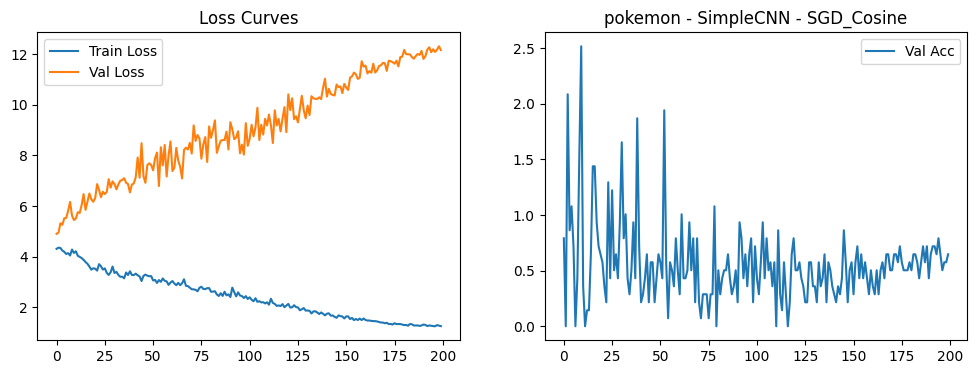


--- Model: SimpleCNN, Config: Adam_NoReg ---


  1%|          | 1/100 [00:07<12:28,  7.56s/it]

Epoch   1/100 | Train Loss: 3.9516 | Val Loss: 6.2336 | Val Acc: 1.51%


  2%|▏         | 2/100 [00:15<12:56,  7.92s/it]

Epoch   2/100 | Train Loss: 3.7325 | Val Loss: 6.5152 | Val Acc: 1.37%


  3%|▎         | 3/100 [00:24<13:40,  8.46s/it]

Epoch   3/100 | Train Loss: 3.4783 | Val Loss: 7.1686 | Val Acc: 0.36%


  4%|▍         | 4/100 [00:33<13:35,  8.50s/it]

Epoch   4/100 | Train Loss: 3.3105 | Val Loss: 7.2763 | Val Acc: 0.58%


  5%|▌         | 5/100 [00:42<14:01,  8.86s/it]

Epoch   5/100 | Train Loss: 3.1804 | Val Loss: 8.0112 | Val Acc: 0.50%


  6%|▌         | 6/100 [00:51<13:35,  8.68s/it]

Epoch   6/100 | Train Loss: 3.1300 | Val Loss: 7.8765 | Val Acc: 0.94%


  7%|▋         | 7/100 [00:58<12:46,  8.25s/it]

Epoch   7/100 | Train Loss: 3.0820 | Val Loss: 7.4319 | Val Acc: 0.58%


  8%|▊         | 8/100 [01:07<12:44,  8.31s/it]

Epoch   8/100 | Train Loss: 2.9961 | Val Loss: 8.1334 | Val Acc: 0.58%


  9%|▉         | 9/100 [01:15<12:39,  8.35s/it]

Epoch   9/100 | Train Loss: 2.9063 | Val Loss: 8.6177 | Val Acc: 0.58%


 10%|█         | 10/100 [01:22<12:02,  8.02s/it]

Epoch  10/100 | Train Loss: 2.8965 | Val Loss: 8.7401 | Val Acc: 0.50%


 11%|█         | 11/100 [01:31<12:06,  8.17s/it]

Epoch  11/100 | Train Loss: 2.8472 | Val Loss: 8.0303 | Val Acc: 0.72%


 12%|█▏        | 12/100 [01:38<11:45,  8.01s/it]

Epoch  12/100 | Train Loss: 2.7904 | Val Loss: 8.4955 | Val Acc: 0.65%


 13%|█▎        | 13/100 [01:47<11:40,  8.05s/it]

Epoch  13/100 | Train Loss: 2.7584 | Val Loss: 7.8716 | Val Acc: 0.72%


 14%|█▍        | 14/100 [01:55<11:36,  8.09s/it]

Epoch  14/100 | Train Loss: 2.7050 | Val Loss: 8.2879 | Val Acc: 0.94%


 15%|█▌        | 15/100 [02:02<11:12,  7.91s/it]

Epoch  15/100 | Train Loss: 2.6573 | Val Loss: 9.4447 | Val Acc: 0.72%


 16%|█▌        | 16/100 [02:11<11:19,  8.08s/it]

Epoch  16/100 | Train Loss: 2.6150 | Val Loss: 9.3449 | Val Acc: 0.50%


 17%|█▋        | 17/100 [02:19<11:17,  8.16s/it]

Epoch  17/100 | Train Loss: 2.6670 | Val Loss: 9.1307 | Val Acc: 1.15%


 18%|█▊        | 18/100 [02:26<10:47,  7.90s/it]

Epoch  18/100 | Train Loss: 2.5708 | Val Loss: 9.1363 | Val Acc: 0.72%


 19%|█▉        | 19/100 [02:35<10:53,  8.07s/it]

Epoch  19/100 | Train Loss: 2.6233 | Val Loss: 9.4204 | Val Acc: 0.50%


 20%|██        | 20/100 [02:42<10:35,  7.94s/it]

Epoch  20/100 | Train Loss: 2.5140 | Val Loss: 9.1391 | Val Acc: 0.36%


 21%|██        | 21/100 [02:51<10:31,  8.00s/it]

Epoch  21/100 | Train Loss: 2.4475 | Val Loss: 9.5634 | Val Acc: 0.29%


 22%|██▏       | 22/100 [02:59<10:27,  8.05s/it]

Epoch  22/100 | Train Loss: 2.5004 | Val Loss: 9.7508 | Val Acc: 0.50%


 23%|██▎       | 23/100 [03:06<10:02,  7.83s/it]

Epoch  23/100 | Train Loss: 2.3957 | Val Loss: 10.0368 | Val Acc: 0.36%


 24%|██▍       | 24/100 [03:15<10:10,  8.04s/it]

Epoch  24/100 | Train Loss: 2.5329 | Val Loss: 9.4861 | Val Acc: 0.58%


 25%|██▌       | 25/100 [03:22<09:46,  7.82s/it]

Epoch  25/100 | Train Loss: 2.3726 | Val Loss: 9.8629 | Val Acc: 0.65%


 26%|██▌       | 26/100 [03:30<09:48,  7.96s/it]

Epoch  26/100 | Train Loss: 2.3520 | Val Loss: 10.1104 | Val Acc: 0.50%


 27%|██▋       | 27/100 [03:38<09:46,  8.03s/it]

Epoch  27/100 | Train Loss: 2.3190 | Val Loss: 9.5071 | Val Acc: 0.50%


 28%|██▊       | 28/100 [03:46<09:25,  7.85s/it]

Epoch  28/100 | Train Loss: 2.4531 | Val Loss: 9.4156 | Val Acc: 0.43%


 29%|██▉       | 29/100 [03:54<09:27,  8.00s/it]

Epoch  29/100 | Train Loss: 2.3286 | Val Loss: 9.7346 | Val Acc: 0.50%


 30%|███       | 30/100 [04:02<09:17,  7.97s/it]

Epoch  30/100 | Train Loss: 2.3164 | Val Loss: 10.4558 | Val Acc: 0.79%


 31%|███       | 31/100 [04:10<09:05,  7.90s/it]

Epoch  31/100 | Train Loss: 2.2951 | Val Loss: 10.4149 | Val Acc: 0.50%


 32%|███▏      | 32/100 [04:18<09:10,  8.10s/it]

Epoch  32/100 | Train Loss: 2.2729 | Val Loss: 10.8904 | Val Acc: 0.36%


 33%|███▎      | 33/100 [04:26<08:48,  7.88s/it]

Epoch  33/100 | Train Loss: 2.2316 | Val Loss: 10.7274 | Val Acc: 0.14%


 34%|███▍      | 34/100 [04:34<08:51,  8.05s/it]

Epoch  34/100 | Train Loss: 2.1963 | Val Loss: 10.7493 | Val Acc: 0.65%


 35%|███▌      | 35/100 [04:42<08:48,  8.14s/it]

Epoch  35/100 | Train Loss: 2.2002 | Val Loss: 10.5692 | Val Acc: 0.29%


 36%|███▌      | 36/100 [04:50<08:22,  7.85s/it]

Epoch  36/100 | Train Loss: 2.1744 | Val Loss: 11.1045 | Val Acc: 0.86%


 37%|███▋      | 37/100 [04:58<08:22,  7.98s/it]

Epoch  37/100 | Train Loss: 2.1629 | Val Loss: 11.1186 | Val Acc: 0.22%


 38%|███▊      | 38/100 [05:05<08:01,  7.77s/it]

Epoch  38/100 | Train Loss: 2.1340 | Val Loss: 10.8205 | Val Acc: 0.36%


 39%|███▉      | 39/100 [05:14<08:04,  7.94s/it]

Epoch  39/100 | Train Loss: 2.1115 | Val Loss: 11.0869 | Val Acc: 0.58%


 40%|████      | 40/100 [05:22<08:00,  8.00s/it]

Epoch  40/100 | Train Loss: 2.1074 | Val Loss: 11.2445 | Val Acc: 0.58%


 41%|████      | 41/100 [05:29<07:40,  7.81s/it]

Epoch  41/100 | Train Loss: 2.0296 | Val Loss: 11.9972 | Val Acc: 0.58%


 42%|████▏     | 42/100 [05:38<07:43,  8.00s/it]

Epoch  42/100 | Train Loss: 2.1507 | Val Loss: 11.0431 | Val Acc: 0.36%


 43%|████▎     | 43/100 [05:45<07:34,  7.97s/it]

Epoch  43/100 | Train Loss: 2.1195 | Val Loss: 11.3775 | Val Acc: 0.43%


 44%|████▍     | 44/100 [05:53<07:22,  7.90s/it]

Epoch  44/100 | Train Loss: 2.1008 | Val Loss: 11.1278 | Val Acc: 0.36%


 45%|████▌     | 45/100 [06:01<07:18,  7.98s/it]

Epoch  45/100 | Train Loss: 2.1132 | Val Loss: 11.6959 | Val Acc: 0.43%


 46%|████▌     | 46/100 [06:09<07:00,  7.79s/it]

Epoch  46/100 | Train Loss: 2.0833 | Val Loss: 11.5464 | Val Acc: 0.43%


 47%|████▋     | 47/100 [06:17<07:05,  8.04s/it]

Epoch  47/100 | Train Loss: 2.0747 | Val Loss: 12.0740 | Val Acc: 0.36%


 48%|████▊     | 48/100 [06:25<06:59,  8.07s/it]

Epoch  48/100 | Train Loss: 1.9855 | Val Loss: 12.0891 | Val Acc: 0.43%


 49%|████▉     | 49/100 [06:33<06:40,  7.85s/it]

Epoch  49/100 | Train Loss: 2.0657 | Val Loss: 10.8989 | Val Acc: 0.36%


 50%|█████     | 50/100 [06:41<06:41,  8.02s/it]

Epoch  50/100 | Train Loss: 1.9712 | Val Loss: 11.9345 | Val Acc: 0.36%


 51%|█████     | 51/100 [06:49<06:25,  7.87s/it]

Epoch  51/100 | Train Loss: 2.0222 | Val Loss: 12.1307 | Val Acc: 0.50%


 52%|█████▏    | 52/100 [06:57<06:20,  7.93s/it]

Epoch  52/100 | Train Loss: 1.9893 | Val Loss: 11.2294 | Val Acc: 0.58%


 53%|█████▎    | 53/100 [07:05<06:18,  8.04s/it]

Epoch  53/100 | Train Loss: 2.0335 | Val Loss: 11.8879 | Val Acc: 0.58%


 54%|█████▍    | 54/100 [07:12<06:00,  7.84s/it]

Epoch  54/100 | Train Loss: 2.0272 | Val Loss: 11.2232 | Val Acc: 0.36%


 55%|█████▌    | 55/100 [07:21<06:02,  8.05s/it]

Epoch  55/100 | Train Loss: 2.0260 | Val Loss: 11.4887 | Val Acc: 0.36%


 56%|█████▌    | 56/100 [07:29<05:53,  8.03s/it]

Epoch  56/100 | Train Loss: 1.9725 | Val Loss: 11.7891 | Val Acc: 0.50%


 57%|█████▋    | 57/100 [07:37<05:40,  7.93s/it]

Epoch  57/100 | Train Loss: 1.9780 | Val Loss: 12.0221 | Val Acc: 0.50%


 58%|█████▊    | 58/100 [07:45<05:35,  8.00s/it]

Epoch  58/100 | Train Loss: 1.9784 | Val Loss: 11.6977 | Val Acc: 0.43%


 59%|█████▉    | 59/100 [07:52<05:20,  7.81s/it]

Epoch  59/100 | Train Loss: 1.9321 | Val Loss: 12.3369 | Val Acc: 0.43%


 60%|██████    | 60/100 [08:01<05:18,  7.96s/it]

Epoch  60/100 | Train Loss: 1.8691 | Val Loss: 12.2021 | Val Acc: 0.43%


 61%|██████    | 61/100 [08:09<05:14,  8.06s/it]

Epoch  61/100 | Train Loss: 1.8680 | Val Loss: 12.2714 | Val Acc: 0.58%


 62%|██████▏   | 62/100 [08:16<04:59,  7.88s/it]

Epoch  62/100 | Train Loss: 1.9166 | Val Loss: 12.3301 | Val Acc: 0.50%


 63%|██████▎   | 63/100 [08:25<04:56,  8.02s/it]

Epoch  63/100 | Train Loss: 1.9109 | Val Loss: 11.6650 | Val Acc: 0.43%


 64%|██████▍   | 64/100 [08:32<04:44,  7.90s/it]

Epoch  64/100 | Train Loss: 1.8256 | Val Loss: 12.0806 | Val Acc: 0.29%


 65%|██████▌   | 65/100 [08:40<04:40,  8.00s/it]

Epoch  65/100 | Train Loss: 1.8294 | Val Loss: 12.1047 | Val Acc: 0.36%


 66%|██████▌   | 66/100 [08:49<04:35,  8.10s/it]

Epoch  66/100 | Train Loss: 1.8353 | Val Loss: 12.4275 | Val Acc: 0.22%


 67%|██████▋   | 67/100 [08:56<04:19,  7.87s/it]

Epoch  67/100 | Train Loss: 1.7836 | Val Loss: 12.5527 | Val Acc: 0.22%


 68%|██████▊   | 68/100 [09:05<04:18,  8.07s/it]

Epoch  68/100 | Train Loss: 1.8281 | Val Loss: 11.6565 | Val Acc: 0.29%


 69%|██████▉   | 69/100 [09:13<04:10,  8.07s/it]

Epoch  69/100 | Train Loss: 1.8310 | Val Loss: 11.8671 | Val Acc: 0.72%


 70%|███████   | 70/100 [09:20<03:58,  7.94s/it]

Epoch  70/100 | Train Loss: 1.8101 | Val Loss: 12.0134 | Val Acc: 0.50%


 71%|███████   | 71/100 [09:29<03:54,  8.07s/it]

Epoch  71/100 | Train Loss: 1.7675 | Val Loss: 12.7237 | Val Acc: 0.36%


 72%|███████▏  | 72/100 [09:36<03:39,  7.85s/it]

Epoch  72/100 | Train Loss: 1.8726 | Val Loss: 12.3416 | Val Acc: 0.50%


 73%|███████▎  | 73/100 [09:44<03:35,  7.97s/it]

Epoch  73/100 | Train Loss: 1.7987 | Val Loss: 12.4184 | Val Acc: 0.50%


 74%|███████▍  | 74/100 [09:53<03:30,  8.09s/it]

Epoch  74/100 | Train Loss: 1.8636 | Val Loss: 12.0762 | Val Acc: 0.79%


 75%|███████▌  | 75/100 [10:00<03:16,  7.87s/it]

Epoch  75/100 | Train Loss: 1.8107 | Val Loss: 12.0805 | Val Acc: 0.72%


 76%|███████▌  | 76/100 [10:08<03:12,  8.03s/it]

Epoch  76/100 | Train Loss: 1.8029 | Val Loss: 12.2181 | Val Acc: 0.58%


 77%|███████▋  | 77/100 [10:16<03:01,  7.87s/it]

Epoch  77/100 | Train Loss: 1.7766 | Val Loss: 12.2681 | Val Acc: 0.72%


 78%|███████▊  | 78/100 [10:24<02:54,  7.93s/it]

Epoch  78/100 | Train Loss: 1.8332 | Val Loss: 12.7362 | Val Acc: 0.58%


 79%|███████▉  | 79/100 [10:32<02:48,  8.01s/it]

Epoch  79/100 | Train Loss: 1.7294 | Val Loss: 12.8065 | Val Acc: 0.43%


 80%|████████  | 80/100 [10:39<02:35,  7.76s/it]

Epoch  80/100 | Train Loss: 1.7899 | Val Loss: 12.2469 | Val Acc: 0.72%


 81%|████████  | 81/100 [10:48<02:31,  7.98s/it]

Epoch  81/100 | Train Loss: 1.7336 | Val Loss: 13.3024 | Val Acc: 0.43%


 82%|████████▏ | 82/100 [10:56<02:25,  8.11s/it]

Epoch  82/100 | Train Loss: 1.7187 | Val Loss: 13.4200 | Val Acc: 0.50%


 83%|████████▎ | 83/100 [11:04<02:14,  7.90s/it]

Epoch  83/100 | Train Loss: 1.7220 | Val Loss: 12.8643 | Val Acc: 0.43%


 84%|████████▍ | 84/100 [11:12<02:09,  8.10s/it]

Epoch  84/100 | Train Loss: 1.6677 | Val Loss: 13.7017 | Val Acc: 0.43%


 85%|████████▌ | 85/100 [11:20<01:58,  7.88s/it]

Epoch  85/100 | Train Loss: 1.6684 | Val Loss: 13.1115 | Val Acc: 0.50%


 86%|████████▌ | 86/100 [11:28<01:52,  8.02s/it]

Epoch  86/100 | Train Loss: 1.6652 | Val Loss: 12.9986 | Val Acc: 0.65%


 87%|████████▋ | 87/100 [11:36<01:44,  8.05s/it]

Epoch  87/100 | Train Loss: 1.6739 | Val Loss: 13.4352 | Val Acc: 0.58%


 88%|████████▊ | 88/100 [11:43<01:33,  7.81s/it]

Epoch  88/100 | Train Loss: 1.6488 | Val Loss: 12.7105 | Val Acc: 0.65%


 89%|████████▉ | 89/100 [11:52<01:27,  7.97s/it]

Epoch  89/100 | Train Loss: 1.6821 | Val Loss: 13.4786 | Val Acc: 0.43%


 90%|█████████ | 90/100 [12:00<01:19,  7.98s/it]

Epoch  90/100 | Train Loss: 1.6374 | Val Loss: 13.2767 | Val Acc: 0.58%


 91%|█████████ | 91/100 [12:07<01:11,  7.91s/it]

Epoch  91/100 | Train Loss: 1.6322 | Val Loss: 12.8664 | Val Acc: 0.29%


 92%|█████████▏| 92/100 [12:16<01:03,  7.98s/it]

Epoch  92/100 | Train Loss: 1.6238 | Val Loss: 13.4485 | Val Acc: 0.58%


 93%|█████████▎| 93/100 [12:23<00:54,  7.84s/it]

Epoch  93/100 | Train Loss: 1.6406 | Val Loss: 12.8071 | Val Acc: 0.43%


 94%|█████████▍| 94/100 [12:31<00:47,  7.97s/it]

Epoch  94/100 | Train Loss: 1.6322 | Val Loss: 12.9691 | Val Acc: 0.36%


 95%|█████████▌| 95/100 [12:40<00:40,  8.05s/it]

Epoch  95/100 | Train Loss: 1.6198 | Val Loss: 13.3817 | Val Acc: 0.29%


 96%|█████████▌| 96/100 [12:47<00:31,  7.77s/it]

Epoch  96/100 | Train Loss: 1.5832 | Val Loss: 13.1379 | Val Acc: 0.36%


 97%|█████████▋| 97/100 [12:55<00:23,  7.98s/it]

Epoch  97/100 | Train Loss: 1.5874 | Val Loss: 13.6836 | Val Acc: 0.36%


 98%|█████████▊| 98/100 [13:03<00:15,  7.81s/it]

Epoch  98/100 | Train Loss: 1.5998 | Val Loss: 12.3045 | Val Acc: 0.50%


 99%|█████████▉| 99/100 [13:11<00:08,  8.00s/it]

Epoch  99/100 | Train Loss: 1.5669 | Val Loss: 13.6739 | Val Acc: 0.43%


100%|██████████| 100/100 [13:19<00:00,  8.00s/it]

Epoch 100/100 | Train Loss: 1.5482 | Val Loss: 12.6311 | Val Acc: 0.36%


FINAL TEST ACCURACY: 0.96%



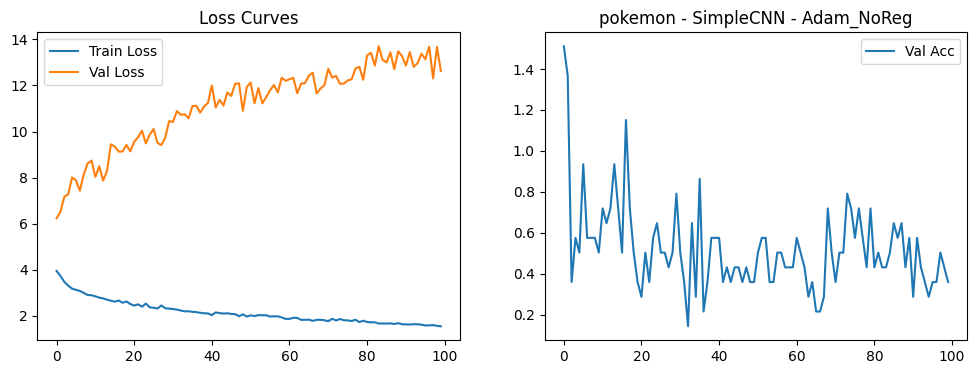


--- Model: SimpleCNN, Config: Adam_WD ---


  1%|          | 1/150 [00:07<18:51,  7.59s/it]

Epoch   1/150 | Train Loss: 3.7336 | Val Loss: 6.9201 | Val Acc: 0.65%


  1%|▏         | 2/150 [00:16<19:55,  8.08s/it]

Epoch   2/150 | Train Loss: 3.5347 | Val Loss: 7.1139 | Val Acc: 0.43%


  2%|▏         | 3/150 [00:24<19:58,  8.15s/it]

Epoch   3/150 | Train Loss: 3.2796 | Val Loss: 7.4478 | Val Acc: 0.79%


  3%|▎         | 4/150 [00:31<19:15,  7.92s/it]

Epoch   4/150 | Train Loss: 3.1090 | Val Loss: 7.3519 | Val Acc: 0.43%


  3%|▎         | 5/150 [00:40<19:39,  8.14s/it]

Epoch   5/150 | Train Loss: 2.9749 | Val Loss: 7.3896 | Val Acc: 1.08%


  4%|▍         | 6/150 [00:48<19:19,  8.05s/it]

Epoch   6/150 | Train Loss: 2.8878 | Val Loss: 7.6374 | Val Acc: 1.15%


  5%|▍         | 7/150 [00:56<19:00,  7.98s/it]

Epoch   7/150 | Train Loss: 2.7921 | Val Loss: 7.8843 | Val Acc: 0.50%


  5%|▌         | 8/150 [01:04<19:03,  8.05s/it]

Epoch   8/150 | Train Loss: 2.7127 | Val Loss: 8.5930 | Val Acc: 0.50%


  6%|▌         | 9/150 [01:11<18:19,  7.80s/it]

Epoch   9/150 | Train Loss: 2.6548 | Val Loss: 8.4082 | Val Acc: 0.65%


  7%|▋         | 10/150 [01:19<18:39,  7.99s/it]

Epoch  10/150 | Train Loss: 2.5409 | Val Loss: 8.5382 | Val Acc: 0.36%


  7%|▋         | 11/150 [01:28<18:44,  8.09s/it]

Epoch  11/150 | Train Loss: 2.4486 | Val Loss: 8.8468 | Val Acc: 0.50%


  8%|▊         | 12/150 [01:35<18:12,  7.92s/it]

Epoch  12/150 | Train Loss: 2.3820 | Val Loss: 8.7942 | Val Acc: 0.36%


  9%|▊         | 13/150 [01:44<18:25,  8.07s/it]

Epoch  13/150 | Train Loss: 2.2557 | Val Loss: 9.1494 | Val Acc: 0.65%


  9%|▉         | 14/150 [01:51<17:51,  7.88s/it]

Epoch  14/150 | Train Loss: 2.2099 | Val Loss: 9.1040 | Val Acc: 0.58%


 10%|█         | 15/150 [01:59<17:58,  7.99s/it]

Epoch  15/150 | Train Loss: 2.1840 | Val Loss: 9.4529 | Val Acc: 0.29%


 11%|█         | 16/150 [02:08<18:03,  8.09s/it]

Epoch  16/150 | Train Loss: 2.1561 | Val Loss: 9.4254 | Val Acc: 0.43%


 11%|█▏        | 17/150 [02:15<17:26,  7.87s/it]

Epoch  17/150 | Train Loss: 2.1372 | Val Loss: 9.5017 | Val Acc: 0.36%


 12%|█▏        | 18/150 [02:23<17:35,  7.99s/it]

Epoch  18/150 | Train Loss: 2.1567 | Val Loss: 9.5293 | Val Acc: 0.50%


 13%|█▎        | 19/150 [02:31<17:27,  8.00s/it]

Epoch  19/150 | Train Loss: 2.1363 | Val Loss: 9.6630 | Val Acc: 0.36%


 13%|█▎        | 20/150 [02:39<17:12,  7.94s/it]

Epoch  20/150 | Train Loss: 2.0967 | Val Loss: 9.5499 | Val Acc: 0.43%


 14%|█▍        | 21/150 [02:47<17:20,  8.06s/it]

Epoch  21/150 | Train Loss: 2.1204 | Val Loss: 9.3577 | Val Acc: 0.50%


 15%|█▍        | 22/150 [02:55<16:43,  7.84s/it]

Epoch  22/150 | Train Loss: 2.1305 | Val Loss: 9.5128 | Val Acc: 0.72%


 15%|█▌        | 23/150 [03:03<16:57,  8.01s/it]

Epoch  23/150 | Train Loss: 2.0957 | Val Loss: 9.5724 | Val Acc: 0.36%


 16%|█▌        | 24/150 [03:11<17:00,  8.10s/it]

Epoch  24/150 | Train Loss: 2.0880 | Val Loss: 9.6706 | Val Acc: 0.36%


 17%|█▋        | 25/150 [03:19<16:24,  7.87s/it]

Epoch  25/150 | Train Loss: 2.0549 | Val Loss: 9.5649 | Val Acc: 0.43%


 17%|█▋        | 26/150 [03:27<16:33,  8.01s/it]

Epoch  26/150 | Train Loss: 2.0830 | Val Loss: 9.5579 | Val Acc: 0.43%


 18%|█▊        | 27/150 [03:35<16:07,  7.86s/it]

Epoch  27/150 | Train Loss: 2.0654 | Val Loss: 9.4357 | Val Acc: 0.36%


 19%|█▊        | 28/150 [03:43<16:07,  7.93s/it]

Epoch  28/150 | Train Loss: 2.0605 | Val Loss: 9.6021 | Val Acc: 0.36%


 19%|█▉        | 29/150 [03:51<16:03,  7.96s/it]

Epoch  29/150 | Train Loss: 2.0774 | Val Loss: 9.7609 | Val Acc: 0.36%


 20%|██        | 30/150 [03:58<15:36,  7.80s/it]

Epoch  30/150 | Train Loss: 2.0726 | Val Loss: 9.6370 | Val Acc: 0.36%


 21%|██        | 31/150 [04:07<15:48,  7.97s/it]

Epoch  31/150 | Train Loss: 2.0541 | Val Loss: 9.6412 | Val Acc: 0.65%


 21%|██▏       | 32/150 [04:15<15:40,  7.97s/it]

Epoch  32/150 | Train Loss: 2.0450 | Val Loss: 9.5821 | Val Acc: 0.43%


 22%|██▏       | 33/150 [04:22<15:10,  7.78s/it]

Epoch  33/150 | Train Loss: 2.0566 | Val Loss: 9.6569 | Val Acc: 0.36%


 23%|██▎       | 34/150 [04:30<15:15,  7.89s/it]

Epoch  34/150 | Train Loss: 2.0608 | Val Loss: 9.7067 | Val Acc: 0.36%


 23%|██▎       | 35/150 [04:37<14:49,  7.74s/it]

Epoch  35/150 | Train Loss: 2.0465 | Val Loss: 9.6799 | Val Acc: 0.36%


 24%|██▍       | 36/150 [04:46<15:04,  7.94s/it]

Epoch  36/150 | Train Loss: 2.0454 | Val Loss: 9.6646 | Val Acc: 0.36%


 25%|██▍       | 37/150 [04:54<15:04,  8.01s/it]

Epoch  37/150 | Train Loss: 2.0724 | Val Loss: 9.7598 | Val Acc: 0.36%


 25%|██▌       | 38/150 [05:01<14:34,  7.81s/it]

Epoch  38/150 | Train Loss: 2.0615 | Val Loss: 9.8087 | Val Acc: 0.43%


 26%|██▌       | 39/150 [05:10<14:47,  7.99s/it]

Epoch  39/150 | Train Loss: 2.0573 | Val Loss: 9.7041 | Val Acc: 0.43%


 27%|██▋       | 40/150 [05:17<14:20,  7.82s/it]

Epoch  40/150 | Train Loss: 2.0509 | Val Loss: 9.7373 | Val Acc: 0.43%


 27%|██▋       | 41/150 [05:25<14:22,  7.92s/it]

Epoch  41/150 | Train Loss: 2.0465 | Val Loss: 9.6354 | Val Acc: 0.50%


 28%|██▊       | 42/150 [05:33<14:18,  7.95s/it]

Epoch  42/150 | Train Loss: 2.1034 | Val Loss: 9.6830 | Val Acc: 0.29%


 29%|██▊       | 43/150 [05:41<13:55,  7.80s/it]

Epoch  43/150 | Train Loss: 2.0192 | Val Loss: 9.7738 | Val Acc: 0.36%


 29%|██▉       | 44/150 [05:49<14:04,  7.96s/it]

Epoch  44/150 | Train Loss: 2.0711 | Val Loss: 9.7723 | Val Acc: 0.43%


 30%|███       | 45/150 [05:57<13:57,  7.98s/it]

Epoch  45/150 | Train Loss: 2.0360 | Val Loss: 9.7567 | Val Acc: 0.50%


 31%|███       | 46/150 [06:05<13:43,  7.92s/it]

Epoch  46/150 | Train Loss: 2.0363 | Val Loss: 9.6715 | Val Acc: 0.36%


 31%|███▏      | 47/150 [06:13<13:51,  8.07s/it]

Epoch  47/150 | Train Loss: 2.0336 | Val Loss: 9.6975 | Val Acc: 0.36%


 32%|███▏      | 48/150 [06:21<13:18,  7.83s/it]

Epoch  48/150 | Train Loss: 2.0468 | Val Loss: 9.5831 | Val Acc: 0.43%


 33%|███▎      | 49/150 [06:29<13:23,  7.95s/it]

Epoch  49/150 | Train Loss: 2.0441 | Val Loss: 9.6345 | Val Acc: 0.50%


 33%|███▎      | 50/150 [06:37<13:20,  8.01s/it]

Epoch  50/150 | Train Loss: 2.0309 | Val Loss: 9.7045 | Val Acc: 0.36%


 34%|███▍      | 51/150 [06:45<12:59,  7.87s/it]

Epoch  51/150 | Train Loss: 2.0545 | Val Loss: 9.6402 | Val Acc: 0.50%


 35%|███▍      | 52/150 [06:53<13:05,  8.02s/it]

Epoch  52/150 | Train Loss: 2.0671 | Val Loss: 9.7176 | Val Acc: 0.36%


 35%|███▌      | 53/150 [07:00<12:40,  7.84s/it]

Epoch  53/150 | Train Loss: 2.0379 | Val Loss: 9.7517 | Val Acc: 0.43%


 36%|███▌      | 54/150 [07:08<12:40,  7.92s/it]

Epoch  54/150 | Train Loss: 2.0687 | Val Loss: 9.6559 | Val Acc: 0.36%


 37%|███▋      | 55/150 [07:17<12:36,  7.96s/it]

Epoch  55/150 | Train Loss: 2.0585 | Val Loss: 9.5483 | Val Acc: 0.36%


 37%|███▋      | 56/150 [07:24<12:13,  7.80s/it]

Epoch  56/150 | Train Loss: 2.0490 | Val Loss: 9.6590 | Val Acc: 0.50%


 38%|███▊      | 57/150 [07:32<12:18,  7.94s/it]

Epoch  57/150 | Train Loss: 2.0211 | Val Loss: 9.7006 | Val Acc: 0.29%


 39%|███▊      | 58/150 [07:40<12:18,  8.02s/it]

Epoch  58/150 | Train Loss: 2.0498 | Val Loss: 9.7639 | Val Acc: 0.29%


 39%|███▉      | 59/150 [07:48<11:51,  7.82s/it]

Epoch  59/150 | Train Loss: 2.0752 | Val Loss: 9.6751 | Val Acc: 0.29%


 40%|████      | 60/150 [07:56<11:59,  7.99s/it]

Epoch  60/150 | Train Loss: 2.0738 | Val Loss: 9.7330 | Val Acc: 0.43%


 41%|████      | 61/150 [08:04<11:36,  7.82s/it]

Epoch  61/150 | Train Loss: 2.0589 | Val Loss: 9.8468 | Val Acc: 0.36%


 41%|████▏     | 62/150 [08:12<11:45,  8.02s/it]

Epoch  62/150 | Train Loss: 2.0406 | Val Loss: 9.7116 | Val Acc: 0.50%


 42%|████▏     | 63/150 [08:20<11:41,  8.06s/it]

Epoch  63/150 | Train Loss: 2.0293 | Val Loss: 9.6520 | Val Acc: 0.43%


 43%|████▎     | 64/150 [08:28<11:18,  7.88s/it]

Epoch  64/150 | Train Loss: 2.0316 | Val Loss: 9.7479 | Val Acc: 0.29%


 43%|████▎     | 65/150 [08:36<11:26,  8.07s/it]

Epoch  65/150 | Train Loss: 2.0251 | Val Loss: 9.7339 | Val Acc: 0.43%


 44%|████▍     | 66/150 [08:44<11:13,  8.02s/it]

Epoch  66/150 | Train Loss: 2.0591 | Val Loss: 9.7428 | Val Acc: 0.29%


 45%|████▍     | 67/150 [08:52<11:00,  7.96s/it]

Epoch  67/150 | Train Loss: 2.0563 | Val Loss: 9.6492 | Val Acc: 0.36%


 45%|████▌     | 68/150 [09:00<10:56,  8.01s/it]

Epoch  68/150 | Train Loss: 2.0474 | Val Loss: 9.6544 | Val Acc: 0.36%


 46%|████▌     | 69/150 [09:07<10:31,  7.79s/it]

Epoch  69/150 | Train Loss: 2.0164 | Val Loss: 9.6674 | Val Acc: 0.36%


 47%|████▋     | 70/150 [09:16<10:37,  7.97s/it]

Epoch  70/150 | Train Loss: 2.0493 | Val Loss: 9.4839 | Val Acc: 0.58%


 47%|████▋     | 71/150 [09:24<10:35,  8.05s/it]

Epoch  71/150 | Train Loss: 2.0402 | Val Loss: 9.6414 | Val Acc: 0.29%


 48%|████▊     | 72/150 [09:31<10:09,  7.82s/it]

Epoch  72/150 | Train Loss: 2.0530 | Val Loss: 9.5923 | Val Acc: 0.36%


 49%|████▊     | 73/150 [09:40<10:13,  7.97s/it]

Epoch  73/150 | Train Loss: 2.0535 | Val Loss: 9.8908 | Val Acc: 0.43%


 49%|████▉     | 74/150 [09:47<10:00,  7.90s/it]

Epoch  74/150 | Train Loss: 2.0458 | Val Loss: 9.6185 | Val Acc: 0.36%


 50%|█████     | 75/150 [09:55<09:54,  7.93s/it]

Epoch  75/150 | Train Loss: 2.0680 | Val Loss: 9.6228 | Val Acc: 0.29%


 51%|█████     | 76/150 [10:03<09:48,  7.95s/it]

Epoch  76/150 | Train Loss: 2.0863 | Val Loss: 9.6911 | Val Acc: 0.36%


 51%|█████▏    | 77/150 [10:11<09:28,  7.78s/it]

Epoch  77/150 | Train Loss: 2.0496 | Val Loss: 9.7359 | Val Acc: 0.36%


 52%|█████▏    | 78/150 [10:19<09:33,  7.96s/it]

Epoch  78/150 | Train Loss: 2.0241 | Val Loss: 9.7794 | Val Acc: 0.50%


 53%|█████▎    | 79/150 [10:27<09:22,  7.93s/it]

Epoch  79/150 | Train Loss: 2.0705 | Val Loss: 9.5820 | Val Acc: 0.43%


 53%|█████▎    | 80/150 [10:34<09:06,  7.81s/it]

Epoch  80/150 | Train Loss: 2.0516 | Val Loss: 9.7781 | Val Acc: 0.36%


 54%|█████▍    | 81/150 [10:43<09:11,  8.00s/it]

Epoch  81/150 | Train Loss: 2.0527 | Val Loss: 9.7330 | Val Acc: 0.43%


 55%|█████▍    | 82/150 [10:50<08:46,  7.74s/it]

Epoch  82/150 | Train Loss: 2.0316 | Val Loss: 9.7460 | Val Acc: 0.36%


 55%|█████▌    | 83/150 [10:58<08:46,  7.86s/it]

Epoch  83/150 | Train Loss: 2.0903 | Val Loss: 9.7228 | Val Acc: 0.43%


 56%|█████▌    | 84/150 [11:06<08:43,  7.93s/it]

Epoch  84/150 | Train Loss: 2.0773 | Val Loss: 9.5575 | Val Acc: 0.65%


 57%|█████▋    | 85/150 [11:14<08:24,  7.76s/it]

Epoch  85/150 | Train Loss: 2.0914 | Val Loss: 9.7304 | Val Acc: 0.43%


 57%|█████▋    | 86/150 [11:22<08:26,  7.91s/it]

Epoch  86/150 | Train Loss: 2.0792 | Val Loss: 9.7648 | Val Acc: 0.36%


 58%|█████▊    | 87/150 [11:29<08:08,  7.76s/it]

Epoch  87/150 | Train Loss: 2.0288 | Val Loss: 9.7010 | Val Acc: 0.29%


 59%|█████▊    | 88/150 [11:37<08:08,  7.88s/it]

Epoch  88/150 | Train Loss: 2.0401 | Val Loss: 9.7501 | Val Acc: 0.43%


 59%|█████▉    | 89/150 [11:46<08:08,  8.00s/it]

Epoch  89/150 | Train Loss: 2.0663 | Val Loss: 9.6614 | Val Acc: 0.36%


 60%|██████    | 90/150 [11:53<07:45,  7.76s/it]

Epoch  90/150 | Train Loss: 2.0733 | Val Loss: 9.6669 | Val Acc: 0.36%


 61%|██████    | 91/150 [12:01<07:48,  7.94s/it]

Epoch  91/150 | Train Loss: 2.0037 | Val Loss: 9.7181 | Val Acc: 0.50%


 61%|██████▏   | 92/150 [12:09<07:37,  7.89s/it]

Epoch  92/150 | Train Loss: 2.0660 | Val Loss: 9.7287 | Val Acc: 0.36%


 62%|██████▏   | 93/150 [12:17<07:32,  7.94s/it]

Epoch  93/150 | Train Loss: 2.0558 | Val Loss: 9.7380 | Val Acc: 0.29%


 63%|██████▎   | 94/150 [12:25<07:28,  8.01s/it]

Epoch  94/150 | Train Loss: 2.0881 | Val Loss: 9.5873 | Val Acc: 0.36%


 63%|██████▎   | 95/150 [12:33<07:08,  7.79s/it]

Epoch  95/150 | Train Loss: 2.0602 | Val Loss: 9.6738 | Val Acc: 0.36%


 64%|██████▍   | 96/150 [12:41<07:11,  7.99s/it]

Epoch  96/150 | Train Loss: 2.0544 | Val Loss: 9.7685 | Val Acc: 0.43%


 65%|██████▍   | 97/150 [12:49<07:07,  8.07s/it]

Epoch  97/150 | Train Loss: 2.0722 | Val Loss: 9.6652 | Val Acc: 0.43%


 65%|██████▌   | 98/150 [12:57<06:47,  7.83s/it]

Epoch  98/150 | Train Loss: 2.0513 | Val Loss: 9.6566 | Val Acc: 0.36%


 66%|██████▌   | 99/150 [13:05<06:47,  7.98s/it]

Epoch  99/150 | Train Loss: 2.0376 | Val Loss: 9.6853 | Val Acc: 0.50%


 67%|██████▋   | 100/150 [13:12<06:29,  7.80s/it]

Epoch 100/150 | Train Loss: 2.0602 | Val Loss: 9.6766 | Val Acc: 0.50%


 67%|██████▋   | 101/150 [13:21<06:32,  8.01s/it]

Epoch 101/150 | Train Loss: 2.0437 | Val Loss: 9.5703 | Val Acc: 0.36%


 68%|██████▊   | 102/150 [13:29<06:26,  8.05s/it]

Epoch 102/150 | Train Loss: 2.0826 | Val Loss: 9.7640 | Val Acc: 0.36%


 69%|██████▊   | 103/150 [13:36<06:08,  7.84s/it]

Epoch 103/150 | Train Loss: 2.0642 | Val Loss: 9.6877 | Val Acc: 0.58%


 69%|██████▉   | 104/150 [13:45<06:07,  7.99s/it]

Epoch 104/150 | Train Loss: 2.0913 | Val Loss: 9.5999 | Val Acc: 0.29%


 70%|███████   | 105/150 [13:53<06:00,  8.01s/it]

Epoch 105/150 | Train Loss: 2.0558 | Val Loss: 9.7014 | Val Acc: 0.36%


 71%|███████   | 106/150 [14:00<05:48,  7.92s/it]

Epoch 106/150 | Train Loss: 2.0587 | Val Loss: 9.6555 | Val Acc: 0.50%


 71%|███████▏  | 107/150 [14:09<05:45,  8.03s/it]

Epoch 107/150 | Train Loss: 2.0580 | Val Loss: 9.6014 | Val Acc: 0.29%


 72%|███████▏  | 108/150 [14:16<05:29,  7.84s/it]

Epoch 108/150 | Train Loss: 2.0529 | Val Loss: 9.7334 | Val Acc: 0.29%


 73%|███████▎  | 109/150 [14:25<05:30,  8.06s/it]

Epoch 109/150 | Train Loss: 2.0643 | Val Loss: 9.7436 | Val Acc: 0.36%


 73%|███████▎  | 110/150 [14:33<05:25,  8.13s/it]

Epoch 110/150 | Train Loss: 2.0492 | Val Loss: 9.7077 | Val Acc: 0.36%


 74%|███████▍  | 111/150 [14:40<05:08,  7.90s/it]

Epoch 111/150 | Train Loss: 2.0671 | Val Loss: 9.6391 | Val Acc: 0.36%


 75%|███████▍  | 112/150 [14:49<05:10,  8.16s/it]

Epoch 112/150 | Train Loss: 2.0303 | Val Loss: 9.8016 | Val Acc: 0.29%


 75%|███████▌  | 113/150 [14:57<04:58,  8.06s/it]

Epoch 113/150 | Train Loss: 2.0281 | Val Loss: 9.6738 | Val Acc: 0.36%


 76%|███████▌  | 114/150 [15:05<04:46,  7.96s/it]

Epoch 114/150 | Train Loss: 2.0870 | Val Loss: 9.7764 | Val Acc: 0.58%


 77%|███████▋  | 115/150 [15:13<04:40,  8.01s/it]

Epoch 115/150 | Train Loss: 2.0103 | Val Loss: 9.6471 | Val Acc: 0.29%


 77%|███████▋  | 116/150 [15:20<04:27,  7.86s/it]

Epoch 116/150 | Train Loss: 2.0752 | Val Loss: 9.6812 | Val Acc: 0.36%


 78%|███████▊  | 117/150 [15:29<04:24,  8.01s/it]

Epoch 117/150 | Train Loss: 2.0250 | Val Loss: 9.7203 | Val Acc: 0.29%


 79%|███████▊  | 118/150 [15:37<04:18,  8.07s/it]

Epoch 118/150 | Train Loss: 2.0198 | Val Loss: 9.7647 | Val Acc: 0.29%


 79%|███████▉  | 119/150 [15:44<04:03,  7.86s/it]

Epoch 119/150 | Train Loss: 2.0141 | Val Loss: 9.7574 | Val Acc: 0.43%


 80%|████████  | 120/150 [15:52<03:59,  7.98s/it]

Epoch 120/150 | Train Loss: 2.0517 | Val Loss: 9.7806 | Val Acc: 0.29%


 81%|████████  | 121/150 [16:00<03:45,  7.76s/it]

Epoch 121/150 | Train Loss: 2.0560 | Val Loss: 9.6913 | Val Acc: 0.43%


 81%|████████▏ | 122/150 [16:08<03:43,  7.97s/it]

Epoch 122/150 | Train Loss: 2.0529 | Val Loss: 9.6840 | Val Acc: 0.29%


 82%|████████▏ | 123/150 [16:16<03:37,  8.06s/it]

Epoch 123/150 | Train Loss: 2.0444 | Val Loss: 9.7804 | Val Acc: 0.36%


 83%|████████▎ | 124/150 [16:24<03:23,  7.83s/it]

Epoch 124/150 | Train Loss: 2.0415 | Val Loss: 9.6512 | Val Acc: 0.29%


 83%|████████▎ | 125/150 [16:32<03:20,  8.01s/it]

Epoch 125/150 | Train Loss: 2.0854 | Val Loss: 9.7348 | Val Acc: 0.36%


 84%|████████▍ | 126/150 [16:40<03:09,  7.91s/it]

Epoch 126/150 | Train Loss: 2.0715 | Val Loss: 9.7347 | Val Acc: 0.29%


 85%|████████▍ | 127/150 [16:48<03:02,  7.92s/it]

Epoch 127/150 | Train Loss: 2.0491 | Val Loss: 9.5946 | Val Acc: 0.50%


 85%|████████▌ | 128/150 [16:56<02:56,  8.02s/it]

Epoch 128/150 | Train Loss: 2.0673 | Val Loss: 9.6476 | Val Acc: 0.43%


 86%|████████▌ | 129/150 [17:03<02:43,  7.80s/it]

Epoch 129/150 | Train Loss: 2.0784 | Val Loss: 9.6880 | Val Acc: 0.36%


 87%|████████▋ | 130/150 [17:12<02:39,  7.96s/it]

Epoch 130/150 | Train Loss: 2.0630 | Val Loss: 9.7876 | Val Acc: 0.36%


 87%|████████▋ | 131/150 [17:20<02:31,  7.95s/it]

Epoch 131/150 | Train Loss: 2.0732 | Val Loss: 9.7101 | Val Acc: 0.36%


 88%|████████▊ | 132/150 [17:27<02:22,  7.89s/it]

Epoch 132/150 | Train Loss: 2.0475 | Val Loss: 9.6820 | Val Acc: 0.36%


 89%|████████▊ | 133/150 [17:36<02:15,  7.98s/it]

Epoch 133/150 | Train Loss: 2.0208 | Val Loss: 9.6404 | Val Acc: 0.36%


 89%|████████▉ | 134/150 [17:43<02:04,  7.81s/it]

Epoch 134/150 | Train Loss: 2.0522 | Val Loss: 9.6283 | Val Acc: 0.36%


 90%|█████████ | 135/150 [17:51<01:59,  7.99s/it]

Epoch 135/150 | Train Loss: 2.0596 | Val Loss: 9.6719 | Val Acc: 0.50%


 91%|█████████ | 136/150 [18:00<01:52,  8.05s/it]

Epoch 136/150 | Train Loss: 2.0308 | Val Loss: 9.8004 | Val Acc: 0.43%


 91%|█████████▏| 137/150 [18:07<01:41,  7.84s/it]

Epoch 137/150 | Train Loss: 2.0477 | Val Loss: 9.7656 | Val Acc: 0.50%


 92%|█████████▏| 138/150 [18:15<01:36,  8.05s/it]

Epoch 138/150 | Train Loss: 2.0548 | Val Loss: 9.7217 | Val Acc: 0.43%


 93%|█████████▎| 139/150 [18:23<01:27,  7.96s/it]

Epoch 139/150 | Train Loss: 2.0413 | Val Loss: 9.5643 | Val Acc: 0.50%


 93%|█████████▎| 140/150 [18:31<01:19,  7.98s/it]

Epoch 140/150 | Train Loss: 2.0618 | Val Loss: 9.7101 | Val Acc: 0.29%


 94%|█████████▍| 141/150 [18:39<01:12,  8.03s/it]

Epoch 141/150 | Train Loss: 2.0301 | Val Loss: 9.7506 | Val Acc: 0.36%


 95%|█████████▍| 142/150 [18:47<01:02,  7.81s/it]

Epoch 142/150 | Train Loss: 2.0763 | Val Loss: 9.6712 | Val Acc: 0.43%


 95%|█████████▌| 143/150 [18:55<00:56,  8.01s/it]

Epoch 143/150 | Train Loss: 2.0720 | Val Loss: 9.6690 | Val Acc: 0.43%


 96%|█████████▌| 144/150 [19:03<00:47,  7.98s/it]

Epoch 144/150 | Train Loss: 2.0508 | Val Loss: 9.6384 | Val Acc: 0.58%


 97%|█████████▋| 145/150 [19:11<00:39,  7.85s/it]

Epoch 145/150 | Train Loss: 2.0757 | Val Loss: 9.7602 | Val Acc: 0.65%


 97%|█████████▋| 146/150 [19:19<00:32,  8.02s/it]

Epoch 146/150 | Train Loss: 2.0482 | Val Loss: 9.7546 | Val Acc: 0.36%


 98%|█████████▊| 147/150 [19:26<00:23,  7.86s/it]

Epoch 147/150 | Train Loss: 2.0307 | Val Loss: 9.6056 | Val Acc: 0.50%


 99%|█████████▊| 148/150 [19:35<00:16,  8.03s/it]

Epoch 148/150 | Train Loss: 2.0669 | Val Loss: 9.7484 | Val Acc: 0.36%


 99%|█████████▉| 149/150 [19:43<00:08,  8.10s/it]

Epoch 149/150 | Train Loss: 2.0719 | Val Loss: 9.6186 | Val Acc: 0.50%


100%|██████████| 150/150 [19:50<00:00,  7.94s/it]

Epoch 150/150 | Train Loss: 2.0425 | Val Loss: 9.5222 | Val Acc: 0.50%


FINAL TEST ACCURACY: 2.05%



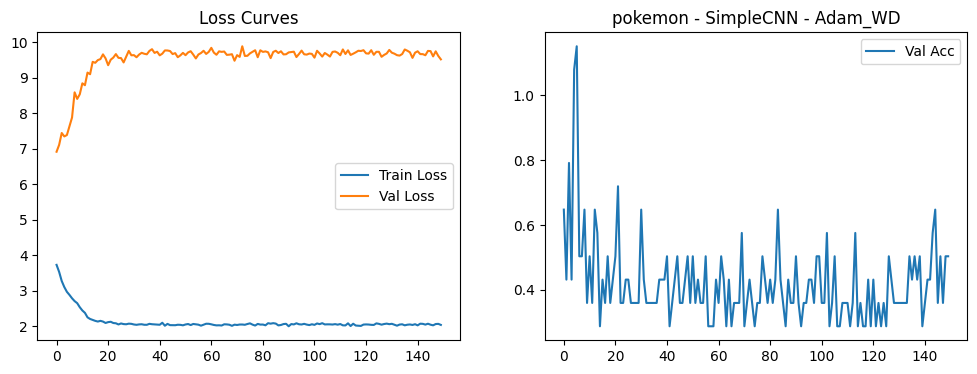


----- Training VGG11 -----

--- Model: VGG11, Config: SGD_StepDecay ---


  0%|          | 1/200 [00:08<26:49,  8.09s/it]

Epoch   1/200 | Train Loss: 4.5898 | Val Loss: 5.6507 | Val Acc: 0.00%


  1%|          | 2/200 [00:15<25:30,  7.73s/it]

Epoch   2/200 | Train Loss: 4.5850 | Val Loss: 5.9062 | Val Acc: 1.37%


  2%|▏         | 3/200 [00:22<24:48,  7.56s/it]

Epoch   3/200 | Train Loss: 4.7224 | Val Loss: 4.7410 | Val Acc: 0.00%


  2%|▏         | 4/200 [00:30<25:08,  7.69s/it]

Epoch   4/200 | Train Loss: 4.6111 | Val Loss: 4.7596 | Val Acc: 0.00%


  2%|▎         | 5/200 [00:37<24:01,  7.39s/it]

Epoch   5/200 | Train Loss: 4.5695 | Val Loss: 4.7289 | Val Acc: 0.07%


  3%|▎         | 6/200 [00:45<24:31,  7.59s/it]

Epoch   6/200 | Train Loss: 4.4988 | Val Loss: 4.7200 | Val Acc: 3.53%


  4%|▎         | 7/200 [00:52<23:35,  7.33s/it]

Epoch   7/200 | Train Loss: 4.4653 | Val Loss: 4.8182 | Val Acc: 0.00%


  4%|▍         | 8/200 [01:00<23:58,  7.49s/it]

Epoch   8/200 | Train Loss: 4.4590 | Val Loss: 4.7600 | Val Acc: 0.22%


  4%|▍         | 9/200 [01:08<24:11,  7.60s/it]

Epoch   9/200 | Train Loss: 4.3821 | Val Loss: 4.8520 | Val Acc: 0.50%


  5%|▌         | 10/200 [01:15<23:29,  7.42s/it]

Epoch  10/200 | Train Loss: 4.3155 | Val Loss: 4.9026 | Val Acc: 0.29%


  6%|▌         | 11/200 [01:22<23:46,  7.55s/it]

Epoch  11/200 | Train Loss: 4.3696 | Val Loss: 4.9087 | Val Acc: 3.17%


  6%|▌         | 12/200 [01:29<22:54,  7.31s/it]

Epoch  12/200 | Train Loss: 4.3908 | Val Loss: 4.8762 | Val Acc: 0.14%


  6%|▋         | 13/200 [01:37<23:24,  7.51s/it]

Epoch  13/200 | Train Loss: 4.3215 | Val Loss: 4.9411 | Val Acc: 0.07%


  7%|▋         | 14/200 [01:44<22:39,  7.31s/it]

Epoch  14/200 | Train Loss: 4.3086 | Val Loss: 4.9511 | Val Acc: 0.00%


  8%|▊         | 15/200 [01:52<23:00,  7.46s/it]

Epoch  15/200 | Train Loss: 4.2505 | Val Loss: 4.9654 | Val Acc: 0.00%


  8%|▊         | 16/200 [02:00<23:13,  7.57s/it]

Epoch  16/200 | Train Loss: 4.1852 | Val Loss: 5.0382 | Val Acc: 0.00%


  8%|▊         | 17/200 [02:07<22:30,  7.38s/it]

Epoch  17/200 | Train Loss: 4.1687 | Val Loss: 5.3270 | Val Acc: 0.22%


  9%|▉         | 18/200 [02:15<22:54,  7.55s/it]

Epoch  18/200 | Train Loss: 4.1691 | Val Loss: 5.1525 | Val Acc: 0.00%


 10%|▉         | 19/200 [02:21<22:09,  7.34s/it]

Epoch  19/200 | Train Loss: 4.0889 | Val Loss: 5.2980 | Val Acc: 0.14%


 10%|█         | 20/200 [02:29<22:32,  7.52s/it]

Epoch  20/200 | Train Loss: 4.1076 | Val Loss: 5.0346 | Val Acc: 0.22%


 10%|█         | 21/200 [02:37<22:15,  7.46s/it]

Epoch  21/200 | Train Loss: 4.0642 | Val Loss: 5.2252 | Val Acc: 0.14%


 11%|█         | 22/200 [02:44<22:11,  7.48s/it]

Epoch  22/200 | Train Loss: 4.0380 | Val Loss: 5.5000 | Val Acc: 0.29%


 12%|█▏        | 23/200 [02:52<22:27,  7.61s/it]

Epoch  23/200 | Train Loss: 4.0208 | Val Loss: 5.3413 | Val Acc: 0.36%


 12%|█▏        | 24/200 [02:59<21:37,  7.37s/it]

Epoch  24/200 | Train Loss: 4.0535 | Val Loss: 5.2926 | Val Acc: 0.50%


 12%|█▎        | 25/200 [03:07<22:06,  7.58s/it]

Epoch  25/200 | Train Loss: 3.9741 | Val Loss: 5.4041 | Val Acc: 0.29%


 13%|█▎        | 26/200 [03:14<21:27,  7.40s/it]

Epoch  26/200 | Train Loss: 3.9284 | Val Loss: 5.3853 | Val Acc: 1.29%


 14%|█▎        | 27/200 [03:22<21:50,  7.58s/it]

Epoch  27/200 | Train Loss: 3.9335 | Val Loss: 5.5722 | Val Acc: 1.22%


 14%|█▍        | 28/200 [03:29<21:28,  7.49s/it]

Epoch  28/200 | Train Loss: 3.9060 | Val Loss: 5.4973 | Val Acc: 1.37%


 14%|█▍        | 29/200 [03:37<21:32,  7.56s/it]

Epoch  29/200 | Train Loss: 3.8078 | Val Loss: 5.6960 | Val Acc: 3.53%


 15%|█▌        | 30/200 [03:45<21:42,  7.66s/it]

Epoch  30/200 | Train Loss: 3.7697 | Val Loss: 5.7591 | Val Acc: 0.07%


 16%|█▌        | 31/200 [03:52<20:57,  7.44s/it]

Epoch  31/200 | Train Loss: 3.7456 | Val Loss: 5.9781 | Val Acc: 0.07%


 16%|█▌        | 32/200 [04:00<21:14,  7.58s/it]

Epoch  32/200 | Train Loss: 3.6684 | Val Loss: 5.6283 | Val Acc: 2.01%


 16%|█▋        | 33/200 [04:07<20:37,  7.41s/it]

Epoch  33/200 | Train Loss: 3.6730 | Val Loss: 6.6287 | Val Acc: 0.86%


 17%|█▋        | 34/200 [04:15<20:58,  7.58s/it]

Epoch  34/200 | Train Loss: 3.9000 | Val Loss: 5.5997 | Val Acc: 2.37%


 18%|█▊        | 35/200 [04:23<21:04,  7.66s/it]

Epoch  35/200 | Train Loss: 3.6984 | Val Loss: 6.1601 | Val Acc: 0.14%


 18%|█▊        | 36/200 [04:30<20:22,  7.46s/it]

Epoch  36/200 | Train Loss: 3.5973 | Val Loss: 6.0641 | Val Acc: 0.00%


 18%|█▊        | 37/200 [04:37<20:37,  7.59s/it]

Epoch  37/200 | Train Loss: 3.5972 | Val Loss: 6.2316 | Val Acc: 0.14%


 19%|█▉        | 38/200 [04:44<19:48,  7.34s/it]

Epoch  38/200 | Train Loss: 3.5405 | Val Loss: 5.9869 | Val Acc: 0.43%


 20%|█▉        | 39/200 [04:52<20:14,  7.54s/it]

Epoch  39/200 | Train Loss: 3.5815 | Val Loss: 5.7976 | Val Acc: 1.73%


 20%|██        | 40/200 [04:59<19:32,  7.33s/it]

Epoch  40/200 | Train Loss: 3.4582 | Val Loss: 5.9800 | Val Acc: 0.94%


 20%|██        | 41/200 [05:07<20:02,  7.56s/it]

Epoch  41/200 | Train Loss: 3.4637 | Val Loss: 6.2194 | Val Acc: 0.22%


 21%|██        | 42/200 [05:15<20:02,  7.61s/it]

Epoch  42/200 | Train Loss: 3.5572 | Val Loss: 6.0763 | Val Acc: 0.22%


 22%|██▏       | 43/200 [05:22<19:24,  7.42s/it]

Epoch  43/200 | Train Loss: 3.4348 | Val Loss: 5.9875 | Val Acc: 0.79%


 22%|██▏       | 44/200 [05:30<19:39,  7.56s/it]

Epoch  44/200 | Train Loss: 3.4376 | Val Loss: 6.5973 | Val Acc: 0.22%


 22%|██▎       | 45/200 [05:37<19:10,  7.42s/it]

Epoch  45/200 | Train Loss: 3.3402 | Val Loss: 6.4937 | Val Acc: 0.29%


 23%|██▎       | 46/200 [05:45<19:34,  7.63s/it]

Epoch  46/200 | Train Loss: 3.2996 | Val Loss: 6.5062 | Val Acc: 0.79%


 24%|██▎       | 47/200 [05:52<19:18,  7.57s/it]

Epoch  47/200 | Train Loss: 3.5074 | Val Loss: 6.5558 | Val Acc: 0.22%


 24%|██▍       | 48/200 [06:00<19:10,  7.57s/it]

Epoch  48/200 | Train Loss: 3.3400 | Val Loss: 6.8336 | Val Acc: 0.43%


 24%|██▍       | 49/200 [06:08<19:20,  7.69s/it]

Epoch  49/200 | Train Loss: 3.2779 | Val Loss: 6.4789 | Val Acc: 1.29%


 25%|██▌       | 50/200 [06:15<18:41,  7.48s/it]

Epoch  50/200 | Train Loss: 3.5109 | Val Loss: 5.8958 | Val Acc: 0.14%


 26%|██▌       | 51/200 [06:23<18:50,  7.59s/it]

Epoch  51/200 | Train Loss: 3.5290 | Val Loss: 6.6101 | Val Acc: 0.14%


 26%|██▌       | 52/200 [06:30<18:08,  7.36s/it]

Epoch  52/200 | Train Loss: 3.3861 | Val Loss: 6.3035 | Val Acc: 1.51%


 26%|██▋       | 53/200 [06:38<18:32,  7.57s/it]

Epoch  53/200 | Train Loss: 3.2841 | Val Loss: 6.2023 | Val Acc: 1.29%


 27%|██▋       | 54/200 [06:45<18:27,  7.59s/it]

Epoch  54/200 | Train Loss: 3.3971 | Val Loss: 6.4630 | Val Acc: 0.14%


 28%|██▊       | 55/200 [06:52<18:00,  7.45s/it]

Epoch  55/200 | Train Loss: 3.3478 | Val Loss: 6.4804 | Val Acc: 1.08%


 28%|██▊       | 56/200 [07:00<18:09,  7.56s/it]

Epoch  56/200 | Train Loss: 3.3918 | Val Loss: 6.3368 | Val Acc: 0.00%


 28%|██▊       | 57/200 [07:07<17:30,  7.35s/it]

Epoch  57/200 | Train Loss: 3.3501 | Val Loss: 6.4456 | Val Acc: 0.72%


 29%|██▉       | 58/200 [07:15<17:48,  7.52s/it]

Epoch  58/200 | Train Loss: 3.2430 | Val Loss: 7.0198 | Val Acc: 0.43%


 30%|██▉       | 59/200 [07:22<17:11,  7.31s/it]

Epoch  59/200 | Train Loss: 3.2682 | Val Loss: 6.5651 | Val Acc: 0.50%


 30%|███       | 60/200 [07:30<17:29,  7.50s/it]

Epoch  60/200 | Train Loss: 3.1824 | Val Loss: 6.8796 | Val Acc: 0.43%


 30%|███       | 61/200 [07:38<17:39,  7.62s/it]

Epoch  61/200 | Train Loss: 3.2629 | Val Loss: 6.5169 | Val Acc: 0.72%


 31%|███       | 62/200 [07:45<17:02,  7.41s/it]

Epoch  62/200 | Train Loss: 3.2729 | Val Loss: 6.3605 | Val Acc: 1.73%


 32%|███▏      | 63/200 [07:53<17:16,  7.56s/it]

Epoch  63/200 | Train Loss: 3.2230 | Val Loss: 6.6158 | Val Acc: 0.29%


 32%|███▏      | 64/200 [07:59<16:40,  7.36s/it]

Epoch  64/200 | Train Loss: 3.2015 | Val Loss: 6.4456 | Val Acc: 1.44%


 32%|███▎      | 65/200 [08:07<16:59,  7.56s/it]

Epoch  65/200 | Train Loss: 3.1909 | Val Loss: 6.2445 | Val Acc: 0.14%


 33%|███▎      | 66/200 [08:15<16:53,  7.57s/it]

Epoch  66/200 | Train Loss: 3.2058 | Val Loss: 6.3831 | Val Acc: 1.58%


 34%|███▎      | 67/200 [08:22<16:44,  7.55s/it]

Epoch  67/200 | Train Loss: 3.0105 | Val Loss: 6.8001 | Val Acc: 0.50%


 34%|███▍      | 68/200 [08:30<16:46,  7.63s/it]

Epoch  68/200 | Train Loss: 2.8592 | Val Loss: 6.9134 | Val Acc: 0.72%


 34%|███▍      | 69/200 [08:37<16:07,  7.39s/it]

Epoch  69/200 | Train Loss: 2.7957 | Val Loss: 7.0305 | Val Acc: 0.72%


 35%|███▌      | 70/200 [08:45<16:29,  7.61s/it]

Epoch  70/200 | Train Loss: 2.7864 | Val Loss: 7.0843 | Val Acc: 1.29%


 36%|███▌      | 71/200 [08:52<15:57,  7.43s/it]

Epoch  71/200 | Train Loss: 2.7771 | Val Loss: 7.1416 | Val Acc: 1.01%


 36%|███▌      | 72/200 [09:00<15:59,  7.50s/it]

Epoch  72/200 | Train Loss: 2.7901 | Val Loss: 7.1264 | Val Acc: 0.50%


 36%|███▋      | 73/200 [09:08<16:02,  7.58s/it]

Epoch  73/200 | Train Loss: 2.7688 | Val Loss: 7.3303 | Val Acc: 0.72%


 37%|███▋      | 74/200 [09:15<15:34,  7.42s/it]

Epoch  74/200 | Train Loss: 2.7214 | Val Loss: 7.5108 | Val Acc: 0.86%


 38%|███▊      | 75/200 [09:23<15:46,  7.57s/it]

Epoch  75/200 | Train Loss: 2.7179 | Val Loss: 7.3303 | Val Acc: 0.50%


 38%|███▊      | 76/200 [09:29<15:10,  7.34s/it]

Epoch  76/200 | Train Loss: 2.7095 | Val Loss: 7.3412 | Val Acc: 1.01%


 38%|███▊      | 77/200 [09:37<15:25,  7.52s/it]

Epoch  77/200 | Train Loss: 2.7024 | Val Loss: 7.4194 | Val Acc: 0.94%


 39%|███▉      | 78/200 [09:45<15:22,  7.57s/it]

Epoch  78/200 | Train Loss: 2.6968 | Val Loss: 7.5110 | Val Acc: 0.94%


 40%|███▉      | 79/200 [09:53<15:10,  7.53s/it]

Epoch  79/200 | Train Loss: 2.6472 | Val Loss: 7.5266 | Val Acc: 1.08%


 40%|████      | 80/200 [10:00<15:13,  7.61s/it]

Epoch  80/200 | Train Loss: 2.6934 | Val Loss: 7.5779 | Val Acc: 0.72%


 40%|████      | 81/200 [10:07<14:43,  7.42s/it]

Epoch  81/200 | Train Loss: 2.6528 | Val Loss: 7.5816 | Val Acc: 1.22%


 41%|████      | 82/200 [10:16<15:03,  7.66s/it]

Epoch  82/200 | Train Loss: 2.6769 | Val Loss: 7.4531 | Val Acc: 0.86%


 42%|████▏     | 83/200 [10:22<14:27,  7.42s/it]

Epoch  83/200 | Train Loss: 2.6322 | Val Loss: 7.6384 | Val Acc: 0.58%


 42%|████▏     | 84/200 [10:30<14:36,  7.56s/it]

Epoch  84/200 | Train Loss: 2.6095 | Val Loss: 7.8584 | Val Acc: 0.29%


 42%|████▎     | 85/200 [10:38<14:38,  7.64s/it]

Epoch  85/200 | Train Loss: 2.5993 | Val Loss: 7.7729 | Val Acc: 0.58%


 43%|████▎     | 86/200 [10:45<14:14,  7.49s/it]

Epoch  86/200 | Train Loss: 2.5634 | Val Loss: 7.7969 | Val Acc: 0.65%


 44%|████▎     | 87/200 [10:53<14:20,  7.62s/it]

Epoch  87/200 | Train Loss: 2.5722 | Val Loss: 7.9261 | Val Acc: 0.65%


 44%|████▍     | 88/200 [11:00<13:44,  7.37s/it]

Epoch  88/200 | Train Loss: 2.5923 | Val Loss: 7.9445 | Val Acc: 0.29%


 44%|████▍     | 89/200 [11:08<13:54,  7.51s/it]

Epoch  89/200 | Train Loss: 2.5428 | Val Loss: 8.1379 | Val Acc: 0.36%


 45%|████▌     | 90/200 [11:15<13:42,  7.48s/it]

Epoch  90/200 | Train Loss: 2.5378 | Val Loss: 7.8871 | Val Acc: 0.58%


 46%|████▌     | 91/200 [11:22<13:27,  7.41s/it]

Epoch  91/200 | Train Loss: 2.5457 | Val Loss: 7.9539 | Val Acc: 0.72%


 46%|████▌     | 92/200 [11:30<13:32,  7.52s/it]

Epoch  92/200 | Train Loss: 2.5050 | Val Loss: 8.1306 | Val Acc: 0.65%


 46%|████▋     | 93/200 [11:37<13:01,  7.30s/it]

Epoch  93/200 | Train Loss: 2.5168 | Val Loss: 8.0414 | Val Acc: 0.72%


 47%|████▋     | 94/200 [11:45<13:18,  7.54s/it]

Epoch  94/200 | Train Loss: 2.5309 | Val Loss: 7.8980 | Val Acc: 0.79%


 48%|████▊     | 95/200 [11:52<12:52,  7.36s/it]

Epoch  95/200 | Train Loss: 2.4830 | Val Loss: 8.2752 | Val Acc: 0.22%


 48%|████▊     | 96/200 [12:00<13:01,  7.52s/it]

Epoch  96/200 | Train Loss: 2.4816 | Val Loss: 8.1488 | Val Acc: 0.72%


 48%|████▊     | 97/200 [12:07<12:52,  7.50s/it]

Epoch  97/200 | Train Loss: 2.4844 | Val Loss: 8.1267 | Val Acc: 0.58%


 49%|████▉     | 98/200 [12:14<12:31,  7.37s/it]

Epoch  98/200 | Train Loss: 2.4737 | Val Loss: 8.1176 | Val Acc: 0.65%


 50%|████▉     | 99/200 [12:22<12:35,  7.48s/it]

Epoch  99/200 | Train Loss: 2.4970 | Val Loss: 8.0905 | Val Acc: 0.43%


 50%|█████     | 100/200 [12:29<12:09,  7.29s/it]

Epoch 100/200 | Train Loss: 2.5341 | Val Loss: 8.1207 | Val Acc: 0.22%


 50%|█████     | 101/200 [12:37<12:17,  7.45s/it]

Epoch 101/200 | Train Loss: 2.4513 | Val Loss: 8.1783 | Val Acc: 0.72%


 51%|█████     | 102/200 [12:44<11:56,  7.31s/it]

Epoch 102/200 | Train Loss: 2.4817 | Val Loss: 7.7596 | Val Acc: 0.58%


 52%|█████▏    | 103/200 [12:52<12:06,  7.49s/it]

Epoch 103/200 | Train Loss: 2.4486 | Val Loss: 8.1354 | Val Acc: 0.29%


 52%|█████▏    | 104/200 [12:59<12:02,  7.52s/it]

Epoch 104/200 | Train Loss: 2.4247 | Val Loss: 8.1056 | Val Acc: 0.58%


 52%|█████▎    | 105/200 [13:06<11:38,  7.35s/it]

Epoch 105/200 | Train Loss: 2.4660 | Val Loss: 8.2072 | Val Acc: 0.79%


 53%|█████▎    | 106/200 [13:14<11:48,  7.53s/it]

Epoch 106/200 | Train Loss: 2.4181 | Val Loss: 8.1785 | Val Acc: 0.65%


 54%|█████▎    | 107/200 [13:21<11:23,  7.35s/it]

Epoch 107/200 | Train Loss: 2.4421 | Val Loss: 8.0241 | Val Acc: 0.72%


 54%|█████▍    | 108/200 [13:29<11:31,  7.52s/it]

Epoch 108/200 | Train Loss: 2.3987 | Val Loss: 8.2251 | Val Acc: 0.65%


 55%|█████▍    | 109/200 [13:36<11:03,  7.30s/it]

Epoch 109/200 | Train Loss: 2.4093 | Val Loss: 8.2440 | Val Acc: 0.94%


 55%|█████▌    | 110/200 [13:44<11:12,  7.48s/it]

Epoch 110/200 | Train Loss: 2.3684 | Val Loss: 8.4160 | Val Acc: 0.72%


 56%|█████▌    | 111/200 [13:52<11:19,  7.63s/it]

Epoch 111/200 | Train Loss: 2.3853 | Val Loss: 8.4499 | Val Acc: 0.58%


 56%|█████▌    | 112/200 [13:59<10:51,  7.40s/it]

Epoch 112/200 | Train Loss: 2.3998 | Val Loss: 8.4367 | Val Acc: 0.94%


 56%|█████▋    | 113/200 [14:06<10:55,  7.54s/it]

Epoch 113/200 | Train Loss: 2.3847 | Val Loss: 8.3789 | Val Acc: 0.58%


 57%|█████▋    | 114/200 [14:13<10:28,  7.31s/it]

Epoch 114/200 | Train Loss: 2.3611 | Val Loss: 8.2917 | Val Acc: 0.58%


 57%|█████▊    | 115/200 [14:21<10:41,  7.55s/it]

Epoch 115/200 | Train Loss: 2.3438 | Val Loss: 8.4396 | Val Acc: 0.43%


 58%|█████▊    | 116/200 [14:28<10:17,  7.35s/it]

Epoch 116/200 | Train Loss: 2.3078 | Val Loss: 8.7354 | Val Acc: 0.50%


 58%|█████▊    | 117/200 [14:36<10:20,  7.47s/it]

Epoch 117/200 | Train Loss: 2.3072 | Val Loss: 8.5135 | Val Acc: 0.50%


 59%|█████▉    | 118/200 [14:44<10:23,  7.60s/it]

Epoch 118/200 | Train Loss: 2.2935 | Val Loss: 8.5951 | Val Acc: 0.65%


 60%|█████▉    | 119/200 [14:51<09:59,  7.40s/it]

Epoch 119/200 | Train Loss: 2.2336 | Val Loss: 8.5346 | Val Acc: 0.79%


 60%|██████    | 120/200 [14:59<10:02,  7.54s/it]

Epoch 120/200 | Train Loss: 2.2881 | Val Loss: 8.4462 | Val Acc: 0.86%


 60%|██████    | 121/200 [15:05<09:36,  7.30s/it]

Epoch 121/200 | Train Loss: 2.3009 | Val Loss: 8.4816 | Val Acc: 0.58%


 61%|██████    | 122/200 [15:13<09:45,  7.50s/it]

Epoch 122/200 | Train Loss: 2.2730 | Val Loss: 8.6371 | Val Acc: 0.79%


 62%|██████▏   | 123/200 [15:21<09:33,  7.45s/it]

Epoch 123/200 | Train Loss: 2.2863 | Val Loss: 8.5791 | Val Acc: 0.94%


 62%|██████▏   | 124/200 [15:28<09:25,  7.44s/it]

Epoch 124/200 | Train Loss: 2.2855 | Val Loss: 8.5090 | Val Acc: 0.65%


 62%|██████▎   | 125/200 [15:36<09:24,  7.53s/it]

Epoch 125/200 | Train Loss: 2.2432 | Val Loss: 8.4920 | Val Acc: 0.94%


 63%|██████▎   | 126/200 [15:43<09:00,  7.30s/it]

Epoch 126/200 | Train Loss: 2.2831 | Val Loss: 8.5879 | Val Acc: 0.36%


 64%|██████▎   | 127/200 [15:51<09:08,  7.51s/it]

Epoch 127/200 | Train Loss: 2.2502 | Val Loss: 8.5381 | Val Acc: 0.58%


 64%|██████▍   | 128/200 [15:58<08:47,  7.33s/it]

Epoch 128/200 | Train Loss: 2.2177 | Val Loss: 8.7743 | Val Acc: 0.58%


 64%|██████▍   | 129/200 [16:05<08:50,  7.47s/it]

Epoch 129/200 | Train Loss: 2.2393 | Val Loss: 8.7294 | Val Acc: 0.94%


 65%|██████▌   | 130/200 [16:13<08:36,  7.37s/it]

Epoch 130/200 | Train Loss: 2.1741 | Val Loss: 8.5898 | Val Acc: 0.29%


 66%|██████▌   | 131/200 [16:20<08:34,  7.46s/it]

Epoch 131/200 | Train Loss: 2.2591 | Val Loss: 8.5001 | Val Acc: 0.72%


 66%|██████▌   | 132/200 [16:28<08:35,  7.57s/it]

Epoch 132/200 | Train Loss: 2.1781 | Val Loss: 8.5827 | Val Acc: 0.72%


 66%|██████▋   | 133/200 [16:35<08:12,  7.35s/it]

Epoch 133/200 | Train Loss: 2.1620 | Val Loss: 8.6914 | Val Acc: 0.50%


 67%|██████▋   | 134/200 [16:43<08:16,  7.52s/it]

Epoch 134/200 | Train Loss: 2.1393 | Val Loss: 8.7241 | Val Acc: 0.43%


 68%|██████▊   | 135/200 [16:50<07:53,  7.29s/it]

Epoch 135/200 | Train Loss: 2.1038 | Val Loss: 8.7482 | Val Acc: 0.58%


 68%|██████▊   | 136/200 [16:57<07:56,  7.44s/it]

Epoch 136/200 | Train Loss: 2.0673 | Val Loss: 8.8341 | Val Acc: 0.50%


 68%|██████▊   | 137/200 [17:05<07:44,  7.37s/it]

Epoch 137/200 | Train Loss: 2.0762 | Val Loss: 8.8389 | Val Acc: 0.50%


 69%|██████▉   | 138/200 [17:12<07:36,  7.37s/it]

Epoch 138/200 | Train Loss: 2.0586 | Val Loss: 8.8984 | Val Acc: 0.43%


 70%|██████▉   | 139/200 [17:20<07:39,  7.53s/it]

Epoch 139/200 | Train Loss: 2.0652 | Val Loss: 8.8589 | Val Acc: 0.50%


 70%|███████   | 140/200 [17:27<07:19,  7.32s/it]

Epoch 140/200 | Train Loss: 2.0710 | Val Loss: 8.8565 | Val Acc: 0.50%


 70%|███████   | 141/200 [17:34<07:21,  7.49s/it]

Epoch 141/200 | Train Loss: 2.0691 | Val Loss: 8.8867 | Val Acc: 0.58%


 71%|███████   | 142/200 [17:41<07:01,  7.27s/it]

Epoch 142/200 | Train Loss: 2.1250 | Val Loss: 8.9064 | Val Acc: 0.65%


 72%|███████▏  | 143/200 [17:49<07:08,  7.52s/it]

Epoch 143/200 | Train Loss: 2.0848 | Val Loss: 8.9243 | Val Acc: 0.50%


 72%|███████▏  | 144/200 [17:57<07:00,  7.50s/it]

Epoch 144/200 | Train Loss: 2.0909 | Val Loss: 8.8849 | Val Acc: 0.50%


 72%|███████▎  | 145/200 [18:04<06:47,  7.41s/it]

Epoch 145/200 | Train Loss: 2.0317 | Val Loss: 8.9550 | Val Acc: 0.43%


 73%|███████▎  | 146/200 [18:12<06:46,  7.52s/it]

Epoch 146/200 | Train Loss: 2.0714 | Val Loss: 9.0457 | Val Acc: 0.43%


 74%|███████▎  | 147/200 [18:19<06:27,  7.31s/it]

Epoch 147/200 | Train Loss: 2.0745 | Val Loss: 8.9532 | Val Acc: 0.58%


 74%|███████▍  | 148/200 [18:27<06:32,  7.54s/it]

Epoch 148/200 | Train Loss: 2.0829 | Val Loss: 8.9630 | Val Acc: 0.50%


 74%|███████▍  | 149/200 [18:33<06:12,  7.31s/it]

Epoch 149/200 | Train Loss: 2.0693 | Val Loss: 8.9806 | Val Acc: 0.50%


 75%|███████▌  | 150/200 [18:41<06:13,  7.48s/it]

Epoch 150/200 | Train Loss: 2.0461 | Val Loss: 8.9541 | Val Acc: 0.58%


 76%|███████▌  | 151/200 [18:49<06:07,  7.50s/it]

Epoch 151/200 | Train Loss: 2.0358 | Val Loss: 9.0587 | Val Acc: 0.58%


 76%|███████▌  | 152/200 [18:56<05:55,  7.41s/it]

Epoch 152/200 | Train Loss: 2.0519 | Val Loss: 9.0117 | Val Acc: 0.65%


 76%|███████▋  | 153/200 [19:04<05:54,  7.55s/it]

Epoch 153/200 | Train Loss: 2.0104 | Val Loss: 9.0313 | Val Acc: 0.58%


 77%|███████▋  | 154/200 [19:11<05:38,  7.36s/it]

Epoch 154/200 | Train Loss: 2.0220 | Val Loss: 9.0998 | Val Acc: 0.58%


 78%|███████▊  | 155/200 [19:19<05:38,  7.51s/it]

Epoch 155/200 | Train Loss: 2.0281 | Val Loss: 8.9150 | Val Acc: 0.58%


 78%|███████▊  | 156/200 [19:26<05:24,  7.37s/it]

Epoch 156/200 | Train Loss: 2.0306 | Val Loss: 9.0645 | Val Acc: 0.50%


 78%|███████▊  | 157/200 [19:34<05:22,  7.49s/it]

Epoch 157/200 | Train Loss: 2.0605 | Val Loss: 9.0792 | Val Acc: 0.50%


 79%|███████▉  | 158/200 [19:41<05:17,  7.57s/it]

Epoch 158/200 | Train Loss: 2.0295 | Val Loss: 9.0321 | Val Acc: 0.50%


 80%|███████▉  | 159/200 [19:48<05:01,  7.35s/it]

Epoch 159/200 | Train Loss: 1.9917 | Val Loss: 9.0999 | Val Acc: 0.50%


 80%|████████  | 160/200 [19:56<05:03,  7.58s/it]

Epoch 160/200 | Train Loss: 2.0154 | Val Loss: 9.0767 | Val Acc: 0.43%


 80%|████████  | 161/200 [20:03<04:47,  7.37s/it]

Epoch 161/200 | Train Loss: 2.0438 | Val Loss: 8.9760 | Val Acc: 0.43%


 81%|████████  | 162/200 [20:11<04:47,  7.56s/it]

Epoch 162/200 | Train Loss: 2.0244 | Val Loss: 9.0626 | Val Acc: 0.43%


 82%|████████▏ | 163/200 [20:18<04:35,  7.46s/it]

Epoch 163/200 | Train Loss: 2.0347 | Val Loss: 9.1364 | Val Acc: 0.50%


 82%|████████▏ | 164/200 [20:26<04:28,  7.47s/it]

Epoch 164/200 | Train Loss: 2.0103 | Val Loss: 9.1751 | Val Acc: 0.58%


 82%|████████▎ | 165/200 [20:34<04:24,  7.56s/it]

Epoch 165/200 | Train Loss: 2.0298 | Val Loss: 9.2648 | Val Acc: 0.50%


 83%|████████▎ | 166/200 [20:41<04:10,  7.36s/it]

Epoch 166/200 | Train Loss: 1.9885 | Val Loss: 9.1373 | Val Acc: 0.58%


 84%|████████▎ | 167/200 [20:48<04:08,  7.52s/it]

Epoch 167/200 | Train Loss: 1.9933 | Val Loss: 9.0701 | Val Acc: 0.58%


 84%|████████▍ | 168/200 [20:55<03:54,  7.33s/it]

Epoch 168/200 | Train Loss: 2.0100 | Val Loss: 9.2514 | Val Acc: 0.36%


 84%|████████▍ | 169/200 [21:03<03:52,  7.50s/it]

Epoch 169/200 | Train Loss: 1.9736 | Val Loss: 9.2234 | Val Acc: 0.58%


 85%|████████▌ | 170/200 [21:10<03:41,  7.39s/it]

Epoch 170/200 | Train Loss: 2.0091 | Val Loss: 9.1374 | Val Acc: 0.58%


 86%|████████▌ | 171/200 [21:18<03:35,  7.43s/it]

Epoch 171/200 | Train Loss: 2.0165 | Val Loss: 9.2299 | Val Acc: 0.58%


 86%|████████▌ | 172/200 [21:26<03:33,  7.62s/it]

Epoch 172/200 | Train Loss: 2.0177 | Val Loss: 9.1490 | Val Acc: 0.65%


 86%|████████▋ | 173/200 [21:33<03:19,  7.39s/it]

Epoch 173/200 | Train Loss: 1.9923 | Val Loss: 9.2037 | Val Acc: 0.58%


 87%|████████▋ | 174/200 [21:41<03:16,  7.56s/it]

Epoch 174/200 | Train Loss: 2.0006 | Val Loss: 9.1607 | Val Acc: 0.50%


 88%|████████▊ | 175/200 [21:48<03:02,  7.32s/it]

Epoch 175/200 | Train Loss: 2.0073 | Val Loss: 9.2150 | Val Acc: 0.58%


 88%|████████▊ | 176/200 [21:56<03:00,  7.53s/it]

Epoch 176/200 | Train Loss: 1.9979 | Val Loss: 9.0827 | Val Acc: 0.50%


 88%|████████▊ | 177/200 [22:03<02:53,  7.55s/it]

Epoch 177/200 | Train Loss: 1.9642 | Val Loss: 9.2206 | Val Acc: 0.58%


 89%|████████▉ | 178/200 [22:10<02:43,  7.41s/it]

Epoch 178/200 | Train Loss: 1.9757 | Val Loss: 9.3746 | Val Acc: 0.50%


 90%|████████▉ | 179/200 [22:18<02:38,  7.54s/it]

Epoch 179/200 | Train Loss: 1.9555 | Val Loss: 9.3324 | Val Acc: 0.72%


 90%|█████████ | 180/200 [22:25<02:28,  7.41s/it]

Epoch 180/200 | Train Loss: 1.9866 | Val Loss: 9.2088 | Val Acc: 0.86%


 90%|█████████ | 181/200 [22:33<02:23,  7.55s/it]

Epoch 181/200 | Train Loss: 1.9525 | Val Loss: 9.2268 | Val Acc: 0.50%


 91%|█████████ | 182/200 [22:40<02:12,  7.37s/it]

Epoch 182/200 | Train Loss: 1.9834 | Val Loss: 9.1926 | Val Acc: 0.50%


 92%|█████████▏| 183/200 [22:48<02:07,  7.50s/it]

Epoch 183/200 | Train Loss: 1.9933 | Val Loss: 9.2829 | Val Acc: 0.50%


 92%|█████████▏| 184/200 [22:56<02:01,  7.61s/it]

Epoch 184/200 | Train Loss: 1.9869 | Val Loss: 9.2398 | Val Acc: 0.58%


 92%|█████████▎| 185/200 [23:03<01:50,  7.39s/it]

Epoch 185/200 | Train Loss: 1.9571 | Val Loss: 9.3131 | Val Acc: 0.58%


 93%|█████████▎| 186/200 [23:10<01:45,  7.52s/it]

Epoch 186/200 | Train Loss: 1.9695 | Val Loss: 9.2797 | Val Acc: 0.58%


 94%|█████████▎| 187/200 [23:17<01:35,  7.31s/it]

Epoch 187/200 | Train Loss: 1.9688 | Val Loss: 9.2782 | Val Acc: 0.43%


 94%|█████████▍| 188/200 [23:25<01:29,  7.48s/it]

Epoch 188/200 | Train Loss: 1.9511 | Val Loss: 9.2159 | Val Acc: 0.50%


 94%|█████████▍| 189/200 [23:32<01:21,  7.39s/it]

Epoch 189/200 | Train Loss: 1.9996 | Val Loss: 9.3592 | Val Acc: 0.50%


 95%|█████████▌| 190/200 [23:40<01:14,  7.41s/it]

Epoch 190/200 | Train Loss: 1.9983 | Val Loss: 9.2581 | Val Acc: 0.72%


 96%|█████████▌| 191/200 [23:47<01:07,  7.51s/it]

Epoch 191/200 | Train Loss: 1.9870 | Val Loss: 9.3582 | Val Acc: 0.58%


 96%|█████████▌| 192/200 [23:54<00:58,  7.29s/it]

Epoch 192/200 | Train Loss: 1.9803 | Val Loss: 9.3560 | Val Acc: 0.50%


 96%|█████████▋| 193/200 [24:02<00:52,  7.51s/it]

Epoch 193/200 | Train Loss: 1.9871 | Val Loss: 9.2873 | Val Acc: 0.58%


 97%|█████████▋| 194/200 [24:09<00:43,  7.31s/it]

Epoch 194/200 | Train Loss: 1.9491 | Val Loss: 9.2201 | Val Acc: 0.58%


 98%|█████████▊| 195/200 [24:17<00:37,  7.48s/it]

Epoch 195/200 | Train Loss: 1.9614 | Val Loss: 9.4224 | Val Acc: 0.72%


 98%|█████████▊| 196/200 [24:24<00:29,  7.43s/it]

Epoch 196/200 | Train Loss: 1.9553 | Val Loss: 9.3439 | Val Acc: 0.65%


 98%|█████████▊| 197/200 [24:32<00:22,  7.42s/it]

Epoch 197/200 | Train Loss: 1.9459 | Val Loss: 9.2834 | Val Acc: 0.58%


 99%|█████████▉| 198/200 [24:39<00:15,  7.53s/it]

Epoch 198/200 | Train Loss: 1.9513 | Val Loss: 9.3567 | Val Acc: 0.58%


100%|█████████▉| 199/200 [24:46<00:07,  7.34s/it]

Epoch 199/200 | Train Loss: 1.9384 | Val Loss: 9.2703 | Val Acc: 0.50%


100%|██████████| 200/200 [24:54<00:00,  7.47s/it]

Epoch 200/200 | Train Loss: 1.9224 | Val Loss: 9.3830 | Val Acc: 0.50%


FINAL TEST ACCURACY: 0.00%



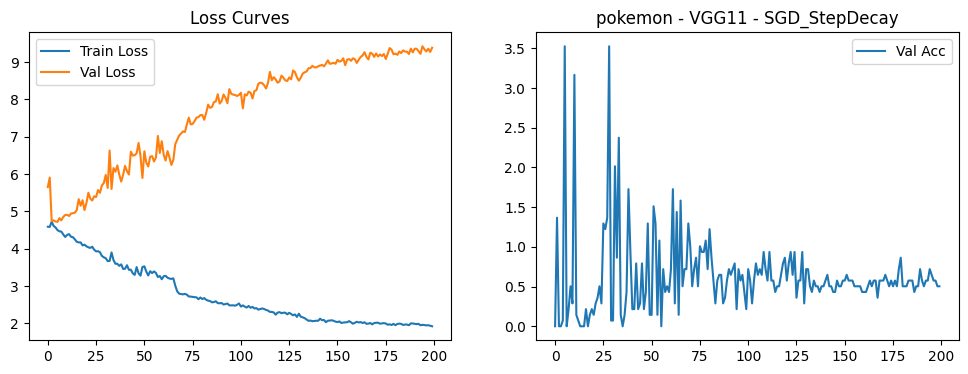


--- Model: VGG11, Config: SGD_Cosine ---


  0%|          | 1/200 [00:07<24:08,  7.28s/it]

Epoch   1/200 | Train Loss: 4.4230 | Val Loss: 4.9112 | Val Acc: 0.00%


  1%|          | 2/200 [00:14<24:25,  7.40s/it]

Epoch   2/200 | Train Loss: 4.4234 | Val Loss: 5.0242 | Val Acc: 0.00%


  2%|▏         | 3/200 [00:22<25:03,  7.63s/it]

Epoch   3/200 | Train Loss: 4.3597 | Val Loss: 4.9954 | Val Acc: 0.07%


  2%|▏         | 4/200 [00:29<24:12,  7.41s/it]

Epoch   4/200 | Train Loss: 4.3322 | Val Loss: 4.9793 | Val Acc: 0.58%


  2%|▎         | 5/200 [00:37<24:58,  7.68s/it]

Epoch   5/200 | Train Loss: 4.3305 | Val Loss: 4.9362 | Val Acc: 0.29%


  3%|▎         | 6/200 [00:44<23:50,  7.37s/it]

Epoch   6/200 | Train Loss: 4.2467 | Val Loss: 4.9663 | Val Acc: 0.00%


  4%|▎         | 7/200 [00:52<24:25,  7.60s/it]

Epoch   7/200 | Train Loss: 4.2208 | Val Loss: 5.0127 | Val Acc: 0.07%


  4%|▍         | 8/200 [01:00<24:43,  7.72s/it]

Epoch   8/200 | Train Loss: 4.2214 | Val Loss: 5.0796 | Val Acc: 0.14%


  4%|▍         | 9/200 [01:07<23:51,  7.50s/it]

Epoch   9/200 | Train Loss: 4.1996 | Val Loss: 4.9378 | Val Acc: 0.14%


  5%|▌         | 10/200 [01:15<24:22,  7.70s/it]

Epoch  10/200 | Train Loss: 4.1743 | Val Loss: 5.0376 | Val Acc: 4.10%


  6%|▌         | 11/200 [01:22<23:36,  7.50s/it]

Epoch  11/200 | Train Loss: 4.2180 | Val Loss: 4.9916 | Val Acc: 0.07%


  6%|▌         | 12/200 [01:31<24:09,  7.71s/it]

Epoch  12/200 | Train Loss: 4.1680 | Val Loss: 5.2377 | Val Acc: 0.29%


  6%|▋         | 13/200 [01:38<24:10,  7.76s/it]

Epoch  13/200 | Train Loss: 4.1329 | Val Loss: 5.0797 | Val Acc: 0.14%


  7%|▋         | 14/200 [01:46<23:37,  7.62s/it]

Epoch  14/200 | Train Loss: 4.1096 | Val Loss: 5.1305 | Val Acc: 1.08%


  8%|▊         | 15/200 [01:54<24:06,  7.82s/it]

Epoch  15/200 | Train Loss: 4.0471 | Val Loss: 5.3591 | Val Acc: 0.22%


  8%|▊         | 16/200 [02:01<23:06,  7.53s/it]

Epoch  16/200 | Train Loss: 3.9987 | Val Loss: 5.3090 | Val Acc: 0.14%


  8%|▊         | 17/200 [02:09<23:40,  7.76s/it]

Epoch  17/200 | Train Loss: 4.0284 | Val Loss: 5.5967 | Val Acc: 0.14%


  9%|▉         | 18/200 [02:16<23:00,  7.59s/it]

Epoch  18/200 | Train Loss: 3.9866 | Val Loss: 5.3892 | Val Acc: 0.07%


 10%|▉         | 19/200 [02:24<23:04,  7.65s/it]

Epoch  19/200 | Train Loss: 3.9945 | Val Loss: 5.2175 | Val Acc: 2.01%


 10%|█         | 20/200 [02:32<23:17,  7.76s/it]

Epoch  20/200 | Train Loss: 4.0142 | Val Loss: 5.2085 | Val Acc: 0.00%


 10%|█         | 21/200 [02:39<22:33,  7.56s/it]

Epoch  21/200 | Train Loss: 3.9256 | Val Loss: 5.3665 | Val Acc: 3.24%


 11%|█         | 22/200 [02:47<22:52,  7.71s/it]

Epoch  22/200 | Train Loss: 3.9917 | Val Loss: 5.3968 | Val Acc: 0.43%


 12%|█▏        | 23/200 [02:54<22:05,  7.49s/it]

Epoch  23/200 | Train Loss: 3.8321 | Val Loss: 5.4360 | Val Acc: 0.36%


 12%|█▏        | 24/200 [03:02<22:31,  7.68s/it]

Epoch  24/200 | Train Loss: 3.7915 | Val Loss: 5.6564 | Val Acc: 0.07%


 12%|█▎        | 25/200 [03:11<22:48,  7.82s/it]

Epoch  25/200 | Train Loss: 3.7396 | Val Loss: 5.8560 | Val Acc: 1.08%


 13%|█▎        | 26/200 [03:18<21:56,  7.57s/it]

Epoch  26/200 | Train Loss: 3.6990 | Val Loss: 6.3278 | Val Acc: 0.22%


 14%|█▎        | 27/200 [03:26<22:14,  7.71s/it]

Epoch  27/200 | Train Loss: 3.8327 | Val Loss: 5.8406 | Val Acc: 1.15%


 14%|█▍        | 28/200 [03:33<21:24,  7.47s/it]

Epoch  28/200 | Train Loss: 3.9043 | Val Loss: 5.6493 | Val Acc: 2.23%


 14%|█▍        | 29/200 [03:41<21:58,  7.71s/it]

Epoch  29/200 | Train Loss: 3.7133 | Val Loss: 6.0324 | Val Acc: 0.50%


 15%|█▌        | 30/200 [03:48<21:44,  7.67s/it]

Epoch  30/200 | Train Loss: 3.6204 | Val Loss: 5.8584 | Val Acc: 1.44%


 16%|█▌        | 31/200 [03:56<21:24,  7.60s/it]

Epoch  31/200 | Train Loss: 3.5800 | Val Loss: 6.0049 | Val Acc: 0.22%


 16%|█▌        | 32/200 [04:04<21:34,  7.71s/it]

Epoch  32/200 | Train Loss: 3.5247 | Val Loss: 6.1364 | Val Acc: 0.36%


 16%|█▋        | 33/200 [04:11<20:55,  7.52s/it]

Epoch  33/200 | Train Loss: 3.5337 | Val Loss: 6.4174 | Val Acc: 0.07%


 17%|█▋        | 34/200 [04:19<21:17,  7.69s/it]

Epoch  34/200 | Train Loss: 3.5646 | Val Loss: 6.0822 | Val Acc: 1.08%


 18%|█▊        | 35/200 [04:26<20:29,  7.45s/it]

Epoch  35/200 | Train Loss: 3.5745 | Val Loss: 6.0507 | Val Acc: 0.22%


 18%|█▊        | 36/200 [04:34<20:55,  7.66s/it]

Epoch  36/200 | Train Loss: 3.5389 | Val Loss: 6.3748 | Val Acc: 0.22%


 18%|█▊        | 37/200 [04:42<21:11,  7.80s/it]

Epoch  37/200 | Train Loss: 3.5673 | Val Loss: 6.2067 | Val Acc: 0.14%


 19%|█▉        | 38/200 [04:49<20:21,  7.54s/it]

Epoch  38/200 | Train Loss: 3.4575 | Val Loss: 6.3265 | Val Acc: 0.22%


 20%|█▉        | 39/200 [04:57<20:40,  7.71s/it]

Epoch  39/200 | Train Loss: 3.4194 | Val Loss: 6.5882 | Val Acc: 0.94%


 20%|██        | 40/200 [05:04<19:55,  7.47s/it]

Epoch  40/200 | Train Loss: 3.4067 | Val Loss: 6.7162 | Val Acc: 0.29%


 20%|██        | 41/200 [05:12<20:16,  7.65s/it]

Epoch  41/200 | Train Loss: 3.4923 | Val Loss: 6.2288 | Val Acc: 2.01%


 21%|██        | 42/200 [05:20<20:02,  7.61s/it]

Epoch  42/200 | Train Loss: 3.3749 | Val Loss: 6.3351 | Val Acc: 1.37%


 22%|██▏       | 43/200 [05:27<19:45,  7.55s/it]

Epoch  43/200 | Train Loss: 3.3416 | Val Loss: 6.2511 | Val Acc: 0.94%


 22%|██▏       | 44/200 [05:35<19:57,  7.68s/it]

Epoch  44/200 | Train Loss: 3.3809 | Val Loss: 6.4982 | Val Acc: 0.22%


 22%|██▎       | 45/200 [05:42<19:14,  7.45s/it]

Epoch  45/200 | Train Loss: 3.3042 | Val Loss: 6.6476 | Val Acc: 0.14%


 23%|██▎       | 46/200 [05:50<19:39,  7.66s/it]

Epoch  46/200 | Train Loss: 3.3151 | Val Loss: 6.6204 | Val Acc: 0.07%


 24%|██▎       | 47/200 [05:57<18:58,  7.44s/it]

Epoch  47/200 | Train Loss: 3.4090 | Val Loss: 6.1784 | Val Acc: 1.29%


 24%|██▍       | 48/200 [06:05<19:20,  7.64s/it]

Epoch  48/200 | Train Loss: 3.2079 | Val Loss: 6.7146 | Val Acc: 0.36%


 24%|██▍       | 49/200 [06:13<19:23,  7.71s/it]

Epoch  49/200 | Train Loss: 3.2265 | Val Loss: 6.7097 | Val Acc: 2.37%


 25%|██▌       | 50/200 [06:20<18:37,  7.45s/it]

Epoch  50/200 | Train Loss: 3.2893 | Val Loss: 6.3975 | Val Acc: 0.36%


 26%|██▌       | 51/200 [06:28<18:51,  7.59s/it]

Epoch  51/200 | Train Loss: 3.2319 | Val Loss: 6.2637 | Val Acc: 0.58%


 26%|██▌       | 52/200 [06:35<18:10,  7.37s/it]

Epoch  52/200 | Train Loss: 3.3630 | Val Loss: 6.3184 | Val Acc: 0.72%


 26%|██▋       | 53/200 [06:43<18:28,  7.54s/it]

Epoch  53/200 | Train Loss: 3.2575 | Val Loss: 6.5911 | Val Acc: 0.50%


 27%|██▋       | 54/200 [06:50<18:15,  7.50s/it]

Epoch  54/200 | Train Loss: 3.2320 | Val Loss: 6.4351 | Val Acc: 0.22%


 28%|██▊       | 55/200 [06:57<18:01,  7.46s/it]

Epoch  55/200 | Train Loss: 3.3457 | Val Loss: 6.4697 | Val Acc: 0.22%


 28%|██▊       | 56/200 [07:05<18:11,  7.58s/it]

Epoch  56/200 | Train Loss: 3.1522 | Val Loss: 6.4738 | Val Acc: 0.94%


 28%|██▊       | 57/200 [07:12<17:35,  7.38s/it]

Epoch  57/200 | Train Loss: 3.1436 | Val Loss: 6.5894 | Val Acc: 0.43%


 29%|██▉       | 58/200 [07:20<17:52,  7.55s/it]

Epoch  58/200 | Train Loss: 3.0764 | Val Loss: 6.7037 | Val Acc: 0.94%


 30%|██▉       | 59/200 [07:27<17:18,  7.36s/it]

Epoch  59/200 | Train Loss: 3.0934 | Val Loss: 6.6519 | Val Acc: 0.43%


 30%|███       | 60/200 [07:35<17:37,  7.55s/it]

Epoch  60/200 | Train Loss: 3.0735 | Val Loss: 6.7757 | Val Acc: 1.58%


 30%|███       | 61/200 [07:43<17:40,  7.63s/it]

Epoch  61/200 | Train Loss: 2.9614 | Val Loss: 6.4567 | Val Acc: 0.22%


 31%|███       | 62/200 [07:50<17:06,  7.44s/it]

Epoch  62/200 | Train Loss: 3.1096 | Val Loss: 6.7046 | Val Acc: 0.58%


 32%|███▏      | 63/200 [07:58<17:13,  7.54s/it]

Epoch  63/200 | Train Loss: 3.0854 | Val Loss: 6.7758 | Val Acc: 0.29%


 32%|███▏      | 64/200 [08:04<16:39,  7.35s/it]

Epoch  64/200 | Train Loss: 2.9761 | Val Loss: 6.8874 | Val Acc: 0.50%


 32%|███▎      | 65/200 [08:13<17:03,  7.58s/it]

Epoch  65/200 | Train Loss: 3.0205 | Val Loss: 7.0236 | Val Acc: 0.29%


 33%|███▎      | 66/200 [08:20<16:32,  7.41s/it]

Epoch  66/200 | Train Loss: 2.9093 | Val Loss: 7.1576 | Val Acc: 1.01%


 34%|███▎      | 67/200 [08:27<16:38,  7.51s/it]

Epoch  67/200 | Train Loss: 2.8250 | Val Loss: 6.8372 | Val Acc: 0.43%


 34%|███▍      | 68/200 [08:35<16:44,  7.61s/it]

Epoch  68/200 | Train Loss: 3.2812 | Val Loss: 7.0744 | Val Acc: 0.07%


 34%|███▍      | 69/200 [08:42<16:20,  7.49s/it]

Epoch  69/200 | Train Loss: 3.0550 | Val Loss: 6.8378 | Val Acc: 0.94%


 35%|███▌      | 70/200 [08:50<16:33,  7.64s/it]

Epoch  70/200 | Train Loss: 2.9604 | Val Loss: 6.9562 | Val Acc: 0.58%


 36%|███▌      | 71/200 [08:57<15:56,  7.41s/it]

Epoch  71/200 | Train Loss: 2.8761 | Val Loss: 7.1002 | Val Acc: 1.15%


 36%|███▌      | 72/200 [09:05<16:11,  7.59s/it]

Epoch  72/200 | Train Loss: 2.8911 | Val Loss: 7.0388 | Val Acc: 0.58%


 36%|███▋      | 73/200 [09:13<16:14,  7.68s/it]

Epoch  73/200 | Train Loss: 2.8695 | Val Loss: 6.8953 | Val Acc: 0.43%


 37%|███▋      | 74/200 [09:20<15:46,  7.51s/it]

Epoch  74/200 | Train Loss: 2.8702 | Val Loss: 7.6091 | Val Acc: 0.14%


 38%|███▊      | 75/200 [09:28<15:55,  7.65s/it]

Epoch  75/200 | Train Loss: 2.8427 | Val Loss: 7.1681 | Val Acc: 0.58%


 38%|███▊      | 76/200 [09:35<15:19,  7.42s/it]

Epoch  76/200 | Train Loss: 2.8095 | Val Loss: 7.2331 | Val Acc: 0.29%


 38%|███▊      | 77/200 [09:43<15:37,  7.62s/it]

Epoch  77/200 | Train Loss: 2.7388 | Val Loss: 7.2320 | Val Acc: 0.29%


 39%|███▉      | 78/200 [09:50<15:05,  7.42s/it]

Epoch  78/200 | Train Loss: 2.7091 | Val Loss: 7.3670 | Val Acc: 0.14%


 40%|███▉      | 79/200 [09:58<15:12,  7.54s/it]

Epoch  79/200 | Train Loss: 2.7323 | Val Loss: 7.3130 | Val Acc: 0.29%


 40%|████      | 80/200 [10:06<15:17,  7.65s/it]

Epoch  80/200 | Train Loss: 2.7340 | Val Loss: 6.8781 | Val Acc: 0.29%


 40%|████      | 81/200 [10:13<14:43,  7.42s/it]

Epoch  81/200 | Train Loss: 2.9320 | Val Loss: 7.1641 | Val Acc: 0.50%


 41%|████      | 82/200 [10:21<15:08,  7.70s/it]

Epoch  82/200 | Train Loss: 2.7597 | Val Loss: 7.8066 | Val Acc: 0.29%


 42%|████▏     | 83/200 [10:28<14:32,  7.46s/it]

Epoch  83/200 | Train Loss: 2.8841 | Val Loss: 7.1053 | Val Acc: 0.50%


 42%|████▏     | 84/200 [10:36<14:43,  7.62s/it]

Epoch  84/200 | Train Loss: 2.7915 | Val Loss: 7.3012 | Val Acc: 0.22%


 42%|████▎     | 85/200 [10:44<14:35,  7.61s/it]

Epoch  85/200 | Train Loss: 2.7632 | Val Loss: 7.0034 | Val Acc: 0.50%


 43%|████▎     | 86/200 [10:51<14:21,  7.56s/it]

Epoch  86/200 | Train Loss: 2.7007 | Val Loss: 7.7919 | Val Acc: 1.37%


 44%|████▎     | 87/200 [10:59<14:31,  7.71s/it]

Epoch  87/200 | Train Loss: 2.6802 | Val Loss: 7.0326 | Val Acc: 1.01%


 44%|████▍     | 88/200 [11:06<14:02,  7.52s/it]

Epoch  88/200 | Train Loss: 2.6003 | Val Loss: 7.4145 | Val Acc: 0.94%


 44%|████▍     | 89/200 [11:14<14:17,  7.73s/it]

Epoch  89/200 | Train Loss: 2.5598 | Val Loss: 7.6295 | Val Acc: 0.50%


 45%|████▌     | 90/200 [11:22<14:09,  7.73s/it]

Epoch  90/200 | Train Loss: 2.6004 | Val Loss: 7.5082 | Val Acc: 0.79%


 46%|████▌     | 91/200 [11:30<13:51,  7.63s/it]

Epoch  91/200 | Train Loss: 2.5680 | Val Loss: 7.2687 | Val Acc: 0.65%


 46%|████▌     | 92/200 [11:38<13:57,  7.76s/it]

Epoch  92/200 | Train Loss: 2.6372 | Val Loss: 7.7275 | Val Acc: 0.36%


 46%|████▋     | 93/200 [11:44<13:17,  7.45s/it]

Epoch  93/200 | Train Loss: 2.6300 | Val Loss: 7.4364 | Val Acc: 1.44%


 47%|████▋     | 94/200 [11:53<13:37,  7.71s/it]

Epoch  94/200 | Train Loss: 2.4390 | Val Loss: 7.5489 | Val Acc: 0.29%


 48%|████▊     | 95/200 [12:00<13:10,  7.53s/it]

Epoch  95/200 | Train Loss: 2.6007 | Val Loss: 7.8733 | Val Acc: 0.86%


 48%|████▊     | 96/200 [12:08<13:10,  7.60s/it]

Epoch  96/200 | Train Loss: 2.5724 | Val Loss: 7.3259 | Val Acc: 0.29%


 48%|████▊     | 97/200 [12:15<13:11,  7.69s/it]

Epoch  97/200 | Train Loss: 2.4480 | Val Loss: 7.7336 | Val Acc: 0.22%


 49%|████▉     | 98/200 [12:23<12:47,  7.52s/it]

Epoch  98/200 | Train Loss: 2.4285 | Val Loss: 7.5322 | Val Acc: 0.29%


 50%|████▉     | 99/200 [12:30<12:50,  7.63s/it]

Epoch  99/200 | Train Loss: 2.5102 | Val Loss: 8.0777 | Val Acc: 0.29%


 50%|█████     | 100/200 [12:37<12:19,  7.40s/it]

Epoch 100/200 | Train Loss: 2.4006 | Val Loss: 7.6166 | Val Acc: 0.65%


 50%|█████     | 101/200 [12:45<12:30,  7.58s/it]

Epoch 101/200 | Train Loss: 2.3323 | Val Loss: 7.6331 | Val Acc: 0.65%


 51%|█████     | 102/200 [12:53<12:38,  7.74s/it]

Epoch 102/200 | Train Loss: 2.3669 | Val Loss: 7.9222 | Val Acc: 0.36%


 52%|█████▏    | 103/200 [13:00<12:09,  7.52s/it]

Epoch 103/200 | Train Loss: 2.3348 | Val Loss: 8.0293 | Val Acc: 2.09%


 52%|█████▏    | 104/200 [13:08<12:15,  7.66s/it]

Epoch 104/200 | Train Loss: 2.3990 | Val Loss: 7.3605 | Val Acc: 0.58%


 52%|█████▎    | 105/200 [13:15<11:47,  7.45s/it]

Epoch 105/200 | Train Loss: 2.4174 | Val Loss: 7.4547 | Val Acc: 1.15%


 53%|█████▎    | 106/200 [13:23<11:58,  7.64s/it]

Epoch 106/200 | Train Loss: 2.3135 | Val Loss: 8.0895 | Val Acc: 0.94%


 54%|█████▎    | 107/200 [13:31<11:40,  7.53s/it]

Epoch 107/200 | Train Loss: 2.2308 | Val Loss: 8.0872 | Val Acc: 0.36%


 54%|█████▍    | 108/200 [13:38<11:32,  7.53s/it]

Epoch 108/200 | Train Loss: 2.1376 | Val Loss: 8.2232 | Val Acc: 0.79%


 55%|█████▍    | 109/200 [13:46<11:33,  7.62s/it]

Epoch 109/200 | Train Loss: 2.2003 | Val Loss: 7.9409 | Val Acc: 1.44%


 55%|█████▌    | 110/200 [13:53<11:09,  7.44s/it]

Epoch 110/200 | Train Loss: 2.3171 | Val Loss: 7.6722 | Val Acc: 0.94%


 56%|█████▌    | 111/200 [14:01<11:17,  7.61s/it]

Epoch 111/200 | Train Loss: 2.2370 | Val Loss: 8.3158 | Val Acc: 0.29%


 56%|█████▌    | 112/200 [14:08<10:55,  7.45s/it]

Epoch 112/200 | Train Loss: 2.2524 | Val Loss: 8.2577 | Val Acc: 1.22%


 56%|█████▋    | 113/200 [14:16<11:06,  7.66s/it]

Epoch 113/200 | Train Loss: 2.2879 | Val Loss: 8.1105 | Val Acc: 0.29%


 57%|█████▋    | 114/200 [14:24<11:08,  7.77s/it]

Epoch 114/200 | Train Loss: 2.2348 | Val Loss: 7.9186 | Val Acc: 0.65%


 57%|█████▊    | 115/200 [14:31<10:39,  7.53s/it]

Epoch 115/200 | Train Loss: 2.3381 | Val Loss: 7.5152 | Val Acc: 0.43%


 58%|█████▊    | 116/200 [14:39<10:47,  7.70s/it]

Epoch 116/200 | Train Loss: 2.3511 | Val Loss: 8.3484 | Val Acc: 0.58%


 58%|█████▊    | 117/200 [14:46<10:20,  7.47s/it]

Epoch 117/200 | Train Loss: 2.2217 | Val Loss: 7.9653 | Val Acc: 0.72%


 59%|█████▉    | 118/200 [14:55<10:33,  7.72s/it]

Epoch 118/200 | Train Loss: 2.2531 | Val Loss: 7.9827 | Val Acc: 0.43%


 60%|█████▉    | 119/200 [15:03<10:30,  7.78s/it]

Epoch 119/200 | Train Loss: 2.2018 | Val Loss: 7.8965 | Val Acc: 0.86%


 60%|██████    | 120/200 [15:10<10:04,  7.56s/it]

Epoch 120/200 | Train Loss: 2.0529 | Val Loss: 8.3895 | Val Acc: 0.43%


 60%|██████    | 121/200 [15:18<10:09,  7.71s/it]

Epoch 121/200 | Train Loss: 2.0357 | Val Loss: 8.7826 | Val Acc: 0.50%


 61%|██████    | 122/200 [15:25<09:45,  7.51s/it]

Epoch 122/200 | Train Loss: 2.0163 | Val Loss: 8.0344 | Val Acc: 0.58%


 62%|██████▏   | 123/200 [15:33<09:48,  7.65s/it]

Epoch 123/200 | Train Loss: 1.9850 | Val Loss: 8.3455 | Val Acc: 0.65%


 62%|██████▏   | 124/200 [15:40<09:28,  7.48s/it]

Epoch 124/200 | Train Loss: 1.9774 | Val Loss: 8.8353 | Val Acc: 0.50%


 62%|██████▎   | 125/200 [15:47<09:26,  7.55s/it]

Epoch 125/200 | Train Loss: 1.9815 | Val Loss: 8.5743 | Val Acc: 0.36%


 63%|██████▎   | 126/200 [15:56<09:29,  7.70s/it]

Epoch 126/200 | Train Loss: 1.9204 | Val Loss: 8.4430 | Val Acc: 0.58%


 64%|██████▎   | 127/200 [16:02<09:04,  7.46s/it]

Epoch 127/200 | Train Loss: 1.9445 | Val Loss: 8.5546 | Val Acc: 1.08%


 64%|██████▍   | 128/200 [16:11<09:11,  7.65s/it]

Epoch 128/200 | Train Loss: 1.8775 | Val Loss: 8.3174 | Val Acc: 1.29%


 64%|██████▍   | 129/200 [16:18<08:49,  7.46s/it]

Epoch 129/200 | Train Loss: 1.8228 | Val Loss: 8.6125 | Val Acc: 1.01%


 65%|██████▌   | 130/200 [16:26<09:01,  7.74s/it]

Epoch 130/200 | Train Loss: 1.7883 | Val Loss: 8.6536 | Val Acc: 0.86%


 66%|██████▌   | 131/200 [16:34<08:52,  7.72s/it]

Epoch 131/200 | Train Loss: 1.8903 | Val Loss: 9.0555 | Val Acc: 0.65%


 66%|██████▌   | 132/200 [16:41<08:35,  7.59s/it]

Epoch 132/200 | Train Loss: 1.8119 | Val Loss: 8.7359 | Val Acc: 0.79%


 66%|██████▋   | 133/200 [16:49<08:35,  7.69s/it]

Epoch 133/200 | Train Loss: 1.7925 | Val Loss: 8.9237 | Val Acc: 1.22%


 67%|██████▋   | 134/200 [16:56<08:16,  7.52s/it]

Epoch 134/200 | Train Loss: 1.8118 | Val Loss: 9.1203 | Val Acc: 0.86%


 68%|██████▊   | 135/200 [17:04<08:18,  7.66s/it]

Epoch 135/200 | Train Loss: 1.7913 | Val Loss: 8.9320 | Val Acc: 1.08%


 68%|██████▊   | 136/200 [17:11<07:58,  7.47s/it]

Epoch 136/200 | Train Loss: 1.7567 | Val Loss: 9.0434 | Val Acc: 0.79%


 68%|██████▊   | 137/200 [17:19<07:57,  7.58s/it]

Epoch 137/200 | Train Loss: 1.7248 | Val Loss: 9.0401 | Val Acc: 0.94%


 69%|██████▉   | 138/200 [17:27<07:58,  7.72s/it]

Epoch 138/200 | Train Loss: 1.7381 | Val Loss: 9.2646 | Val Acc: 0.65%


 70%|██████▉   | 139/200 [17:34<07:35,  7.46s/it]

Epoch 139/200 | Train Loss: 1.7050 | Val Loss: 8.8166 | Val Acc: 0.65%


 70%|███████   | 140/200 [17:42<07:37,  7.63s/it]

Epoch 140/200 | Train Loss: 1.7564 | Val Loss: 8.9557 | Val Acc: 0.79%


 70%|███████   | 141/200 [17:49<07:18,  7.43s/it]

Epoch 141/200 | Train Loss: 1.6675 | Val Loss: 8.7511 | Val Acc: 0.43%


 71%|███████   | 142/200 [17:57<07:23,  7.65s/it]

Epoch 142/200 | Train Loss: 1.6832 | Val Loss: 9.1965 | Val Acc: 0.86%


 72%|███████▏  | 143/200 [18:04<07:14,  7.63s/it]

Epoch 143/200 | Train Loss: 1.6897 | Val Loss: 9.1505 | Val Acc: 0.79%


 72%|███████▏  | 144/200 [18:12<06:59,  7.50s/it]

Epoch 144/200 | Train Loss: 1.6346 | Val Loss: 9.0597 | Val Acc: 0.72%


 72%|███████▎  | 145/200 [18:20<07:01,  7.66s/it]

Epoch 145/200 | Train Loss: 1.5920 | Val Loss: 9.3028 | Val Acc: 0.65%


 73%|███████▎  | 146/200 [18:27<06:44,  7.50s/it]

Epoch 146/200 | Train Loss: 1.5441 | Val Loss: 9.7749 | Val Acc: 0.43%


 74%|███████▎  | 147/200 [18:35<06:45,  7.64s/it]

Epoch 147/200 | Train Loss: 1.5112 | Val Loss: 9.2831 | Val Acc: 0.72%


 74%|███████▍  | 148/200 [18:42<06:33,  7.57s/it]

Epoch 148/200 | Train Loss: 1.5210 | Val Loss: 9.5549 | Val Acc: 1.01%


 74%|███████▍  | 149/200 [18:50<06:27,  7.60s/it]

Epoch 149/200 | Train Loss: 1.5334 | Val Loss: 9.2156 | Val Acc: 0.72%


 75%|███████▌  | 150/200 [18:58<06:29,  7.78s/it]

Epoch 150/200 | Train Loss: 1.5610 | Val Loss: 9.5608 | Val Acc: 0.65%


 76%|███████▌  | 151/200 [19:05<06:10,  7.56s/it]

Epoch 151/200 | Train Loss: 1.5177 | Val Loss: 9.3927 | Val Acc: 0.86%


 76%|███████▌  | 152/200 [19:13<06:10,  7.72s/it]

Epoch 152/200 | Train Loss: 1.4540 | Val Loss: 9.8950 | Val Acc: 0.94%


 76%|███████▋  | 153/200 [19:20<05:53,  7.51s/it]

Epoch 153/200 | Train Loss: 1.4806 | Val Loss: 9.2727 | Val Acc: 0.65%


 77%|███████▋  | 154/200 [19:28<05:55,  7.73s/it]

Epoch 154/200 | Train Loss: 1.5189 | Val Loss: 9.6813 | Val Acc: 0.86%


 78%|███████▊  | 155/200 [19:37<05:52,  7.84s/it]

Epoch 155/200 | Train Loss: 1.4899 | Val Loss: 9.4923 | Val Acc: 1.08%


 78%|███████▊  | 156/200 [19:44<05:34,  7.61s/it]

Epoch 156/200 | Train Loss: 1.4298 | Val Loss: 9.4322 | Val Acc: 0.65%


 78%|███████▊  | 157/200 [19:52<05:34,  7.77s/it]

Epoch 157/200 | Train Loss: 1.4519 | Val Loss: 9.9996 | Val Acc: 0.65%


 79%|███████▉  | 158/200 [19:59<05:19,  7.62s/it]

Epoch 158/200 | Train Loss: 1.4631 | Val Loss: 9.3615 | Val Acc: 0.94%


 80%|███████▉  | 159/200 [20:07<05:18,  7.76s/it]

Epoch 159/200 | Train Loss: 1.4253 | Val Loss: 9.5865 | Val Acc: 0.79%


 80%|████████  | 160/200 [20:15<05:13,  7.84s/it]

Epoch 160/200 | Train Loss: 1.4250 | Val Loss: 9.7981 | Val Acc: 0.94%


 80%|████████  | 161/200 [20:22<04:58,  7.64s/it]

Epoch 161/200 | Train Loss: 1.4938 | Val Loss: 9.6235 | Val Acc: 0.86%


 81%|████████  | 162/200 [20:31<04:57,  7.83s/it]

Epoch 162/200 | Train Loss: 1.4350 | Val Loss: 9.4857 | Val Acc: 0.58%


 82%|████████▏ | 163/200 [20:38<04:41,  7.60s/it]

Epoch 163/200 | Train Loss: 1.3888 | Val Loss: 9.7160 | Val Acc: 0.65%


 82%|████████▏ | 164/200 [20:46<04:40,  7.78s/it]

Epoch 164/200 | Train Loss: 1.3743 | Val Loss: 9.8343 | Val Acc: 0.79%


 82%|████████▎ | 165/200 [20:54<04:35,  7.88s/it]

Epoch 165/200 | Train Loss: 1.3930 | Val Loss: 10.0316 | Val Acc: 0.65%


 83%|████████▎ | 166/200 [21:01<04:21,  7.70s/it]

Epoch 166/200 | Train Loss: 1.3586 | Val Loss: 9.9073 | Val Acc: 0.86%


 84%|████████▎ | 167/200 [21:09<04:19,  7.86s/it]

Epoch 167/200 | Train Loss: 1.3606 | Val Loss: 9.8086 | Val Acc: 0.58%


 84%|████████▍ | 168/200 [21:17<04:04,  7.64s/it]

Epoch 168/200 | Train Loss: 1.2977 | Val Loss: 9.9382 | Val Acc: 1.01%


 84%|████████▍ | 169/200 [21:25<04:02,  7.82s/it]

Epoch 169/200 | Train Loss: 1.3005 | Val Loss: 10.1258 | Val Acc: 0.79%


 85%|████████▌ | 170/200 [21:33<03:57,  7.93s/it]

Epoch 170/200 | Train Loss: 1.2514 | Val Loss: 10.3301 | Val Acc: 0.94%


 86%|████████▌ | 171/200 [21:40<03:42,  7.67s/it]

Epoch 171/200 | Train Loss: 1.2820 | Val Loss: 10.2310 | Val Acc: 1.08%


 86%|████████▌ | 172/200 [21:48<03:38,  7.81s/it]

Epoch 172/200 | Train Loss: 1.2664 | Val Loss: 10.1694 | Val Acc: 1.01%


 86%|████████▋ | 173/200 [21:55<03:24,  7.58s/it]

Epoch 173/200 | Train Loss: 1.2973 | Val Loss: 10.2361 | Val Acc: 0.79%


 87%|████████▋ | 174/200 [22:04<03:23,  7.85s/it]

Epoch 174/200 | Train Loss: 1.2440 | Val Loss: 10.0918 | Val Acc: 0.86%


 88%|████████▊ | 175/200 [22:12<03:17,  7.91s/it]

Epoch 175/200 | Train Loss: 1.2778 | Val Loss: 10.1815 | Val Acc: 0.94%


 88%|████████▊ | 176/200 [22:19<03:05,  7.73s/it]

Epoch 176/200 | Train Loss: 1.2752 | Val Loss: 10.2299 | Val Acc: 0.79%


 88%|████████▊ | 177/200 [22:28<03:02,  7.95s/it]

Epoch 177/200 | Train Loss: 1.2529 | Val Loss: 10.3837 | Val Acc: 1.08%


 89%|████████▉ | 178/200 [22:35<02:50,  7.74s/it]

Epoch 178/200 | Train Loss: 1.3247 | Val Loss: 10.1749 | Val Acc: 0.86%


 90%|████████▉ | 179/200 [22:43<02:46,  7.91s/it]

Epoch 179/200 | Train Loss: 1.2066 | Val Loss: 10.2968 | Val Acc: 0.79%


 90%|█████████ | 180/200 [22:51<02:39,  7.99s/it]

Epoch 180/200 | Train Loss: 1.2274 | Val Loss: 10.1998 | Val Acc: 0.86%


 90%|█████████ | 181/200 [22:59<02:27,  7.75s/it]

Epoch 181/200 | Train Loss: 1.2452 | Val Loss: 9.9994 | Val Acc: 0.86%


 91%|█████████ | 182/200 [23:07<02:21,  7.89s/it]

Epoch 182/200 | Train Loss: 1.2212 | Val Loss: 10.1277 | Val Acc: 0.86%


 92%|█████████▏| 183/200 [23:14<02:10,  7.67s/it]

Epoch 183/200 | Train Loss: 1.1840 | Val Loss: 10.0186 | Val Acc: 0.94%


 92%|█████████▏| 184/200 [23:22<02:06,  7.89s/it]

Epoch 184/200 | Train Loss: 1.2126 | Val Loss: 10.0897 | Val Acc: 0.72%


 92%|█████████▎| 185/200 [23:31<01:59,  7.99s/it]

Epoch 185/200 | Train Loss: 1.1788 | Val Loss: 10.1433 | Val Acc: 1.01%


 93%|█████████▎| 186/200 [23:38<01:48,  7.73s/it]

Epoch 186/200 | Train Loss: 1.1900 | Val Loss: 10.1210 | Val Acc: 0.94%


 94%|█████████▎| 187/200 [23:46<01:42,  7.88s/it]

Epoch 187/200 | Train Loss: 1.1380 | Val Loss: 10.1830 | Val Acc: 0.86%


 94%|█████████▍| 188/200 [23:53<01:31,  7.65s/it]

Epoch 188/200 | Train Loss: 1.1542 | Val Loss: 10.3840 | Val Acc: 0.58%


 94%|█████████▍| 189/200 [24:01<01:26,  7.85s/it]

Epoch 189/200 | Train Loss: 1.1378 | Val Loss: 10.4012 | Val Acc: 0.79%


 95%|█████████▌| 190/200 [24:09<01:18,  7.88s/it]

Epoch 190/200 | Train Loss: 1.1293 | Val Loss: 10.3436 | Val Acc: 0.86%


 96%|█████████▌| 191/200 [24:16<01:08,  7.64s/it]

Epoch 191/200 | Train Loss: 1.1256 | Val Loss: 10.5489 | Val Acc: 0.94%


 96%|█████████▌| 192/200 [24:25<01:02,  7.81s/it]

Epoch 192/200 | Train Loss: 1.1471 | Val Loss: 10.3480 | Val Acc: 0.94%


 96%|█████████▋| 193/200 [24:32<00:53,  7.59s/it]

Epoch 193/200 | Train Loss: 1.1572 | Val Loss: 10.3914 | Val Acc: 0.72%


 97%|█████████▋| 194/200 [24:40<00:46,  7.78s/it]

Epoch 194/200 | Train Loss: 1.1449 | Val Loss: 10.2766 | Val Acc: 0.86%


 98%|█████████▊| 195/200 [24:48<00:39,  7.86s/it]

Epoch 195/200 | Train Loss: 1.1297 | Val Loss: 10.3550 | Val Acc: 0.94%


 98%|█████████▊| 196/200 [24:55<00:30,  7.64s/it]

Epoch 196/200 | Train Loss: 1.1367 | Val Loss: 10.3141 | Val Acc: 0.86%


 98%|█████████▊| 197/200 [25:03<00:23,  7.84s/it]

Epoch 197/200 | Train Loss: 1.1584 | Val Loss: 10.3386 | Val Acc: 1.01%


 99%|█████████▉| 198/200 [25:10<00:15,  7.60s/it]

Epoch 198/200 | Train Loss: 1.1391 | Val Loss: 10.4576 | Val Acc: 0.86%


100%|█████████▉| 199/200 [25:18<00:07,  7.75s/it]

Epoch 199/200 | Train Loss: 1.1473 | Val Loss: 10.4706 | Val Acc: 0.86%


100%|██████████| 200/200 [25:27<00:00,  7.64s/it]

Epoch 200/200 | Train Loss: 1.1450 | Val Loss: 10.3633 | Val Acc: 0.79%


FINAL TEST ACCURACY: 6.56%



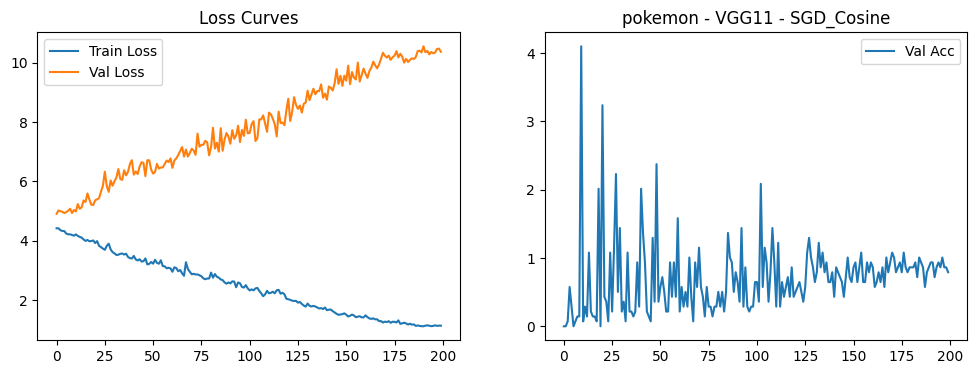


--- Model: VGG11, Config: Adam_NoReg ---


  1%|          | 1/100 [00:07<12:05,  7.33s/it]

Epoch   1/100 | Train Loss: 4.1034 | Val Loss: 5.2646 | Val Acc: 1.01%


  2%|▏         | 2/100 [00:15<12:41,  7.77s/it]

Epoch   2/100 | Train Loss: 4.0304 | Val Loss: 5.2306 | Val Acc: 0.22%


  3%|▎         | 3/100 [00:22<12:15,  7.58s/it]

Epoch   3/100 | Train Loss: 3.9749 | Val Loss: 5.5658 | Val Acc: 0.36%


  4%|▍         | 4/100 [00:30<12:15,  7.67s/it]

Epoch   4/100 | Train Loss: 3.9405 | Val Loss: 5.4129 | Val Acc: 0.22%


  5%|▌         | 5/100 [00:38<12:26,  7.86s/it]

Epoch   5/100 | Train Loss: 3.9668 | Val Loss: 5.5490 | Val Acc: 0.36%


  6%|▌         | 6/100 [00:45<11:53,  7.60s/it]

Epoch   6/100 | Train Loss: 3.8881 | Val Loss: 5.5341 | Val Acc: 0.94%


  7%|▋         | 7/100 [00:53<12:02,  7.77s/it]

Epoch   7/100 | Train Loss: 3.8173 | Val Loss: 5.7799 | Val Acc: 0.43%


  8%|▊         | 8/100 [01:01<11:45,  7.67s/it]

Epoch   8/100 | Train Loss: 3.7940 | Val Loss: 5.7822 | Val Acc: 0.50%


  9%|▉         | 9/100 [01:09<11:44,  7.74s/it]

Epoch   9/100 | Train Loss: 3.7562 | Val Loss: 5.8204 | Val Acc: 0.14%


 10%|█         | 10/100 [01:17<11:47,  7.86s/it]

Epoch  10/100 | Train Loss: 3.7037 | Val Loss: 6.0514 | Val Acc: 0.22%


 11%|█         | 11/100 [01:24<11:17,  7.61s/it]

Epoch  11/100 | Train Loss: 3.6535 | Val Loss: 5.9878 | Val Acc: 0.29%


 12%|█▏        | 12/100 [01:32<11:22,  7.76s/it]

Epoch  12/100 | Train Loss: 3.6155 | Val Loss: 6.1124 | Val Acc: 0.07%


 13%|█▎        | 13/100 [01:40<11:16,  7.77s/it]

Epoch  13/100 | Train Loss: 3.5695 | Val Loss: 6.3039 | Val Acc: 0.14%


 14%|█▍        | 14/100 [01:47<11:04,  7.72s/it]

Epoch  14/100 | Train Loss: 3.6583 | Val Loss: 6.1819 | Val Acc: 0.50%


 15%|█▌        | 15/100 [01:56<11:03,  7.81s/it]

Epoch  15/100 | Train Loss: 3.5428 | Val Loss: 6.5112 | Val Acc: 0.00%


 16%|█▌        | 16/100 [02:03<10:39,  7.61s/it]

Epoch  16/100 | Train Loss: 3.5019 | Val Loss: 6.3206 | Val Acc: 0.22%


 17%|█▋        | 17/100 [02:11<10:50,  7.83s/it]

Epoch  17/100 | Train Loss: 3.5008 | Val Loss: 6.6066 | Val Acc: 0.14%


 18%|█▊        | 18/100 [02:18<10:28,  7.66s/it]

Epoch  18/100 | Train Loss: 3.6433 | Val Loss: 6.4880 | Val Acc: 0.14%


 19%|█▉        | 19/100 [02:26<10:24,  7.71s/it]

Epoch  19/100 | Train Loss: 3.4944 | Val Loss: 6.4001 | Val Acc: 0.14%


 20%|██        | 20/100 [02:34<10:22,  7.79s/it]

Epoch  20/100 | Train Loss: 3.5063 | Val Loss: 6.2819 | Val Acc: 0.29%


 21%|██        | 21/100 [02:41<10:01,  7.61s/it]

Epoch  21/100 | Train Loss: 3.4260 | Val Loss: 6.6475 | Val Acc: 0.22%


 22%|██▏       | 22/100 [02:49<10:06,  7.78s/it]

Epoch  22/100 | Train Loss: 3.3718 | Val Loss: 6.8497 | Val Acc: 0.14%


 23%|██▎       | 23/100 [02:57<09:45,  7.60s/it]

Epoch  23/100 | Train Loss: 3.3926 | Val Loss: 6.6565 | Val Acc: 0.43%


 24%|██▍       | 24/100 [03:05<09:48,  7.75s/it]

Epoch  24/100 | Train Loss: 3.3465 | Val Loss: 6.8169 | Val Acc: 0.43%


 25%|██▌       | 25/100 [03:13<09:51,  7.89s/it]

Epoch  25/100 | Train Loss: 3.3181 | Val Loss: 6.9731 | Val Acc: 0.58%


 26%|██▌       | 26/100 [03:20<09:24,  7.63s/it]

Epoch  26/100 | Train Loss: 3.2705 | Val Loss: 6.7129 | Val Acc: 0.50%


 27%|██▋       | 27/100 [03:28<09:28,  7.79s/it]

Epoch  27/100 | Train Loss: 3.2682 | Val Loss: 6.6819 | Val Acc: 0.29%


 28%|██▊       | 28/100 [03:35<09:05,  7.58s/it]

Epoch  28/100 | Train Loss: 3.2040 | Val Loss: 7.0377 | Val Acc: 0.29%


 29%|██▉       | 29/100 [03:43<09:11,  7.77s/it]

Epoch  29/100 | Train Loss: 3.1970 | Val Loss: 7.2525 | Val Acc: 0.29%


 30%|███       | 30/100 [03:51<09:07,  7.82s/it]

Epoch  30/100 | Train Loss: 3.1658 | Val Loss: 7.2155 | Val Acc: 0.14%


 31%|███       | 31/100 [03:58<08:44,  7.60s/it]

Epoch  31/100 | Train Loss: 3.1499 | Val Loss: 7.0814 | Val Acc: 0.29%


 32%|███▏      | 32/100 [04:06<08:44,  7.72s/it]

Epoch  32/100 | Train Loss: 3.1063 | Val Loss: 7.1965 | Val Acc: 0.14%


 33%|███▎      | 33/100 [04:13<08:23,  7.51s/it]

Epoch  33/100 | Train Loss: 3.1380 | Val Loss: 7.1200 | Val Acc: 0.29%


 34%|███▍      | 34/100 [04:22<08:26,  7.68s/it]

Epoch  34/100 | Train Loss: 3.1392 | Val Loss: 7.0194 | Val Acc: 0.43%


 35%|███▌      | 35/100 [04:29<08:18,  7.67s/it]

Epoch  35/100 | Train Loss: 3.0655 | Val Loss: 7.2023 | Val Acc: 0.65%


 36%|███▌      | 36/100 [04:36<08:03,  7.55s/it]

Epoch  36/100 | Train Loss: 3.0604 | Val Loss: 7.2879 | Val Acc: 0.72%


 37%|███▋      | 37/100 [04:45<08:06,  7.73s/it]

Epoch  37/100 | Train Loss: 2.9947 | Val Loss: 7.4388 | Val Acc: 0.50%


 38%|███▊      | 38/100 [04:52<07:44,  7.50s/it]

Epoch  38/100 | Train Loss: 3.0063 | Val Loss: 7.5899 | Val Acc: 0.50%


 39%|███▉      | 39/100 [05:00<07:48,  7.68s/it]

Epoch  39/100 | Train Loss: 3.0561 | Val Loss: 7.4686 | Val Acc: 0.36%


 40%|████      | 40/100 [05:07<07:33,  7.55s/it]

Epoch  40/100 | Train Loss: 3.0140 | Val Loss: 7.3410 | Val Acc: 0.50%


 41%|████      | 41/100 [05:15<07:28,  7.60s/it]

Epoch  41/100 | Train Loss: 2.9558 | Val Loss: 7.4080 | Val Acc: 0.72%


 42%|████▏     | 42/100 [05:23<07:26,  7.69s/it]

Epoch  42/100 | Train Loss: 2.9287 | Val Loss: 7.4494 | Val Acc: 0.50%


 43%|████▎     | 43/100 [05:30<07:06,  7.48s/it]

Epoch  43/100 | Train Loss: 2.9131 | Val Loss: 7.6541 | Val Acc: 0.29%


 44%|████▍     | 44/100 [05:38<07:09,  7.67s/it]

Epoch  44/100 | Train Loss: 2.8971 | Val Loss: 7.5907 | Val Acc: 0.94%


 45%|████▌     | 45/100 [05:45<06:54,  7.53s/it]

Epoch  45/100 | Train Loss: 2.8873 | Val Loss: 7.7150 | Val Acc: 0.79%


 46%|████▌     | 46/100 [05:53<06:52,  7.63s/it]

Epoch  46/100 | Train Loss: 2.8479 | Val Loss: 7.6538 | Val Acc: 0.36%


 47%|████▋     | 47/100 [06:01<06:53,  7.80s/it]

Epoch  47/100 | Train Loss: 2.8829 | Val Loss: 7.6796 | Val Acc: 0.65%


 48%|████▊     | 48/100 [06:08<06:33,  7.57s/it]

Epoch  48/100 | Train Loss: 2.8386 | Val Loss: 8.0532 | Val Acc: 0.22%


 49%|████▉     | 49/100 [06:16<06:36,  7.77s/it]

Epoch  49/100 | Train Loss: 2.8910 | Val Loss: 7.8575 | Val Acc: 0.43%


 50%|█████     | 50/100 [06:23<06:18,  7.56s/it]

Epoch  50/100 | Train Loss: 2.8281 | Val Loss: 8.1964 | Val Acc: 0.22%


 51%|█████     | 51/100 [06:32<06:20,  7.77s/it]

Epoch  51/100 | Train Loss: 2.8154 | Val Loss: 8.0018 | Val Acc: 0.36%


 52%|█████▏    | 52/100 [06:40<06:17,  7.86s/it]

Epoch  52/100 | Train Loss: 2.8032 | Val Loss: 7.9461 | Val Acc: 0.29%


 53%|█████▎    | 53/100 [06:47<05:59,  7.66s/it]

Epoch  53/100 | Train Loss: 2.8123 | Val Loss: 8.0273 | Val Acc: 0.29%


 54%|█████▍    | 54/100 [06:55<05:58,  7.79s/it]

Epoch  54/100 | Train Loss: 2.7251 | Val Loss: 8.2847 | Val Acc: 0.14%


 55%|█████▌    | 55/100 [07:02<05:39,  7.54s/it]

Epoch  55/100 | Train Loss: 2.7405 | Val Loss: 8.2384 | Val Acc: 0.58%


 56%|█████▌    | 56/100 [07:10<05:38,  7.70s/it]

Epoch  56/100 | Train Loss: 2.7006 | Val Loss: 8.1995 | Val Acc: 0.29%


 57%|█████▋    | 57/100 [07:18<05:35,  7.80s/it]

Epoch  57/100 | Train Loss: 2.7776 | Val Loss: 8.0576 | Val Acc: 0.22%


 58%|█████▊    | 58/100 [07:25<05:17,  7.57s/it]

Epoch  58/100 | Train Loss: 2.7538 | Val Loss: 7.6765 | Val Acc: 0.36%


 59%|█████▉    | 59/100 [07:33<05:15,  7.69s/it]

Epoch  59/100 | Train Loss: 2.7321 | Val Loss: 7.9149 | Val Acc: 0.22%


 60%|██████    | 60/100 [07:40<05:00,  7.52s/it]

Epoch  60/100 | Train Loss: 2.6855 | Val Loss: 8.1944 | Val Acc: 0.36%


 61%|██████    | 61/100 [07:48<05:01,  7.73s/it]

Epoch  61/100 | Train Loss: 2.6706 | Val Loss: 8.4089 | Val Acc: 0.29%


 62%|██████▏   | 62/100 [07:56<04:50,  7.65s/it]

Epoch  62/100 | Train Loss: 2.6311 | Val Loss: 8.2262 | Val Acc: 0.36%


 63%|██████▎   | 63/100 [08:03<04:40,  7.58s/it]

Epoch  63/100 | Train Loss: 2.6310 | Val Loss: 8.5129 | Val Acc: 0.29%


 64%|██████▍   | 64/100 [08:11<04:36,  7.69s/it]

Epoch  64/100 | Train Loss: 2.6206 | Val Loss: 8.5825 | Val Acc: 0.22%


 65%|██████▌   | 65/100 [08:18<04:23,  7.53s/it]

Epoch  65/100 | Train Loss: 2.5954 | Val Loss: 8.5125 | Val Acc: 0.29%


 66%|██████▌   | 66/100 [08:26<04:21,  7.69s/it]

Epoch  66/100 | Train Loss: 2.5455 | Val Loss: 8.4977 | Val Acc: 0.43%


 67%|██████▋   | 67/100 [08:34<04:08,  7.54s/it]

Epoch  67/100 | Train Loss: 2.5899 | Val Loss: 8.6068 | Val Acc: 0.65%


 68%|██████▊   | 68/100 [08:41<04:02,  7.59s/it]

Epoch  68/100 | Train Loss: 2.5773 | Val Loss: 8.2978 | Val Acc: 0.22%


 69%|██████▉   | 69/100 [08:49<03:59,  7.73s/it]

Epoch  69/100 | Train Loss: 2.4841 | Val Loss: 9.2316 | Val Acc: 0.29%


 70%|███████   | 70/100 [08:56<03:45,  7.51s/it]

Epoch  70/100 | Train Loss: 2.5709 | Val Loss: 8.8374 | Val Acc: 0.58%


 71%|███████   | 71/100 [09:04<03:42,  7.68s/it]

Epoch  71/100 | Train Loss: 2.4575 | Val Loss: 8.8663 | Val Acc: 0.36%


 72%|███████▏  | 72/100 [09:11<03:29,  7.49s/it]

Epoch  72/100 | Train Loss: 2.6019 | Val Loss: 8.6288 | Val Acc: 0.29%


 73%|███████▎  | 73/100 [09:20<03:27,  7.70s/it]

Epoch  73/100 | Train Loss: 2.5295 | Val Loss: 8.4009 | Val Acc: 0.22%


 74%|███████▍  | 74/100 [09:28<03:22,  7.79s/it]

Epoch  74/100 | Train Loss: 2.5046 | Val Loss: 8.9898 | Val Acc: 0.36%


 75%|███████▌  | 75/100 [09:35<03:09,  7.56s/it]

Epoch  75/100 | Train Loss: 2.5649 | Val Loss: 8.5305 | Val Acc: 0.43%


 76%|███████▌  | 76/100 [09:43<03:04,  7.70s/it]

Epoch  76/100 | Train Loss: 2.4424 | Val Loss: 8.7586 | Val Acc: 0.29%


 77%|███████▋  | 77/100 [09:50<02:52,  7.52s/it]

Epoch  77/100 | Train Loss: 2.4779 | Val Loss: 8.8497 | Val Acc: 0.36%


 78%|███████▊  | 78/100 [09:58<02:49,  7.72s/it]

Epoch  78/100 | Train Loss: 2.4183 | Val Loss: 9.1699 | Val Acc: 0.43%


 79%|███████▉  | 79/100 [10:06<02:43,  7.78s/it]

Epoch  79/100 | Train Loss: 2.4090 | Val Loss: 9.0965 | Val Acc: 0.36%


 80%|████████  | 80/100 [10:13<02:30,  7.51s/it]

Epoch  80/100 | Train Loss: 2.4247 | Val Loss: 8.7422 | Val Acc: 0.43%


 81%|████████  | 81/100 [10:21<02:26,  7.71s/it]

Epoch  81/100 | Train Loss: 2.3873 | Val Loss: 8.9640 | Val Acc: 0.72%


 82%|████████▏ | 82/100 [10:28<02:14,  7.46s/it]

Epoch  82/100 | Train Loss: 2.3810 | Val Loss: 8.9385 | Val Acc: 0.43%


 83%|████████▎ | 83/100 [10:36<02:09,  7.64s/it]

Epoch  83/100 | Train Loss: 2.3581 | Val Loss: 9.1125 | Val Acc: 0.36%


 84%|████████▍ | 84/100 [10:44<02:02,  7.66s/it]

Epoch  84/100 | Train Loss: 2.3362 | Val Loss: 9.4448 | Val Acc: 0.36%


 85%|████████▌ | 85/100 [10:51<01:53,  7.60s/it]

Epoch  85/100 | Train Loss: 2.3488 | Val Loss: 9.3404 | Val Acc: 0.43%


 86%|████████▌ | 86/100 [10:59<01:47,  7.65s/it]

Epoch  86/100 | Train Loss: 2.3493 | Val Loss: 9.1476 | Val Acc: 0.50%


 87%|████████▋ | 87/100 [11:06<01:36,  7.43s/it]

Epoch  87/100 | Train Loss: 2.3248 | Val Loss: 9.1306 | Val Acc: 0.36%


 88%|████████▊ | 88/100 [11:14<01:30,  7.58s/it]

Epoch  88/100 | Train Loss: 2.2849 | Val Loss: 9.7162 | Val Acc: 0.14%


 89%|████████▉ | 89/100 [11:21<01:22,  7.48s/it]

Epoch  89/100 | Train Loss: 2.3036 | Val Loss: 9.5942 | Val Acc: 0.43%


 90%|█████████ | 90/100 [11:29<01:15,  7.58s/it]

Epoch  90/100 | Train Loss: 2.5893 | Val Loss: 8.7267 | Val Acc: 0.86%


 91%|█████████ | 91/100 [11:37<01:09,  7.73s/it]

Epoch  91/100 | Train Loss: 2.4331 | Val Loss: 8.9857 | Val Acc: 0.29%


 92%|█████████▏| 92/100 [11:44<01:00,  7.50s/it]

Epoch  92/100 | Train Loss: 2.3091 | Val Loss: 9.0252 | Val Acc: 0.29%


 93%|█████████▎| 93/100 [11:52<00:54,  7.73s/it]

Epoch  93/100 | Train Loss: 2.3284 | Val Loss: 8.5821 | Val Acc: 0.36%


 94%|█████████▍| 94/100 [11:59<00:45,  7.52s/it]

Epoch  94/100 | Train Loss: 2.2868 | Val Loss: 9.3426 | Val Acc: 0.36%


 95%|█████████▌| 95/100 [12:07<00:38,  7.62s/it]

Epoch  95/100 | Train Loss: 2.2458 | Val Loss: 9.5208 | Val Acc: 0.50%


 96%|█████████▌| 96/100 [12:15<00:30,  7.72s/it]

Epoch  96/100 | Train Loss: 2.2604 | Val Loss: 9.6873 | Val Acc: 0.29%


 97%|█████████▋| 97/100 [12:22<00:22,  7.54s/it]

Epoch  97/100 | Train Loss: 2.3121 | Val Loss: 9.1174 | Val Acc: 0.65%


 98%|█████████▊| 98/100 [12:30<00:15,  7.67s/it]

Epoch  98/100 | Train Loss: 2.2170 | Val Loss: 9.7979 | Val Acc: 0.43%


 99%|█████████▉| 99/100 [12:37<00:07,  7.41s/it]

Epoch  99/100 | Train Loss: 2.1954 | Val Loss: 9.7920 | Val Acc: 0.36%


100%|██████████| 100/100 [12:45<00:00,  7.65s/it]

Epoch 100/100 | Train Loss: 2.1709 | Val Loss: 9.5990 | Val Acc: 0.50%


FINAL TEST ACCURACY: 0.14%



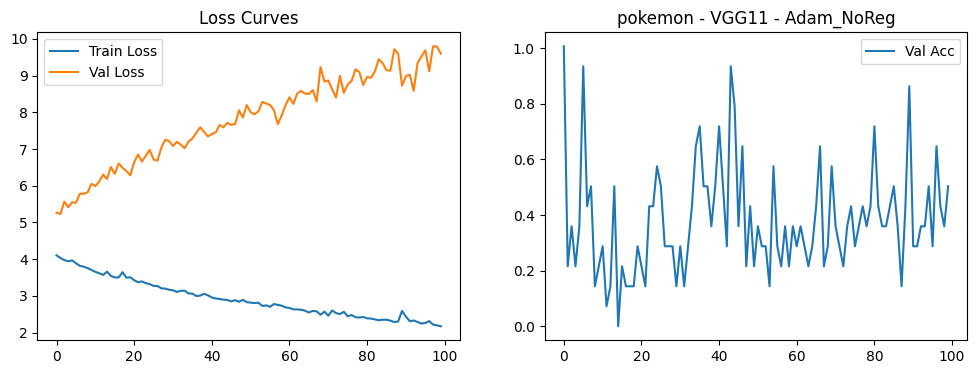


--- Model: VGG11, Config: Adam_WD ---


  1%|          | 1/150 [00:08<20:08,  8.11s/it]

Epoch   1/150 | Train Loss: 4.0077 | Val Loss: 5.2035 | Val Acc: 0.22%


  1%|▏         | 2/150 [00:15<18:16,  7.41s/it]

Epoch   2/150 | Train Loss: 3.9675 | Val Loss: 5.7872 | Val Acc: 0.65%


  2%|▏         | 3/150 [00:23<18:55,  7.72s/it]

Epoch   3/150 | Train Loss: 3.7958 | Val Loss: 5.8915 | Val Acc: 0.65%


  3%|▎         | 4/150 [00:30<18:05,  7.44s/it]

Epoch   4/150 | Train Loss: 3.7116 | Val Loss: 6.2334 | Val Acc: 0.43%


  3%|▎         | 5/150 [00:38<18:43,  7.75s/it]

Epoch   5/150 | Train Loss: 3.5860 | Val Loss: 6.2869 | Val Acc: 0.29%


  4%|▍         | 6/150 [00:46<18:50,  7.85s/it]

Epoch   6/150 | Train Loss: 3.5669 | Val Loss: 6.6807 | Val Acc: 0.43%


  5%|▍         | 7/150 [00:53<18:00,  7.55s/it]

Epoch   7/150 | Train Loss: 3.4714 | Val Loss: 6.5741 | Val Acc: 0.22%


  5%|▌         | 8/150 [01:01<18:23,  7.77s/it]

Epoch   8/150 | Train Loss: 3.4101 | Val Loss: 6.4548 | Val Acc: 0.43%


  6%|▌         | 9/150 [01:08<17:52,  7.61s/it]

Epoch   9/150 | Train Loss: 3.3394 | Val Loss: 6.6834 | Val Acc: 0.29%


  7%|▋         | 10/150 [01:16<18:01,  7.73s/it]

Epoch  10/150 | Train Loss: 3.2779 | Val Loss: 6.8329 | Val Acc: 0.58%


  7%|▋         | 11/150 [01:24<17:59,  7.77s/it]

Epoch  11/150 | Train Loss: 3.2847 | Val Loss: 7.2911 | Val Acc: 0.58%


  8%|▊         | 12/150 [01:31<17:20,  7.54s/it]

Epoch  12/150 | Train Loss: 3.2521 | Val Loss: 7.0108 | Val Acc: 0.79%


  9%|▊         | 13/150 [01:39<17:36,  7.72s/it]

Epoch  13/150 | Train Loss: 3.1362 | Val Loss: 7.1222 | Val Acc: 0.86%


  9%|▉         | 14/150 [01:46<16:58,  7.49s/it]

Epoch  14/150 | Train Loss: 3.1144 | Val Loss: 7.2520 | Val Acc: 0.72%


 10%|█         | 15/150 [01:54<17:11,  7.64s/it]

Epoch  15/150 | Train Loss: 3.0857 | Val Loss: 7.1921 | Val Acc: 0.43%


 11%|█         | 16/150 [02:02<17:07,  7.67s/it]

Epoch  16/150 | Train Loss: 3.1101 | Val Loss: 7.1527 | Val Acc: 0.50%


 11%|█▏        | 17/150 [02:09<16:37,  7.50s/it]

Epoch  17/150 | Train Loss: 3.0737 | Val Loss: 7.2097 | Val Acc: 0.72%


 12%|█▏        | 18/150 [02:17<16:51,  7.66s/it]

Epoch  18/150 | Train Loss: 3.0924 | Val Loss: 7.2228 | Val Acc: 0.79%


 13%|█▎        | 19/150 [02:24<16:13,  7.43s/it]

Epoch  19/150 | Train Loss: 3.0655 | Val Loss: 7.2149 | Val Acc: 0.65%


 13%|█▎        | 20/150 [02:32<16:26,  7.59s/it]

Epoch  20/150 | Train Loss: 3.0786 | Val Loss: 7.1296 | Val Acc: 0.50%


 14%|█▍        | 21/150 [02:40<16:20,  7.60s/it]

Epoch  21/150 | Train Loss: 3.0571 | Val Loss: 7.3415 | Val Acc: 0.58%


 15%|█▍        | 22/150 [02:47<16:00,  7.51s/it]

Epoch  22/150 | Train Loss: 3.0614 | Val Loss: 7.2220 | Val Acc: 0.94%


 15%|█▌        | 23/150 [02:55<16:04,  7.59s/it]

Epoch  23/150 | Train Loss: 3.0441 | Val Loss: 7.3124 | Val Acc: 0.79%


 16%|█▌        | 24/150 [03:02<15:29,  7.37s/it]

Epoch  24/150 | Train Loss: 3.0278 | Val Loss: 7.2629 | Val Acc: 0.79%


 17%|█▋        | 25/150 [03:10<15:50,  7.60s/it]

Epoch  25/150 | Train Loss: 3.0362 | Val Loss: 7.2561 | Val Acc: 0.72%


 17%|█▋        | 26/150 [03:17<15:19,  7.42s/it]

Epoch  26/150 | Train Loss: 3.0196 | Val Loss: 7.3321 | Val Acc: 1.08%


 18%|█▊        | 27/150 [03:25<15:30,  7.57s/it]

Epoch  27/150 | Train Loss: 3.0285 | Val Loss: 7.2982 | Val Acc: 0.79%


 19%|█▊        | 28/150 [03:33<15:35,  7.67s/it]

Epoch  28/150 | Train Loss: 3.0087 | Val Loss: 7.3113 | Val Acc: 1.15%


 19%|█▉        | 29/150 [03:40<15:07,  7.50s/it]

Epoch  29/150 | Train Loss: 3.0104 | Val Loss: 7.3250 | Val Acc: 0.79%


 20%|██        | 30/150 [03:48<15:16,  7.64s/it]

Epoch  30/150 | Train Loss: 3.0106 | Val Loss: 7.3348 | Val Acc: 0.94%


 21%|██        | 31/150 [03:55<14:45,  7.44s/it]

Epoch  31/150 | Train Loss: 3.0024 | Val Loss: 7.2781 | Val Acc: 0.94%


 21%|██▏       | 32/150 [04:03<14:56,  7.59s/it]

Epoch  32/150 | Train Loss: 3.0193 | Val Loss: 7.3591 | Val Acc: 1.08%


 22%|██▏       | 33/150 [04:10<14:52,  7.63s/it]

Epoch  33/150 | Train Loss: 3.0431 | Val Loss: 7.3684 | Val Acc: 1.08%


 23%|██▎       | 34/150 [04:17<14:29,  7.50s/it]

Epoch  34/150 | Train Loss: 3.0346 | Val Loss: 7.3212 | Val Acc: 0.94%


 23%|██▎       | 35/150 [04:25<14:33,  7.59s/it]

Epoch  35/150 | Train Loss: 3.0100 | Val Loss: 7.2897 | Val Acc: 0.79%


 24%|██▍       | 36/150 [04:32<14:00,  7.38s/it]

Epoch  36/150 | Train Loss: 3.0121 | Val Loss: 7.3019 | Val Acc: 0.72%


 25%|██▍       | 37/150 [04:40<14:20,  7.62s/it]

Epoch  37/150 | Train Loss: 3.0097 | Val Loss: 7.4255 | Val Acc: 0.72%


 25%|██▌       | 38/150 [04:47<13:46,  7.38s/it]

Epoch  38/150 | Train Loss: 3.0187 | Val Loss: 7.2572 | Val Acc: 0.86%


 26%|██▌       | 39/150 [04:55<14:00,  7.57s/it]

Epoch  39/150 | Train Loss: 3.0101 | Val Loss: 7.3193 | Val Acc: 0.50%


 27%|██▋       | 40/150 [05:03<14:04,  7.68s/it]

Epoch  40/150 | Train Loss: 3.0151 | Val Loss: 7.3298 | Val Acc: 0.79%


 27%|██▋       | 41/150 [05:10<13:32,  7.46s/it]

Epoch  41/150 | Train Loss: 3.0102 | Val Loss: 7.3334 | Val Acc: 0.94%


 28%|██▊       | 42/150 [05:18<13:40,  7.60s/it]

Epoch  42/150 | Train Loss: 3.0030 | Val Loss: 7.3815 | Val Acc: 1.01%


 29%|██▊       | 43/150 [05:25<13:08,  7.37s/it]

Epoch  43/150 | Train Loss: 3.0164 | Val Loss: 7.2423 | Val Acc: 1.01%


 29%|██▉       | 44/150 [05:33<13:15,  7.51s/it]

Epoch  44/150 | Train Loss: 3.0031 | Val Loss: 7.3921 | Val Acc: 0.79%


 30%|███       | 45/150 [05:40<12:57,  7.41s/it]

Epoch  45/150 | Train Loss: 3.0026 | Val Loss: 7.2764 | Val Acc: 0.72%


 31%|███       | 46/150 [05:47<12:53,  7.43s/it]

Epoch  46/150 | Train Loss: 3.0271 | Val Loss: 7.2938 | Val Acc: 0.65%


 31%|███▏      | 47/150 [05:55<12:57,  7.55s/it]

Epoch  47/150 | Train Loss: 3.0219 | Val Loss: 7.2586 | Val Acc: 0.58%


 32%|███▏      | 48/150 [06:02<12:24,  7.30s/it]

Epoch  48/150 | Train Loss: 3.0112 | Val Loss: 7.3340 | Val Acc: 0.94%


 33%|███▎      | 49/150 [06:10<12:36,  7.49s/it]

Epoch  49/150 | Train Loss: 3.0194 | Val Loss: 7.4205 | Val Acc: 0.94%


 33%|███▎      | 50/150 [06:17<12:08,  7.28s/it]

Epoch  50/150 | Train Loss: 3.0095 | Val Loss: 7.2770 | Val Acc: 0.79%


 34%|███▍      | 51/150 [06:25<12:26,  7.54s/it]

Epoch  51/150 | Train Loss: 2.9982 | Val Loss: 7.3671 | Val Acc: 1.22%


 35%|███▍      | 52/150 [06:33<12:26,  7.62s/it]

Epoch  52/150 | Train Loss: 3.0024 | Val Loss: 7.2978 | Val Acc: 0.86%


 35%|███▌      | 53/150 [06:40<12:04,  7.46s/it]

Epoch  53/150 | Train Loss: 3.0253 | Val Loss: 7.2698 | Val Acc: 0.86%


 36%|███▌      | 54/150 [06:48<12:09,  7.60s/it]

Epoch  54/150 | Train Loss: 3.0092 | Val Loss: 7.3163 | Val Acc: 0.65%


 37%|███▋      | 55/150 [06:54<11:43,  7.40s/it]

Epoch  55/150 | Train Loss: 3.0336 | Val Loss: 7.2834 | Val Acc: 0.65%


 37%|███▋      | 56/150 [07:02<11:50,  7.56s/it]

Epoch  56/150 | Train Loss: 3.0042 | Val Loss: 7.2917 | Val Acc: 0.79%


 38%|███▊      | 57/150 [07:10<11:40,  7.53s/it]

Epoch  57/150 | Train Loss: 3.0108 | Val Loss: 7.2888 | Val Acc: 0.86%


 39%|███▊      | 58/150 [07:17<11:27,  7.48s/it]

Epoch  58/150 | Train Loss: 3.0374 | Val Loss: 7.3983 | Val Acc: 0.50%


 39%|███▉      | 59/150 [07:25<11:28,  7.56s/it]

Epoch  59/150 | Train Loss: 2.9856 | Val Loss: 7.3845 | Val Acc: 0.94%


 40%|████      | 60/150 [07:32<11:04,  7.38s/it]

Epoch  60/150 | Train Loss: 2.9971 | Val Loss: 7.3085 | Val Acc: 0.58%


 41%|████      | 61/150 [07:40<11:12,  7.56s/it]

Epoch  61/150 | Train Loss: 3.0237 | Val Loss: 7.3509 | Val Acc: 0.86%


 41%|████▏     | 62/150 [07:47<10:45,  7.33s/it]

Epoch  62/150 | Train Loss: 2.9820 | Val Loss: 7.3090 | Val Acc: 0.65%


 42%|████▏     | 63/150 [07:55<10:55,  7.53s/it]

Epoch  63/150 | Train Loss: 3.0318 | Val Loss: 7.2489 | Val Acc: 0.86%


 43%|████▎     | 64/150 [08:03<10:53,  7.60s/it]

Epoch  64/150 | Train Loss: 3.0090 | Val Loss: 7.3235 | Val Acc: 0.79%


 43%|████▎     | 65/150 [08:09<10:28,  7.40s/it]

Epoch  65/150 | Train Loss: 3.0191 | Val Loss: 7.2998 | Val Acc: 0.79%


 44%|████▍     | 66/150 [08:17<10:34,  7.56s/it]

Epoch  66/150 | Train Loss: 3.0180 | Val Loss: 7.3610 | Val Acc: 0.72%


 45%|████▍     | 67/150 [08:24<10:14,  7.40s/it]

Epoch  67/150 | Train Loss: 3.0182 | Val Loss: 7.2920 | Val Acc: 0.43%


 45%|████▌     | 68/150 [08:32<10:22,  7.59s/it]

Epoch  68/150 | Train Loss: 3.0226 | Val Loss: 7.2980 | Val Acc: 1.29%


 46%|████▌     | 69/150 [08:40<10:19,  7.65s/it]

Epoch  69/150 | Train Loss: 2.9986 | Val Loss: 7.3149 | Val Acc: 0.94%


 47%|████▋     | 70/150 [08:47<10:01,  7.51s/it]

Epoch  70/150 | Train Loss: 3.0458 | Val Loss: 7.3404 | Val Acc: 1.01%


 47%|████▋     | 71/150 [08:55<10:03,  7.64s/it]

Epoch  71/150 | Train Loss: 3.0173 | Val Loss: 7.3098 | Val Acc: 0.43%


 48%|████▊     | 72/150 [09:02<09:38,  7.42s/it]

Epoch  72/150 | Train Loss: 3.0169 | Val Loss: 7.2811 | Val Acc: 1.01%


 49%|████▊     | 73/150 [09:10<09:41,  7.56s/it]

Epoch  73/150 | Train Loss: 3.0144 | Val Loss: 7.3140 | Val Acc: 0.65%


 49%|████▉     | 74/150 [09:17<09:25,  7.44s/it]

Epoch  74/150 | Train Loss: 3.0133 | Val Loss: 7.3281 | Val Acc: 0.58%


 50%|█████     | 75/150 [09:25<09:23,  7.51s/it]

Epoch  75/150 | Train Loss: 3.0015 | Val Loss: 7.2695 | Val Acc: 0.86%


 51%|█████     | 76/150 [09:33<09:23,  7.62s/it]

Epoch  76/150 | Train Loss: 3.0058 | Val Loss: 7.2736 | Val Acc: 0.79%


 51%|█████▏    | 77/150 [09:40<08:59,  7.38s/it]

Epoch  77/150 | Train Loss: 3.0181 | Val Loss: 7.3453 | Val Acc: 0.79%


 52%|█████▏    | 78/150 [09:48<09:08,  7.62s/it]

Epoch  78/150 | Train Loss: 3.0226 | Val Loss: 7.2335 | Val Acc: 0.65%


 53%|█████▎    | 79/150 [09:55<08:46,  7.42s/it]

Epoch  79/150 | Train Loss: 3.0090 | Val Loss: 7.2935 | Val Acc: 0.94%


 53%|█████▎    | 80/150 [10:03<08:53,  7.62s/it]

Epoch  80/150 | Train Loss: 2.9926 | Val Loss: 7.3911 | Val Acc: 0.79%


 54%|█████▍    | 81/150 [10:11<08:53,  7.73s/it]

Epoch  81/150 | Train Loss: 3.0076 | Val Loss: 7.2900 | Val Acc: 0.79%


 55%|█████▍    | 82/150 [10:18<08:31,  7.53s/it]

Epoch  82/150 | Train Loss: 2.9962 | Val Loss: 7.2743 | Val Acc: 0.50%


 55%|█████▌    | 83/150 [10:26<08:35,  7.69s/it]

Epoch  83/150 | Train Loss: 3.0005 | Val Loss: 7.3137 | Val Acc: 1.01%


 56%|█████▌    | 84/150 [10:33<08:13,  7.48s/it]

Epoch  84/150 | Train Loss: 2.9952 | Val Loss: 7.3159 | Val Acc: 0.79%


 57%|█████▋    | 85/150 [10:41<08:15,  7.63s/it]

Epoch  85/150 | Train Loss: 3.0152 | Val Loss: 7.3116 | Val Acc: 0.94%


 57%|█████▋    | 86/150 [10:49<08:09,  7.64s/it]

Epoch  86/150 | Train Loss: 3.0068 | Val Loss: 7.2652 | Val Acc: 0.94%


 58%|█████▊    | 87/150 [10:56<07:56,  7.56s/it]

Epoch  87/150 | Train Loss: 2.9866 | Val Loss: 7.3618 | Val Acc: 1.08%


 59%|█████▊    | 88/150 [11:04<07:52,  7.63s/it]

Epoch  88/150 | Train Loss: 2.9945 | Val Loss: 7.2875 | Val Acc: 0.58%


 59%|█████▉    | 89/150 [11:11<07:32,  7.42s/it]

Epoch  89/150 | Train Loss: 3.0120 | Val Loss: 7.2905 | Val Acc: 0.86%


 60%|██████    | 90/150 [11:19<07:37,  7.63s/it]

Epoch  90/150 | Train Loss: 3.0116 | Val Loss: 7.2569 | Val Acc: 0.43%


 61%|██████    | 91/150 [11:26<07:18,  7.43s/it]

Epoch  91/150 | Train Loss: 3.0385 | Val Loss: 7.3366 | Val Acc: 0.65%


 61%|██████▏   | 92/150 [11:34<07:19,  7.58s/it]

Epoch  92/150 | Train Loss: 3.0173 | Val Loss: 7.3185 | Val Acc: 0.86%


 62%|██████▏   | 93/150 [11:42<07:17,  7.68s/it]

Epoch  93/150 | Train Loss: 2.9954 | Val Loss: 7.2810 | Val Acc: 0.72%


 63%|██████▎   | 94/150 [11:49<06:59,  7.48s/it]

Epoch  94/150 | Train Loss: 2.9983 | Val Loss: 7.2452 | Val Acc: 0.79%


 63%|██████▎   | 95/150 [11:57<07:00,  7.65s/it]

Epoch  95/150 | Train Loss: 2.9965 | Val Loss: 7.2567 | Val Acc: 0.86%


 64%|██████▍   | 96/150 [12:04<06:41,  7.43s/it]

Epoch  96/150 | Train Loss: 2.9752 | Val Loss: 7.3097 | Val Acc: 0.86%


 65%|██████▍   | 97/150 [12:12<06:43,  7.60s/it]

Epoch  97/150 | Train Loss: 3.0138 | Val Loss: 7.2893 | Val Acc: 0.72%


 65%|██████▌   | 98/150 [12:19<06:37,  7.64s/it]

Epoch  98/150 | Train Loss: 3.0042 | Val Loss: 7.3422 | Val Acc: 0.72%


 66%|██████▌   | 99/150 [12:26<06:20,  7.46s/it]

Epoch  99/150 | Train Loss: 3.0005 | Val Loss: 7.3087 | Val Acc: 0.72%


 67%|██████▋   | 100/150 [12:34<06:19,  7.59s/it]

Epoch 100/150 | Train Loss: 3.0124 | Val Loss: 7.2789 | Val Acc: 0.86%


 67%|██████▋   | 101/150 [12:41<06:02,  7.39s/it]

Epoch 101/150 | Train Loss: 3.0063 | Val Loss: 7.3070 | Val Acc: 0.72%


 68%|██████▊   | 102/150 [12:49<06:06,  7.63s/it]

Epoch 102/150 | Train Loss: 3.0170 | Val Loss: 7.3434 | Val Acc: 0.72%


 69%|██████▊   | 103/150 [12:56<05:48,  7.42s/it]

Epoch 103/150 | Train Loss: 3.0086 | Val Loss: 7.3261 | Val Acc: 0.79%


 69%|██████▉   | 104/150 [13:04<05:47,  7.56s/it]

Epoch 104/150 | Train Loss: 3.0191 | Val Loss: 7.3172 | Val Acc: 0.65%


 70%|███████   | 105/150 [13:12<05:44,  7.65s/it]

Epoch 105/150 | Train Loss: 3.0103 | Val Loss: 7.3579 | Val Acc: 0.86%


 71%|███████   | 106/150 [13:19<05:27,  7.45s/it]

Epoch 106/150 | Train Loss: 3.0088 | Val Loss: 7.3390 | Val Acc: 0.58%


 71%|███████▏  | 107/150 [13:27<05:28,  7.64s/it]

Epoch 107/150 | Train Loss: 3.0167 | Val Loss: 7.3209 | Val Acc: 0.86%


 72%|███████▏  | 108/150 [13:34<05:13,  7.46s/it]

Epoch 108/150 | Train Loss: 3.0101 | Val Loss: 7.3301 | Val Acc: 0.86%


 73%|███████▎  | 109/150 [13:42<05:13,  7.65s/it]

Epoch 109/150 | Train Loss: 3.0017 | Val Loss: 7.2403 | Val Acc: 0.79%


 73%|███████▎  | 110/150 [13:50<05:09,  7.74s/it]

Epoch 110/150 | Train Loss: 3.0143 | Val Loss: 7.3610 | Val Acc: 0.72%


 74%|███████▍  | 111/150 [13:57<04:50,  7.45s/it]

Epoch 111/150 | Train Loss: 3.0026 | Val Loss: 7.3295 | Val Acc: 0.65%


 75%|███████▍  | 112/150 [14:05<04:48,  7.59s/it]

Epoch 112/150 | Train Loss: 3.0178 | Val Loss: 7.3025 | Val Acc: 0.86%


 75%|███████▌  | 113/150 [14:12<04:34,  7.42s/it]

Epoch 113/150 | Train Loss: 2.9906 | Val Loss: 7.3526 | Val Acc: 0.65%


 76%|███████▌  | 114/150 [14:20<04:33,  7.60s/it]

Epoch 114/150 | Train Loss: 3.0187 | Val Loss: 7.3386 | Val Acc: 0.58%


 77%|███████▋  | 115/150 [14:28<04:29,  7.70s/it]

Epoch 115/150 | Train Loss: 3.0045 | Val Loss: 7.3390 | Val Acc: 1.01%


 77%|███████▋  | 116/150 [14:35<04:15,  7.52s/it]

Epoch 116/150 | Train Loss: 3.0133 | Val Loss: 7.2861 | Val Acc: 0.86%


 78%|███████▊  | 117/150 [14:43<04:13,  7.68s/it]

Epoch 117/150 | Train Loss: 3.0319 | Val Loss: 7.2746 | Val Acc: 0.65%


 79%|███████▊  | 118/150 [14:50<04:00,  7.50s/it]

Epoch 118/150 | Train Loss: 3.0321 | Val Loss: 7.3657 | Val Acc: 0.72%


 79%|███████▉  | 119/150 [14:58<03:57,  7.66s/it]

Epoch 119/150 | Train Loss: 3.0041 | Val Loss: 7.2983 | Val Acc: 0.79%


 80%|████████  | 120/150 [15:05<03:45,  7.51s/it]

Epoch 120/150 | Train Loss: 2.9992 | Val Loss: 7.3368 | Val Acc: 0.94%


 81%|████████  | 121/150 [15:13<03:38,  7.52s/it]

Epoch 121/150 | Train Loss: 3.0190 | Val Loss: 7.2786 | Val Acc: 0.79%


 81%|████████▏ | 122/150 [15:21<03:34,  7.67s/it]

Epoch 122/150 | Train Loss: 3.0176 | Val Loss: 7.3442 | Val Acc: 0.50%


 82%|████████▏ | 123/150 [15:28<03:20,  7.42s/it]

Epoch 123/150 | Train Loss: 3.0252 | Val Loss: 7.3131 | Val Acc: 1.01%


 83%|████████▎ | 124/150 [15:36<03:17,  7.60s/it]

Epoch 124/150 | Train Loss: 3.0138 | Val Loss: 7.2577 | Val Acc: 0.86%


 83%|████████▎ | 125/150 [15:43<03:05,  7.41s/it]

Epoch 125/150 | Train Loss: 3.0210 | Val Loss: 7.3404 | Val Acc: 0.72%


 84%|████████▍ | 126/150 [15:51<03:01,  7.56s/it]

Epoch 126/150 | Train Loss: 3.0161 | Val Loss: 7.2905 | Val Acc: 0.94%


 85%|████████▍ | 127/150 [15:58<02:55,  7.63s/it]

Epoch 127/150 | Train Loss: 3.0031 | Val Loss: 7.2703 | Val Acc: 0.94%


 85%|████████▌ | 128/150 [16:05<02:43,  7.42s/it]

Epoch 128/150 | Train Loss: 2.9940 | Val Loss: 7.2847 | Val Acc: 1.01%


 86%|████████▌ | 129/150 [16:13<02:38,  7.54s/it]

Epoch 129/150 | Train Loss: 3.0217 | Val Loss: 7.2399 | Val Acc: 1.15%


 87%|████████▋ | 130/150 [16:20<02:27,  7.40s/it]

Epoch 130/150 | Train Loss: 3.0049 | Val Loss: 7.2946 | Val Acc: 0.79%


 87%|████████▋ | 131/150 [16:28<02:23,  7.57s/it]

Epoch 131/150 | Train Loss: 3.0054 | Val Loss: 7.3177 | Val Acc: 0.79%


 88%|████████▊ | 132/150 [16:36<02:16,  7.59s/it]

Epoch 132/150 | Train Loss: 2.9845 | Val Loss: 7.3230 | Val Acc: 0.72%


 89%|████████▊ | 133/150 [16:43<02:08,  7.53s/it]

Epoch 133/150 | Train Loss: 3.0099 | Val Loss: 7.3433 | Val Acc: 1.08%


 89%|████████▉ | 134/150 [16:51<02:03,  7.69s/it]

Epoch 134/150 | Train Loss: 2.9938 | Val Loss: 7.3241 | Val Acc: 0.86%


 90%|█████████ | 135/150 [16:58<01:52,  7.49s/it]

Epoch 135/150 | Train Loss: 2.9985 | Val Loss: 7.2896 | Val Acc: 0.65%


 91%|█████████ | 136/150 [17:06<01:47,  7.69s/it]

Epoch 136/150 | Train Loss: 2.9995 | Val Loss: 7.2457 | Val Acc: 0.86%


 91%|█████████▏| 137/150 [17:14<01:38,  7.60s/it]

Epoch 137/150 | Train Loss: 3.0185 | Val Loss: 7.3299 | Val Acc: 0.79%


 92%|█████████▏| 138/150 [17:22<01:31,  7.65s/it]

Epoch 138/150 | Train Loss: 2.9989 | Val Loss: 7.3593 | Val Acc: 0.65%


 93%|█████████▎| 139/150 [17:29<01:24,  7.71s/it]

Epoch 139/150 | Train Loss: 3.0114 | Val Loss: 7.2892 | Val Acc: 0.94%


 93%|█████████▎| 140/150 [17:36<01:14,  7.41s/it]

Epoch 140/150 | Train Loss: 2.9972 | Val Loss: 7.3207 | Val Acc: 0.79%


 94%|█████████▍| 141/150 [17:44<01:08,  7.56s/it]

Epoch 141/150 | Train Loss: 3.0094 | Val Loss: 7.3774 | Val Acc: 0.94%


 95%|█████████▍| 142/150 [17:51<00:58,  7.36s/it]

Epoch 142/150 | Train Loss: 3.0317 | Val Loss: 7.2516 | Val Acc: 0.65%


 95%|█████████▌| 143/150 [17:59<00:52,  7.54s/it]

Epoch 143/150 | Train Loss: 2.9987 | Val Loss: 7.3146 | Val Acc: 0.65%


 96%|█████████▌| 144/150 [18:07<00:45,  7.56s/it]

Epoch 144/150 | Train Loss: 3.0301 | Val Loss: 7.3215 | Val Acc: 0.50%


 97%|█████████▋| 145/150 [18:14<00:37,  7.42s/it]

Epoch 145/150 | Train Loss: 3.0148 | Val Loss: 7.2881 | Val Acc: 0.72%


 97%|█████████▋| 146/150 [18:21<00:30,  7.54s/it]

Epoch 146/150 | Train Loss: 3.0040 | Val Loss: 7.2302 | Val Acc: 0.86%


 98%|█████████▊| 147/150 [18:28<00:22,  7.36s/it]

Epoch 147/150 | Train Loss: 3.0079 | Val Loss: 7.3144 | Val Acc: 0.58%


 99%|█████████▊| 148/150 [18:36<00:15,  7.55s/it]

Epoch 148/150 | Train Loss: 3.0238 | Val Loss: 7.3284 | Val Acc: 0.65%


 99%|█████████▉| 149/150 [18:44<00:07,  7.42s/it]

Epoch 149/150 | Train Loss: 3.0120 | Val Loss: 7.2751 | Val Acc: 0.72%


100%|██████████| 150/150 [18:51<00:00,  7.54s/it]

Epoch 150/150 | Train Loss: 3.0185 | Val Loss: 7.3027 | Val Acc: 1.01%


FINAL TEST ACCURACY: 2.46%



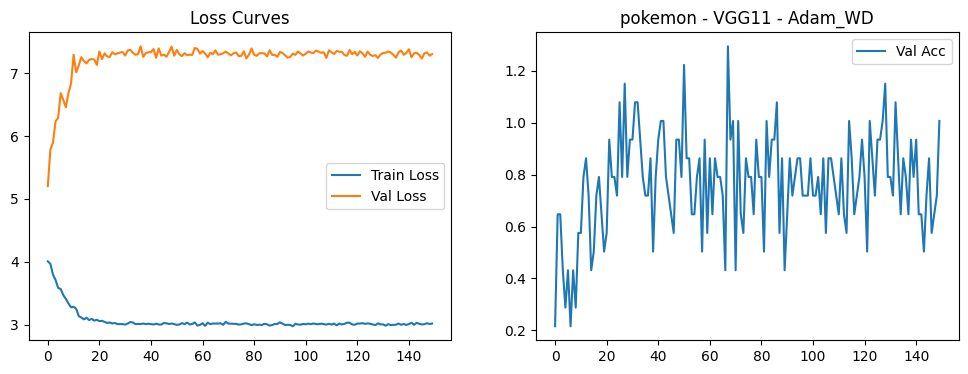


----- Training ResNet18 -----

--- Model: ResNet18, Config: SGD_StepDecay ---


  0%|          | 1/200 [00:17<57:06, 17.22s/it]

Epoch   1/200 | Train Loss: 4.3401 | Val Loss: 11.7375 | Val Acc: 0.00%


  1%|          | 2/200 [00:34<56:51, 17.23s/it]

Epoch   2/200 | Train Loss: 3.8003 | Val Loss: 6.4657 | Val Acc: 0.86%


  2%|▏         | 3/200 [00:51<55:40, 16.96s/it]

Epoch   3/200 | Train Loss: 3.6174 | Val Loss: 7.6212 | Val Acc: 0.07%


  2%|▏         | 4/200 [01:07<54:58, 16.83s/it]

Epoch   4/200 | Train Loss: 3.3345 | Val Loss: 7.4707 | Val Acc: 0.65%


  2%|▎         | 5/200 [01:24<55:07, 16.96s/it]

Epoch   5/200 | Train Loss: 3.1717 | Val Loss: 6.6223 | Val Acc: 0.43%


  3%|▎         | 6/200 [01:41<54:55, 16.98s/it]

Epoch   6/200 | Train Loss: 3.0985 | Val Loss: 6.7682 | Val Acc: 0.72%


  4%|▎         | 7/200 [01:59<54:54, 17.07s/it]

Epoch   7/200 | Train Loss: 3.0335 | Val Loss: 7.3213 | Val Acc: 0.43%


  4%|▍         | 8/200 [02:16<54:46, 17.12s/it]

Epoch   8/200 | Train Loss: 2.8886 | Val Loss: 7.2723 | Val Acc: 0.50%


  4%|▍         | 9/200 [02:33<54:21, 17.08s/it]

Epoch   9/200 | Train Loss: 3.0235 | Val Loss: 7.0557 | Val Acc: 0.22%


  5%|▌         | 10/200 [02:51<54:39, 17.26s/it]

Epoch  10/200 | Train Loss: 2.7902 | Val Loss: 7.5044 | Val Acc: 0.22%


  6%|▌         | 11/200 [03:07<53:48, 17.08s/it]

Epoch  11/200 | Train Loss: 2.6827 | Val Loss: 8.0917 | Val Acc: 0.50%


  6%|▌         | 12/200 [03:24<53:14, 16.99s/it]

Epoch  12/200 | Train Loss: 2.7145 | Val Loss: 7.4930 | Val Acc: 0.43%


  6%|▋         | 13/200 [03:42<53:40, 17.22s/it]

Epoch  13/200 | Train Loss: 2.6915 | Val Loss: 7.4199 | Val Acc: 1.01%


  7%|▋         | 14/200 [03:59<53:14, 17.17s/it]

Epoch  14/200 | Train Loss: 2.5277 | Val Loss: 8.4305 | Val Acc: 1.08%


  8%|▊         | 15/200 [04:16<52:36, 17.06s/it]

Epoch  15/200 | Train Loss: 2.4652 | Val Loss: 7.8582 | Val Acc: 0.36%


  8%|▊         | 16/200 [04:33<52:35, 17.15s/it]

Epoch  16/200 | Train Loss: 2.4241 | Val Loss: 8.1503 | Val Acc: 1.65%


  8%|▊         | 17/200 [04:50<52:12, 17.12s/it]

Epoch  17/200 | Train Loss: 2.4220 | Val Loss: 8.3207 | Val Acc: 1.01%


  9%|▉         | 18/200 [05:07<51:34, 17.00s/it]

Epoch  18/200 | Train Loss: 2.3281 | Val Loss: 8.1072 | Val Acc: 1.15%


 10%|▉         | 19/200 [05:24<51:44, 17.15s/it]

Epoch  19/200 | Train Loss: 2.3387 | Val Loss: 8.6718 | Val Acc: 0.22%


 10%|█         | 20/200 [05:41<51:05, 17.03s/it]

Epoch  20/200 | Train Loss: 2.2490 | Val Loss: 7.9713 | Val Acc: 0.79%


 10%|█         | 21/200 [05:58<50:50, 17.04s/it]

Epoch  21/200 | Train Loss: 2.1960 | Val Loss: 8.4730 | Val Acc: 0.65%


 11%|█         | 22/200 [06:15<50:51, 17.15s/it]

Epoch  22/200 | Train Loss: 2.2123 | Val Loss: 8.0554 | Val Acc: 0.72%


 12%|█▏        | 23/200 [06:32<50:20, 17.07s/it]

Epoch  23/200 | Train Loss: 2.2583 | Val Loss: 8.4408 | Val Acc: 0.43%


 12%|█▏        | 24/200 [06:50<50:29, 17.21s/it]

Epoch  24/200 | Train Loss: 2.0723 | Val Loss: 8.8893 | Val Acc: 0.58%


 12%|█▎        | 25/200 [07:07<50:01, 17.15s/it]

Epoch  25/200 | Train Loss: 2.0643 | Val Loss: 8.4823 | Val Acc: 0.79%


 13%|█▎        | 26/200 [07:24<49:33, 17.09s/it]

Epoch  26/200 | Train Loss: 1.9751 | Val Loss: 8.8148 | Val Acc: 0.29%


 14%|█▎        | 27/200 [07:41<49:42, 17.24s/it]

Epoch  27/200 | Train Loss: 1.9412 | Val Loss: 8.7874 | Val Acc: 0.72%


 14%|█▍        | 28/200 [07:58<49:11, 17.16s/it]

Epoch  28/200 | Train Loss: 1.9238 | Val Loss: 9.0553 | Val Acc: 0.72%


 14%|█▍        | 29/200 [08:15<48:41, 17.08s/it]

Epoch  29/200 | Train Loss: 1.8510 | Val Loss: 9.1553 | Val Acc: 0.72%


 15%|█▌        | 30/200 [08:33<48:32, 17.13s/it]

Epoch  30/200 | Train Loss: 1.8189 | Val Loss: 9.0432 | Val Acc: 1.15%


 16%|█▌        | 31/200 [08:50<48:04, 17.07s/it]

Epoch  31/200 | Train Loss: 1.7762 | Val Loss: 8.8046 | Val Acc: 0.65%


 16%|█▌        | 32/200 [09:06<47:27, 16.95s/it]

Epoch  32/200 | Train Loss: 1.7504 | Val Loss: 9.0870 | Val Acc: 1.15%


 16%|█▋        | 33/200 [09:23<47:24, 17.03s/it]

Epoch  33/200 | Train Loss: 1.7336 | Val Loss: 9.0123 | Val Acc: 1.22%


 17%|█▋        | 34/200 [09:40<46:53, 16.95s/it]

Epoch  34/200 | Train Loss: 1.7549 | Val Loss: 9.5241 | Val Acc: 0.58%


 18%|█▊        | 35/200 [09:57<46:34, 16.93s/it]

Epoch  35/200 | Train Loss: 1.7161 | Val Loss: 9.4178 | Val Acc: 1.08%


 18%|█▊        | 36/200 [10:14<46:25, 16.99s/it]

Epoch  36/200 | Train Loss: 1.6920 | Val Loss: 9.1948 | Val Acc: 1.37%


 18%|█▊        | 37/200 [10:31<46:03, 16.95s/it]

Epoch  37/200 | Train Loss: 1.6296 | Val Loss: 8.7376 | Val Acc: 0.43%


 19%|█▉        | 38/200 [10:48<45:42, 16.93s/it]

Epoch  38/200 | Train Loss: 1.5616 | Val Loss: 8.7168 | Val Acc: 1.44%


 20%|█▉        | 39/200 [11:05<45:38, 17.01s/it]

Epoch  39/200 | Train Loss: 1.5990 | Val Loss: 8.7733 | Val Acc: 0.86%


 20%|██        | 40/200 [11:22<45:09, 16.93s/it]

Epoch  40/200 | Train Loss: 1.5301 | Val Loss: 8.8185 | Val Acc: 1.01%


 20%|██        | 41/200 [11:39<44:50, 16.92s/it]

Epoch  41/200 | Train Loss: 1.5234 | Val Loss: 9.0881 | Val Acc: 1.22%


 21%|██        | 42/200 [11:56<45:00, 17.09s/it]

Epoch  42/200 | Train Loss: 1.5009 | Val Loss: 9.2075 | Val Acc: 1.29%


 22%|██▏       | 43/200 [12:13<44:37, 17.05s/it]

Epoch  43/200 | Train Loss: 1.4658 | Val Loss: 8.7455 | Val Acc: 1.80%


 22%|██▏       | 44/200 [12:30<44:11, 17.00s/it]

Epoch  44/200 | Train Loss: 1.4390 | Val Loss: 9.1049 | Val Acc: 1.08%


 22%|██▎       | 45/200 [12:47<44:08, 17.09s/it]

Epoch  45/200 | Train Loss: 1.3520 | Val Loss: 9.0998 | Val Acc: 1.01%


 23%|██▎       | 46/200 [13:04<43:41, 17.02s/it]

Epoch  46/200 | Train Loss: 1.4148 | Val Loss: 8.9547 | Val Acc: 1.22%


 24%|██▎       | 47/200 [13:21<43:13, 16.95s/it]

Epoch  47/200 | Train Loss: 1.3530 | Val Loss: 10.3105 | Val Acc: 1.15%


 24%|██▍       | 48/200 [13:38<43:04, 17.00s/it]

Epoch  48/200 | Train Loss: 1.3083 | Val Loss: 9.3431 | Val Acc: 0.58%


 24%|██▍       | 49/200 [13:55<42:42, 16.97s/it]

Epoch  49/200 | Train Loss: 1.2948 | Val Loss: 10.0498 | Val Acc: 1.29%


 25%|██▌       | 50/200 [14:12<42:42, 17.08s/it]

Epoch  50/200 | Train Loss: 1.2635 | Val Loss: 9.1556 | Val Acc: 0.65%


 26%|██▌       | 51/200 [14:30<42:33, 17.14s/it]

Epoch  51/200 | Train Loss: 1.2811 | Val Loss: 9.1182 | Val Acc: 0.65%


 26%|██▌       | 52/200 [14:47<42:07, 17.08s/it]

Epoch  52/200 | Train Loss: 1.2963 | Val Loss: 9.6170 | Val Acc: 0.58%


 26%|██▋       | 53/200 [15:04<42:20, 17.28s/it]

Epoch  53/200 | Train Loss: 1.2620 | Val Loss: 9.1731 | Val Acc: 0.86%


 27%|██▋       | 54/200 [15:21<41:39, 17.12s/it]

Epoch  54/200 | Train Loss: 1.2175 | Val Loss: 9.2973 | Val Acc: 0.79%


 28%|██▊       | 55/200 [15:38<41:16, 17.08s/it]

Epoch  55/200 | Train Loss: 1.2319 | Val Loss: 9.8289 | Val Acc: 0.65%


 28%|██▊       | 56/200 [15:56<41:19, 17.22s/it]

Epoch  56/200 | Train Loss: 1.2933 | Val Loss: 9.0811 | Val Acc: 0.50%


 28%|██▊       | 57/200 [16:13<40:48, 17.12s/it]

Epoch  57/200 | Train Loss: 1.2473 | Val Loss: 8.4604 | Val Acc: 1.01%


 29%|██▉       | 58/200 [16:29<40:21, 17.05s/it]

Epoch  58/200 | Train Loss: 1.2455 | Val Loss: 9.2229 | Val Acc: 0.65%


 30%|██▉       | 59/200 [16:47<40:09, 17.09s/it]

Epoch  59/200 | Train Loss: 1.2113 | Val Loss: 8.9235 | Val Acc: 0.79%


 30%|███       | 60/200 [17:04<39:47, 17.05s/it]

Epoch  60/200 | Train Loss: 1.1736 | Val Loss: 8.9963 | Val Acc: 0.86%


 30%|███       | 61/200 [17:21<39:28, 17.04s/it]

Epoch  61/200 | Train Loss: 1.1757 | Val Loss: 9.0469 | Val Acc: 0.65%


 31%|███       | 62/200 [17:38<39:26, 17.15s/it]

Epoch  62/200 | Train Loss: 1.1743 | Val Loss: 9.0095 | Val Acc: 0.36%


 32%|███▏      | 63/200 [17:55<38:57, 17.06s/it]

Epoch  63/200 | Train Loss: 1.0990 | Val Loss: 9.2064 | Val Acc: 1.29%


 32%|███▏      | 64/200 [18:12<38:36, 17.04s/it]

Epoch  64/200 | Train Loss: 1.0639 | Val Loss: 8.9243 | Val Acc: 1.15%


 32%|███▎      | 65/200 [18:29<38:30, 17.11s/it]

Epoch  65/200 | Train Loss: 1.0858 | Val Loss: 10.2317 | Val Acc: 0.50%


 33%|███▎      | 66/200 [18:46<38:09, 17.08s/it]

Epoch  66/200 | Train Loss: 1.0553 | Val Loss: 9.8559 | Val Acc: 0.65%


 34%|███▎      | 67/200 [19:04<38:06, 17.19s/it]

Epoch  67/200 | Train Loss: 0.8681 | Val Loss: 9.3224 | Val Acc: 0.72%


 34%|███▍      | 68/200 [19:21<37:47, 17.18s/it]

Epoch  68/200 | Train Loss: 0.7378 | Val Loss: 9.4850 | Val Acc: 0.43%


 34%|███▍      | 69/200 [19:37<37:13, 17.05s/it]

Epoch  69/200 | Train Loss: 0.7173 | Val Loss: 9.5074 | Val Acc: 0.50%


 35%|███▌      | 70/200 [19:55<37:09, 17.15s/it]

Epoch  70/200 | Train Loss: 0.7146 | Val Loss: 9.6064 | Val Acc: 0.50%


 36%|███▌      | 71/200 [20:12<36:42, 17.08s/it]

Epoch  71/200 | Train Loss: 0.6703 | Val Loss: 9.4550 | Val Acc: 0.72%


 36%|███▌      | 72/200 [20:28<36:12, 16.97s/it]

Epoch  72/200 | Train Loss: 0.6858 | Val Loss: 9.6204 | Val Acc: 0.65%


 36%|███▋      | 73/200 [20:46<36:20, 17.17s/it]

Epoch  73/200 | Train Loss: 0.6683 | Val Loss: 9.5868 | Val Acc: 0.58%


 37%|███▋      | 74/200 [21:03<35:49, 17.06s/it]

Epoch  74/200 | Train Loss: 0.6419 | Val Loss: 9.5691 | Val Acc: 0.43%


 38%|███▊      | 75/200 [21:20<35:32, 17.06s/it]

Epoch  75/200 | Train Loss: 0.6441 | Val Loss: 9.3576 | Val Acc: 0.72%


 38%|███▊      | 76/200 [21:38<35:42, 17.28s/it]

Epoch  76/200 | Train Loss: 0.6108 | Val Loss: 9.5002 | Val Acc: 0.72%


 38%|███▊      | 77/200 [21:55<35:18, 17.22s/it]

Epoch  77/200 | Train Loss: 0.6466 | Val Loss: 9.7012 | Val Acc: 0.72%


 39%|███▉      | 78/200 [22:12<34:50, 17.14s/it]

Epoch  78/200 | Train Loss: 0.5748 | Val Loss: 9.5157 | Val Acc: 0.94%


 40%|███▉      | 79/200 [22:29<34:32, 17.13s/it]

Epoch  79/200 | Train Loss: 0.5961 | Val Loss: 9.5920 | Val Acc: 0.50%


 40%|████      | 80/200 [22:46<34:07, 17.06s/it]

Epoch  80/200 | Train Loss: 0.5892 | Val Loss: 9.6011 | Val Acc: 1.29%


 40%|████      | 81/200 [23:03<33:46, 17.03s/it]

Epoch  81/200 | Train Loss: 0.5915 | Val Loss: 9.5625 | Val Acc: 0.94%


 41%|████      | 82/200 [23:20<33:38, 17.11s/it]

Epoch  82/200 | Train Loss: 0.5832 | Val Loss: 9.7169 | Val Acc: 0.50%


 42%|████▏     | 83/200 [23:37<33:16, 17.07s/it]

Epoch  83/200 | Train Loss: 0.5710 | Val Loss: 9.5820 | Val Acc: 1.01%


 42%|████▏     | 84/200 [23:55<33:13, 17.19s/it]

Epoch  84/200 | Train Loss: 0.5546 | Val Loss: 9.7365 | Val Acc: 0.94%


 42%|████▎     | 85/200 [24:12<32:55, 17.18s/it]

Epoch  85/200 | Train Loss: 0.5671 | Val Loss: 9.7590 | Val Acc: 1.01%


 43%|████▎     | 86/200 [24:28<32:25, 17.07s/it]

Epoch  86/200 | Train Loss: 0.5855 | Val Loss: 9.7494 | Val Acc: 0.65%


 44%|████▎     | 87/200 [24:46<32:28, 17.24s/it]

Epoch  87/200 | Train Loss: 0.5497 | Val Loss: 9.6889 | Val Acc: 0.65%


 44%|████▍     | 88/200 [25:03<31:56, 17.11s/it]

Epoch  88/200 | Train Loss: 0.5274 | Val Loss: 9.7124 | Val Acc: 0.94%


 44%|████▍     | 89/200 [25:20<31:30, 17.04s/it]

Epoch  89/200 | Train Loss: 0.5562 | Val Loss: 9.6774 | Val Acc: 0.86%


 45%|████▌     | 90/200 [25:37<31:29, 17.18s/it]

Epoch  90/200 | Train Loss: 0.5223 | Val Loss: 9.6934 | Val Acc: 0.79%


 46%|████▌     | 91/200 [25:54<30:59, 17.06s/it]

Epoch  91/200 | Train Loss: 0.5330 | Val Loss: 9.4488 | Val Acc: 0.65%


 46%|████▌     | 92/200 [26:11<30:39, 17.03s/it]

Epoch  92/200 | Train Loss: 0.5341 | Val Loss: 9.7056 | Val Acc: 0.65%


 46%|████▋     | 93/200 [26:29<30:39, 17.20s/it]

Epoch  93/200 | Train Loss: 0.5170 | Val Loss: 9.9371 | Val Acc: 0.72%


 47%|████▋     | 94/200 [26:46<30:13, 17.11s/it]

Epoch  94/200 | Train Loss: 0.5369 | Val Loss: 9.6960 | Val Acc: 0.94%


 48%|████▊     | 95/200 [27:03<29:52, 17.07s/it]

Epoch  95/200 | Train Loss: 0.5239 | Val Loss: 9.8625 | Val Acc: 0.58%


 48%|████▊     | 96/200 [27:20<29:37, 17.09s/it]

Epoch  96/200 | Train Loss: 0.5245 | Val Loss: 9.6117 | Val Acc: 0.58%


 48%|████▊     | 97/200 [27:37<29:14, 17.04s/it]

Epoch  97/200 | Train Loss: 0.5010 | Val Loss: 9.8509 | Val Acc: 1.01%


 49%|████▉     | 98/200 [27:54<28:55, 17.01s/it]

Epoch  98/200 | Train Loss: 0.5125 | Val Loss: 9.6776 | Val Acc: 0.65%


 50%|████▉     | 99/200 [28:11<28:41, 17.04s/it]

Epoch  99/200 | Train Loss: 0.4966 | Val Loss: 9.5991 | Val Acc: 0.65%


 50%|█████     | 100/200 [28:28<28:20, 17.01s/it]

Epoch 100/200 | Train Loss: 0.5112 | Val Loss: 9.8998 | Val Acc: 0.72%


 50%|█████     | 101/200 [28:44<27:59, 16.96s/it]

Epoch 101/200 | Train Loss: 0.5051 | Val Loss: 9.8159 | Val Acc: 0.72%


 51%|█████     | 102/200 [29:02<28:01, 17.16s/it]

Epoch 102/200 | Train Loss: 0.4715 | Val Loss: 9.6637 | Val Acc: 0.58%


 52%|█████▏    | 103/200 [29:19<27:36, 17.07s/it]

Epoch 103/200 | Train Loss: 0.4982 | Val Loss: 9.9374 | Val Acc: 1.01%


 52%|█████▏    | 104/200 [29:36<27:33, 17.22s/it]

Epoch 104/200 | Train Loss: 0.5064 | Val Loss: 9.7452 | Val Acc: 0.65%


 52%|█████▎    | 105/200 [29:53<27:09, 17.15s/it]

Epoch 105/200 | Train Loss: 0.4862 | Val Loss: 9.6463 | Val Acc: 0.58%


 53%|█████▎    | 106/200 [30:11<26:49, 17.12s/it]

Epoch 106/200 | Train Loss: 0.4855 | Val Loss: 9.9886 | Val Acc: 0.72%


 54%|█████▎    | 107/200 [30:28<26:45, 17.26s/it]

Epoch 107/200 | Train Loss: 0.4738 | Val Loss: 9.7143 | Val Acc: 0.65%


 54%|█████▍    | 108/200 [30:45<26:19, 17.17s/it]

Epoch 108/200 | Train Loss: 0.4832 | Val Loss: 9.6221 | Val Acc: 0.86%


 55%|█████▍    | 109/200 [31:02<25:59, 17.13s/it]

Epoch 109/200 | Train Loss: 0.4566 | Val Loss: 9.9110 | Val Acc: 0.72%


 55%|█████▌    | 110/200 [31:19<25:44, 17.16s/it]

Epoch 110/200 | Train Loss: 0.4797 | Val Loss: 9.8194 | Val Acc: 0.43%


 56%|█████▌    | 111/200 [31:36<25:20, 17.09s/it]

Epoch 111/200 | Train Loss: 0.4913 | Val Loss: 9.8904 | Val Acc: 0.65%


 56%|█████▌    | 112/200 [31:53<24:58, 17.02s/it]

Epoch 112/200 | Train Loss: 0.4917 | Val Loss: 9.6136 | Val Acc: 0.43%


 56%|█████▋    | 113/200 [32:11<24:51, 17.14s/it]

Epoch 113/200 | Train Loss: 0.4513 | Val Loss: 9.7462 | Val Acc: 0.58%


 57%|█████▋    | 114/200 [32:27<24:24, 17.03s/it]

Epoch 114/200 | Train Loss: 0.4673 | Val Loss: 9.3859 | Val Acc: 0.72%


 57%|█████▊    | 115/200 [32:44<24:06, 17.01s/it]

Epoch 115/200 | Train Loss: 0.4462 | Val Loss: 9.5890 | Val Acc: 0.79%


 58%|█████▊    | 116/200 [33:02<23:59, 17.14s/it]

Epoch 116/200 | Train Loss: 0.4316 | Val Loss: 9.6380 | Val Acc: 0.79%


 58%|█████▊    | 117/200 [33:19<23:35, 17.06s/it]

Epoch 117/200 | Train Loss: 0.4186 | Val Loss: 9.7195 | Val Acc: 0.50%


 59%|█████▉    | 118/200 [33:36<23:32, 17.23s/it]

Epoch 118/200 | Train Loss: 0.4398 | Val Loss: 9.4290 | Val Acc: 1.01%


 60%|█████▉    | 119/200 [33:53<23:02, 17.07s/it]

Epoch 119/200 | Train Loss: 0.4345 | Val Loss: 9.4529 | Val Acc: 0.72%


 60%|██████    | 120/200 [34:10<22:44, 17.06s/it]

Epoch 120/200 | Train Loss: 0.4223 | Val Loss: 9.7696 | Val Acc: 0.79%


 60%|██████    | 121/200 [34:28<22:43, 17.26s/it]

Epoch 121/200 | Train Loss: 0.4338 | Val Loss: 9.7140 | Val Acc: 0.72%


 61%|██████    | 122/200 [34:45<22:16, 17.14s/it]

Epoch 122/200 | Train Loss: 0.4138 | Val Loss: 9.6928 | Val Acc: 0.94%


 62%|██████▏   | 123/200 [35:01<21:53, 17.06s/it]

Epoch 123/200 | Train Loss: 0.4235 | Val Loss: 9.6594 | Val Acc: 0.79%


 62%|██████▏   | 124/200 [35:19<21:51, 17.25s/it]

Epoch 124/200 | Train Loss: 0.4261 | Val Loss: 9.8345 | Val Acc: 0.65%


 62%|██████▎   | 125/200 [35:36<21:25, 17.14s/it]

Epoch 125/200 | Train Loss: 0.4431 | Val Loss: 9.8063 | Val Acc: 0.65%


 63%|██████▎   | 126/200 [35:53<21:07, 17.13s/it]

Epoch 126/200 | Train Loss: 0.4149 | Val Loss: 9.6622 | Val Acc: 0.94%


 64%|██████▎   | 127/200 [36:10<20:54, 17.19s/it]

Epoch 127/200 | Train Loss: 0.4425 | Val Loss: 9.7249 | Val Acc: 0.86%


 64%|██████▍   | 128/200 [36:28<20:36, 17.18s/it]

Epoch 128/200 | Train Loss: 0.4166 | Val Loss: 9.5980 | Val Acc: 0.79%


 64%|██████▍   | 129/200 [36:45<20:16, 17.13s/it]

Epoch 129/200 | Train Loss: 0.4219 | Val Loss: 9.6825 | Val Acc: 0.72%


 65%|██████▌   | 130/200 [37:02<20:02, 17.17s/it]

Epoch 130/200 | Train Loss: 0.4196 | Val Loss: 9.6853 | Val Acc: 0.50%


 66%|██████▌   | 131/200 [37:19<19:40, 17.11s/it]

Epoch 131/200 | Train Loss: 0.4248 | Val Loss: 9.5319 | Val Acc: 0.65%


 66%|██████▌   | 132/200 [37:36<19:26, 17.16s/it]

Epoch 132/200 | Train Loss: 0.3882 | Val Loss: 9.7956 | Val Acc: 0.50%


 66%|██████▋   | 133/200 [37:53<19:13, 17.22s/it]

Epoch 133/200 | Train Loss: 0.3859 | Val Loss: 9.8320 | Val Acc: 0.58%


 67%|██████▋   | 134/200 [38:11<18:53, 17.18s/it]

Epoch 134/200 | Train Loss: 0.3592 | Val Loss: 9.7093 | Val Acc: 0.65%


 68%|██████▊   | 135/200 [38:28<18:50, 17.40s/it]

Epoch 135/200 | Train Loss: 0.3569 | Val Loss: 9.7576 | Val Acc: 0.50%


 68%|██████▊   | 136/200 [38:46<18:28, 17.31s/it]

Epoch 136/200 | Train Loss: 0.3613 | Val Loss: 9.8446 | Val Acc: 0.50%


 68%|██████▊   | 137/200 [39:02<18:00, 17.15s/it]

Epoch 137/200 | Train Loss: 0.3524 | Val Loss: 9.7526 | Val Acc: 0.58%


 69%|██████▉   | 138/200 [39:20<17:52, 17.30s/it]

Epoch 138/200 | Train Loss: 0.3648 | Val Loss: 9.7628 | Val Acc: 0.43%


 70%|██████▉   | 139/200 [39:37<17:29, 17.20s/it]

Epoch 139/200 | Train Loss: 0.3608 | Val Loss: 9.7936 | Val Acc: 0.43%


 70%|███████   | 140/200 [39:54<17:07, 17.12s/it]

Epoch 140/200 | Train Loss: 0.3436 | Val Loss: 9.8438 | Val Acc: 0.50%


 70%|███████   | 141/200 [40:12<16:58, 17.27s/it]

Epoch 141/200 | Train Loss: 0.3499 | Val Loss: 10.0022 | Val Acc: 0.43%


 71%|███████   | 142/200 [40:29<16:36, 17.19s/it]

Epoch 142/200 | Train Loss: 0.3559 | Val Loss: 9.8453 | Val Acc: 0.50%


 72%|███████▏  | 143/200 [40:45<16:15, 17.12s/it]

Epoch 143/200 | Train Loss: 0.3601 | Val Loss: 9.6918 | Val Acc: 0.58%


 72%|███████▏  | 144/200 [41:03<16:01, 17.17s/it]

Epoch 144/200 | Train Loss: 0.3546 | Val Loss: 9.7504 | Val Acc: 0.72%


 72%|███████▎  | 145/200 [41:20<15:39, 17.08s/it]

Epoch 145/200 | Train Loss: 0.3538 | Val Loss: 9.8193 | Val Acc: 0.58%


 73%|███████▎  | 146/200 [41:37<15:20, 17.05s/it]

Epoch 146/200 | Train Loss: 0.3525 | Val Loss: 9.7311 | Val Acc: 0.58%


 74%|███████▎  | 147/200 [41:54<15:09, 17.17s/it]

Epoch 147/200 | Train Loss: 0.3466 | Val Loss: 9.6802 | Val Acc: 0.65%


 74%|███████▍  | 148/200 [42:11<14:49, 17.11s/it]

Epoch 148/200 | Train Loss: 0.3481 | Val Loss: 9.7722 | Val Acc: 0.58%


 74%|███████▍  | 149/200 [42:28<14:26, 17.00s/it]

Epoch 149/200 | Train Loss: 0.3542 | Val Loss: 9.6913 | Val Acc: 0.65%


 75%|███████▌  | 150/200 [42:45<14:19, 17.19s/it]

Epoch 150/200 | Train Loss: 0.3445 | Val Loss: 9.7895 | Val Acc: 0.58%


 76%|███████▌  | 151/200 [43:02<13:56, 17.08s/it]

Epoch 151/200 | Train Loss: 0.3464 | Val Loss: 9.8306 | Val Acc: 0.58%


 76%|███████▌  | 152/200 [43:19<13:37, 17.03s/it]

Epoch 152/200 | Train Loss: 0.3428 | Val Loss: 9.7586 | Val Acc: 0.58%


 76%|███████▋  | 153/200 [43:36<13:24, 17.11s/it]

Epoch 153/200 | Train Loss: 0.3441 | Val Loss: 9.6889 | Val Acc: 0.72%


 77%|███████▋  | 154/200 [43:53<13:01, 16.99s/it]

Epoch 154/200 | Train Loss: 0.3355 | Val Loss: 9.8997 | Val Acc: 0.43%


 78%|███████▊  | 155/200 [44:10<12:44, 17.00s/it]

Epoch 155/200 | Train Loss: 0.3368 | Val Loss: 9.7785 | Val Acc: 0.50%


 78%|███████▊  | 156/200 [44:28<12:34, 17.15s/it]

Epoch 156/200 | Train Loss: 0.3260 | Val Loss: 9.8268 | Val Acc: 0.50%


 78%|███████▊  | 157/200 [44:44<12:13, 17.05s/it]

Epoch 157/200 | Train Loss: 0.3266 | Val Loss: 9.6676 | Val Acc: 0.58%


 79%|███████▉  | 158/200 [45:01<11:52, 16.97s/it]

Epoch 158/200 | Train Loss: 0.3443 | Val Loss: 9.6115 | Val Acc: 0.65%


 80%|███████▉  | 159/200 [45:19<11:45, 17.21s/it]

Epoch 159/200 | Train Loss: 0.3410 | Val Loss: 9.7042 | Val Acc: 0.72%


 80%|████████  | 160/200 [45:36<11:24, 17.12s/it]

Epoch 160/200 | Train Loss: 0.3399 | Val Loss: 9.7069 | Val Acc: 0.65%


 80%|████████  | 161/200 [45:53<11:04, 17.04s/it]

Epoch 161/200 | Train Loss: 0.3441 | Val Loss: 9.9340 | Val Acc: 0.58%


 81%|████████  | 162/200 [46:10<10:53, 17.20s/it]

Epoch 162/200 | Train Loss: 0.3244 | Val Loss: 9.7097 | Val Acc: 0.72%


 82%|████████▏ | 163/200 [46:27<10:31, 17.08s/it]

Epoch 163/200 | Train Loss: 0.3550 | Val Loss: 9.7385 | Val Acc: 0.65%


 82%|████████▏ | 164/200 [46:44<10:13, 17.04s/it]

Epoch 164/200 | Train Loss: 0.3458 | Val Loss: 9.7518 | Val Acc: 0.58%


 82%|████████▎ | 165/200 [47:02<10:00, 17.17s/it]

Epoch 165/200 | Train Loss: 0.3261 | Val Loss: 9.6472 | Val Acc: 0.65%


 83%|████████▎ | 166/200 [47:18<09:40, 17.08s/it]

Epoch 166/200 | Train Loss: 0.3365 | Val Loss: 9.7225 | Val Acc: 0.65%


 84%|████████▎ | 167/200 [47:35<09:21, 17.00s/it]

Epoch 167/200 | Train Loss: 0.3356 | Val Loss: 9.6495 | Val Acc: 0.50%


 84%|████████▍ | 168/200 [47:53<09:07, 17.10s/it]

Epoch 168/200 | Train Loss: 0.3186 | Val Loss: 9.7240 | Val Acc: 0.58%


 84%|████████▍ | 169/200 [48:10<08:48, 17.06s/it]

Epoch 169/200 | Train Loss: 0.3391 | Val Loss: 9.6112 | Val Acc: 0.65%


 85%|████████▌ | 170/200 [48:27<08:31, 17.05s/it]

Epoch 170/200 | Train Loss: 0.3176 | Val Loss: 9.6960 | Val Acc: 0.58%


 86%|████████▌ | 171/200 [48:44<08:16, 17.13s/it]

Epoch 171/200 | Train Loss: 0.3178 | Val Loss: 9.6639 | Val Acc: 0.72%


 86%|████████▌ | 172/200 [49:01<07:57, 17.06s/it]

Epoch 172/200 | Train Loss: 0.3333 | Val Loss: 9.5734 | Val Acc: 0.79%


 86%|████████▋ | 173/200 [49:18<07:38, 16.98s/it]

Epoch 173/200 | Train Loss: 0.3342 | Val Loss: 9.6153 | Val Acc: 0.79%


 87%|████████▋ | 174/200 [49:35<07:24, 17.09s/it]

Epoch 174/200 | Train Loss: 0.3228 | Val Loss: 9.8248 | Val Acc: 0.50%


 88%|████████▊ | 175/200 [49:52<07:06, 17.05s/it]

Epoch 175/200 | Train Loss: 0.3391 | Val Loss: 9.6788 | Val Acc: 0.58%


 88%|████████▊ | 176/200 [50:09<06:49, 17.06s/it]

Epoch 176/200 | Train Loss: 0.3212 | Val Loss: 9.6205 | Val Acc: 0.79%


 88%|████████▊ | 177/200 [50:26<06:34, 17.16s/it]

Epoch 177/200 | Train Loss: 0.3457 | Val Loss: 9.6167 | Val Acc: 0.65%


 89%|████████▉ | 178/200 [50:43<06:16, 17.11s/it]

Epoch 178/200 | Train Loss: 0.3238 | Val Loss: 9.7358 | Val Acc: 0.65%


 90%|████████▉ | 179/200 [51:00<05:58, 17.09s/it]

Epoch 179/200 | Train Loss: 0.3227 | Val Loss: 9.6806 | Val Acc: 0.65%


 90%|█████████ | 180/200 [51:18<05:41, 17.10s/it]

Epoch 180/200 | Train Loss: 0.3447 | Val Loss: 9.6463 | Val Acc: 0.65%


 90%|█████████ | 181/200 [51:35<05:25, 17.12s/it]

Epoch 181/200 | Train Loss: 0.3267 | Val Loss: 9.5214 | Val Acc: 0.72%


 91%|█████████ | 182/200 [51:52<05:09, 17.21s/it]

Epoch 182/200 | Train Loss: 0.2950 | Val Loss: 9.6264 | Val Acc: 0.72%


 92%|█████████▏| 183/200 [52:09<04:51, 17.14s/it]

Epoch 183/200 | Train Loss: 0.3312 | Val Loss: 9.6334 | Val Acc: 0.72%


 92%|█████████▏| 184/200 [52:26<04:33, 17.12s/it]

Epoch 184/200 | Train Loss: 0.3452 | Val Loss: 9.4950 | Val Acc: 0.72%


 92%|█████████▎| 185/200 [52:44<04:19, 17.30s/it]

Epoch 185/200 | Train Loss: 0.3169 | Val Loss: 9.5466 | Val Acc: 0.86%


 93%|█████████▎| 186/200 [53:01<04:01, 17.22s/it]

Epoch 186/200 | Train Loss: 0.3208 | Val Loss: 9.5777 | Val Acc: 0.79%


 94%|█████████▎| 187/200 [53:18<03:41, 17.07s/it]

Epoch 187/200 | Train Loss: 0.3370 | Val Loss: 9.4432 | Val Acc: 0.79%


 94%|█████████▍| 188/200 [53:35<03:26, 17.20s/it]

Epoch 188/200 | Train Loss: 0.3161 | Val Loss: 9.4667 | Val Acc: 0.72%


 94%|█████████▍| 189/200 [53:52<03:07, 17.04s/it]

Epoch 189/200 | Train Loss: 0.3275 | Val Loss: 9.5328 | Val Acc: 0.72%


 95%|█████████▌| 190/200 [54:09<02:49, 16.99s/it]

Epoch 190/200 | Train Loss: 0.3311 | Val Loss: 9.4933 | Val Acc: 0.79%


 96%|█████████▌| 191/200 [54:26<02:34, 17.20s/it]

Epoch 191/200 | Train Loss: 0.3261 | Val Loss: 9.6103 | Val Acc: 0.72%


 96%|█████████▌| 192/200 [54:43<02:17, 17.16s/it]

Epoch 192/200 | Train Loss: 0.3294 | Val Loss: 9.5139 | Val Acc: 0.72%


 96%|█████████▋| 193/200 [55:00<01:59, 17.07s/it]

Epoch 193/200 | Train Loss: 0.3048 | Val Loss: 9.4957 | Val Acc: 0.86%


 97%|█████████▋| 194/200 [55:18<01:43, 17.17s/it]

Epoch 194/200 | Train Loss: 0.3273 | Val Loss: 9.6038 | Val Acc: 0.79%


 98%|█████████▊| 195/200 [55:35<01:25, 17.07s/it]

Epoch 195/200 | Train Loss: 0.3235 | Val Loss: 9.5222 | Val Acc: 0.72%


 98%|█████████▊| 196/200 [55:51<01:07, 16.99s/it]

Epoch 196/200 | Train Loss: 0.3205 | Val Loss: 9.6002 | Val Acc: 0.79%


 98%|█████████▊| 197/200 [56:09<00:51, 17.10s/it]

Epoch 197/200 | Train Loss: 0.3183 | Val Loss: 9.6076 | Val Acc: 0.72%


 99%|█████████▉| 198/200 [56:25<00:33, 16.99s/it]

Epoch 198/200 | Train Loss: 0.3183 | Val Loss: 9.5134 | Val Acc: 1.08%


100%|█████████▉| 199/200 [56:42<00:17, 17.01s/it]

Epoch 199/200 | Train Loss: 0.3106 | Val Loss: 9.5519 | Val Acc: 1.01%


100%|██████████| 200/200 [57:00<00:00, 17.10s/it]

Epoch 200/200 | Train Loss: 0.3324 | Val Loss: 9.6753 | Val Acc: 1.01%


FINAL TEST ACCURACY: 1.09%



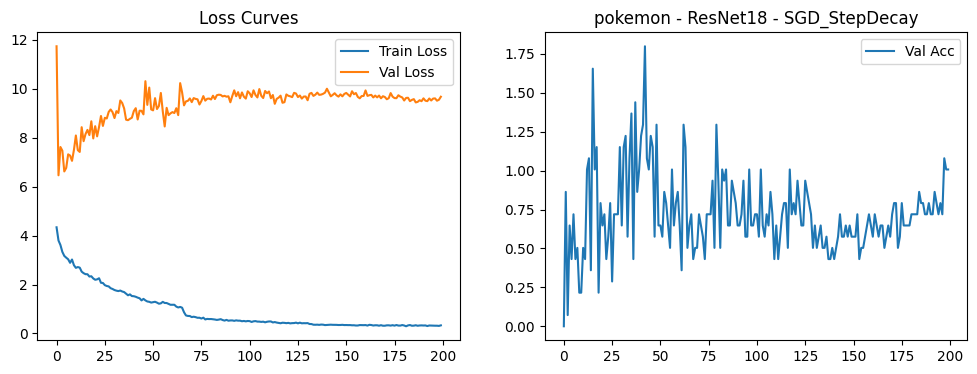


--- Model: ResNet18, Config: SGD_Cosine ---


  0%|          | 1/200 [00:16<55:46, 16.82s/it]

Epoch   1/200 | Train Loss: 1.2754 | Val Loss: 8.4811 | Val Acc: 1.08%


  1%|          | 2/200 [00:34<57:13, 17.34s/it]

Epoch   2/200 | Train Loss: 1.4287 | Val Loss: 9.5645 | Val Acc: 1.08%


  2%|▏         | 3/200 [00:51<56:09, 17.10s/it]

Epoch   3/200 | Train Loss: 1.4913 | Val Loss: 9.2505 | Val Acc: 1.01%


  2%|▏         | 4/200 [01:08<55:45, 17.07s/it]

Epoch   4/200 | Train Loss: 1.3439 | Val Loss: 9.1786 | Val Acc: 1.87%


  2%|▎         | 5/200 [01:25<56:00, 17.23s/it]

Epoch   5/200 | Train Loss: 1.3213 | Val Loss: 9.2970 | Val Acc: 0.22%


  3%|▎         | 6/200 [01:42<55:31, 17.17s/it]

Epoch   6/200 | Train Loss: 1.3234 | Val Loss: 9.0057 | Val Acc: 1.01%


  4%|▎         | 7/200 [01:59<54:42, 17.01s/it]

Epoch   7/200 | Train Loss: 1.2631 | Val Loss: 9.6251 | Val Acc: 0.94%


  4%|▍         | 8/200 [02:16<54:47, 17.12s/it]

Epoch   8/200 | Train Loss: 1.3880 | Val Loss: 8.8617 | Val Acc: 1.15%


  4%|▍         | 9/200 [02:33<54:14, 17.04s/it]

Epoch   9/200 | Train Loss: 1.3532 | Val Loss: 9.1057 | Val Acc: 1.22%


  5%|▌         | 10/200 [02:50<53:50, 17.00s/it]

Epoch  10/200 | Train Loss: 1.2985 | Val Loss: 9.5704 | Val Acc: 0.94%


  6%|▌         | 11/200 [03:08<53:56, 17.13s/it]

Epoch  11/200 | Train Loss: 1.1210 | Val Loss: 9.2126 | Val Acc: 0.86%


  6%|▌         | 12/200 [03:25<53:29, 17.07s/it]

Epoch  12/200 | Train Loss: 1.3193 | Val Loss: 9.3880 | Val Acc: 0.94%


  6%|▋         | 13/200 [03:42<53:11, 17.07s/it]

Epoch  13/200 | Train Loss: 1.1997 | Val Loss: 9.1453 | Val Acc: 1.22%


  7%|▋         | 14/200 [03:59<53:17, 17.19s/it]

Epoch  14/200 | Train Loss: 1.2185 | Val Loss: 9.8022 | Val Acc: 0.86%


  8%|▊         | 15/200 [04:16<52:45, 17.11s/it]

Epoch  15/200 | Train Loss: 1.2388 | Val Loss: 9.9423 | Val Acc: 0.79%


  8%|▊         | 16/200 [04:33<52:31, 17.13s/it]

Epoch  16/200 | Train Loss: 1.1557 | Val Loss: 8.9732 | Val Acc: 0.65%


  8%|▊         | 17/200 [04:50<52:11, 17.11s/it]

Epoch  17/200 | Train Loss: 1.1812 | Val Loss: 9.2860 | Val Acc: 0.36%


  9%|▉         | 18/200 [05:07<51:43, 17.05s/it]

Epoch  18/200 | Train Loss: 1.1044 | Val Loss: 9.0347 | Val Acc: 0.65%


 10%|▉         | 19/200 [05:24<51:33, 17.09s/it]

Epoch  19/200 | Train Loss: 1.1751 | Val Loss: 9.4784 | Val Acc: 0.72%


 10%|█         | 20/200 [05:42<51:23, 17.13s/it]

Epoch  20/200 | Train Loss: 1.0909 | Val Loss: 9.4919 | Val Acc: 0.86%


 10%|█         | 21/200 [05:59<50:59, 17.09s/it]

Epoch  21/200 | Train Loss: 0.9412 | Val Loss: 9.2896 | Val Acc: 0.65%


 11%|█         | 22/200 [06:16<51:07, 17.23s/it]

Epoch  22/200 | Train Loss: 1.0341 | Val Loss: 9.7505 | Val Acc: 0.36%


 12%|█▏        | 23/200 [06:33<50:31, 17.13s/it]

Epoch  23/200 | Train Loss: 1.0091 | Val Loss: 10.1051 | Val Acc: 0.50%


 12%|█▏        | 24/200 [06:50<50:03, 17.07s/it]

Epoch  24/200 | Train Loss: 1.0935 | Val Loss: 8.9176 | Val Acc: 1.08%


 12%|█▎        | 25/200 [07:08<50:20, 17.26s/it]

Epoch  25/200 | Train Loss: 1.0158 | Val Loss: 9.8383 | Val Acc: 0.36%


 13%|█▎        | 26/200 [07:25<49:54, 17.21s/it]

Epoch  26/200 | Train Loss: 0.9954 | Val Loss: 10.0521 | Val Acc: 0.65%


 14%|█▎        | 27/200 [07:42<49:26, 17.15s/it]

Epoch  27/200 | Train Loss: 1.1264 | Val Loss: 9.8368 | Val Acc: 0.58%


 14%|█▍        | 28/200 [07:59<49:32, 17.28s/it]

Epoch  28/200 | Train Loss: 1.1223 | Val Loss: 9.9098 | Val Acc: 1.15%


 14%|█▍        | 29/200 [08:16<48:53, 17.15s/it]

Epoch  29/200 | Train Loss: 1.2150 | Val Loss: 8.4016 | Val Acc: 0.79%


 15%|█▌        | 30/200 [08:33<48:32, 17.13s/it]

Epoch  30/200 | Train Loss: 0.9868 | Val Loss: 10.0358 | Val Acc: 0.43%


 16%|█▌        | 31/200 [08:51<48:39, 17.27s/it]

Epoch  31/200 | Train Loss: 0.9776 | Val Loss: 9.2445 | Val Acc: 1.29%


 16%|█▌        | 32/200 [09:08<48:09, 17.20s/it]

Epoch  32/200 | Train Loss: 0.9894 | Val Loss: 9.3907 | Val Acc: 0.72%


 16%|█▋        | 33/200 [09:25<47:38, 17.12s/it]

Epoch  33/200 | Train Loss: 0.9561 | Val Loss: 9.3803 | Val Acc: 1.01%


 17%|█▋        | 34/200 [09:42<47:33, 17.19s/it]

Epoch  34/200 | Train Loss: 0.8107 | Val Loss: 10.2381 | Val Acc: 0.58%


 18%|█▊        | 35/200 [09:59<47:04, 17.12s/it]

Epoch  35/200 | Train Loss: 0.9700 | Val Loss: 9.4597 | Val Acc: 0.58%


 18%|█▊        | 36/200 [10:16<46:41, 17.08s/it]

Epoch  36/200 | Train Loss: 0.9792 | Val Loss: 9.5051 | Val Acc: 1.08%


 18%|█▊        | 37/200 [10:34<46:35, 17.15s/it]

Epoch  37/200 | Train Loss: 0.8681 | Val Loss: 9.5955 | Val Acc: 0.58%


 19%|█▉        | 38/200 [10:50<46:06, 17.08s/it]

Epoch  38/200 | Train Loss: 0.7723 | Val Loss: 9.1904 | Val Acc: 0.86%


 20%|█▉        | 39/200 [11:07<45:48, 17.07s/it]

Epoch  39/200 | Train Loss: 0.8481 | Val Loss: 9.6003 | Val Acc: 0.50%


 20%|██        | 40/200 [11:25<45:46, 17.16s/it]

Epoch  40/200 | Train Loss: 0.9797 | Val Loss: 9.0596 | Val Acc: 1.22%


 20%|██        | 41/200 [11:42<45:28, 17.16s/it]

Epoch  41/200 | Train Loss: 0.9946 | Val Loss: 10.3012 | Val Acc: 0.94%


 21%|██        | 42/200 [11:59<45:00, 17.09s/it]

Epoch  42/200 | Train Loss: 1.0542 | Val Loss: 9.3759 | Val Acc: 0.72%


 22%|██▏       | 43/200 [12:16<44:54, 17.16s/it]

Epoch  43/200 | Train Loss: 0.8469 | Val Loss: 9.6235 | Val Acc: 0.79%


 22%|██▏       | 44/200 [12:33<44:28, 17.11s/it]

Epoch  44/200 | Train Loss: 0.7972 | Val Loss: 9.4900 | Val Acc: 0.86%


 22%|██▎       | 45/200 [12:50<44:11, 17.11s/it]

Epoch  45/200 | Train Loss: 0.8432 | Val Loss: 9.2116 | Val Acc: 0.43%


 23%|██▎       | 46/200 [13:08<44:06, 17.19s/it]

Epoch  46/200 | Train Loss: 0.9176 | Val Loss: 9.3504 | Val Acc: 1.22%


 24%|██▎       | 47/200 [13:25<43:46, 17.17s/it]

Epoch  47/200 | Train Loss: 0.8596 | Val Loss: 9.0691 | Val Acc: 0.29%


 24%|██▍       | 48/200 [13:42<43:33, 17.19s/it]

Epoch  48/200 | Train Loss: 0.8437 | Val Loss: 9.6336 | Val Acc: 0.58%


 24%|██▍       | 49/200 [13:59<43:23, 17.24s/it]

Epoch  49/200 | Train Loss: 0.7291 | Val Loss: 9.7380 | Val Acc: 0.36%


 25%|██▌       | 50/200 [14:16<42:50, 17.14s/it]

Epoch  50/200 | Train Loss: 0.7632 | Val Loss: 9.4060 | Val Acc: 0.43%


 26%|██▌       | 51/200 [14:34<43:02, 17.33s/it]

Epoch  51/200 | Train Loss: 0.7106 | Val Loss: 9.1406 | Val Acc: 0.94%


 26%|██▌       | 52/200 [14:51<42:24, 17.19s/it]

Epoch  52/200 | Train Loss: 0.6618 | Val Loss: 10.2393 | Val Acc: 0.72%


 26%|██▋       | 53/200 [15:08<41:50, 17.08s/it]

Epoch  53/200 | Train Loss: 0.7608 | Val Loss: 9.6335 | Val Acc: 0.72%


 27%|██▋       | 54/200 [15:26<42:04, 17.29s/it]

Epoch  54/200 | Train Loss: 0.7922 | Val Loss: 9.7874 | Val Acc: 0.58%


 28%|██▊       | 55/200 [15:43<41:35, 17.21s/it]

Epoch  55/200 | Train Loss: 0.8134 | Val Loss: 9.8458 | Val Acc: 0.65%


 28%|██▊       | 56/200 [16:00<41:07, 17.14s/it]

Epoch  56/200 | Train Loss: 0.8131 | Val Loss: 9.7809 | Val Acc: 0.65%


 28%|██▊       | 57/200 [16:17<41:10, 17.27s/it]

Epoch  57/200 | Train Loss: 0.7101 | Val Loss: 9.6681 | Val Acc: 0.22%


 29%|██▉       | 58/200 [16:34<40:31, 17.12s/it]

Epoch  58/200 | Train Loss: 0.7372 | Val Loss: 9.7712 | Val Acc: 0.36%


 30%|██▉       | 59/200 [16:51<40:10, 17.09s/it]

Epoch  59/200 | Train Loss: 0.7434 | Val Loss: 10.0036 | Val Acc: 0.79%


 30%|███       | 60/200 [17:09<40:18, 17.27s/it]

Epoch  60/200 | Train Loss: 0.7321 | Val Loss: 8.7888 | Val Acc: 0.79%


 30%|███       | 61/200 [17:25<39:40, 17.12s/it]

Epoch  61/200 | Train Loss: 0.6561 | Val Loss: 9.4418 | Val Acc: 0.79%


 31%|███       | 62/200 [17:42<39:14, 17.06s/it]

Epoch  62/200 | Train Loss: 0.6612 | Val Loss: 9.9035 | Val Acc: 0.65%


 32%|███▏      | 63/200 [18:00<39:13, 17.18s/it]

Epoch  63/200 | Train Loss: 0.7244 | Val Loss: 9.1038 | Val Acc: 0.86%


 32%|███▏      | 64/200 [18:17<38:48, 17.12s/it]

Epoch  64/200 | Train Loss: 0.7277 | Val Loss: 9.6256 | Val Acc: 0.79%


 32%|███▎      | 65/200 [18:34<38:18, 17.02s/it]

Epoch  65/200 | Train Loss: 0.7287 | Val Loss: 9.3691 | Val Acc: 1.01%


 33%|███▎      | 66/200 [18:51<38:13, 17.11s/it]

Epoch  66/200 | Train Loss: 0.8522 | Val Loss: 9.9086 | Val Acc: 1.58%


 34%|███▎      | 67/200 [19:08<37:46, 17.04s/it]

Epoch  67/200 | Train Loss: 0.8178 | Val Loss: 9.2614 | Val Acc: 1.44%


 34%|███▍      | 68/200 [19:25<37:20, 16.97s/it]

Epoch  68/200 | Train Loss: 0.6514 | Val Loss: 9.1924 | Val Acc: 0.65%


 34%|███▍      | 69/200 [19:42<37:19, 17.10s/it]

Epoch  69/200 | Train Loss: 0.6972 | Val Loss: 9.5800 | Val Acc: 0.72%


 35%|███▌      | 70/200 [19:59<36:50, 17.01s/it]

Epoch  70/200 | Train Loss: 0.6679 | Val Loss: 10.1382 | Val Acc: 0.86%


 36%|███▌      | 71/200 [20:16<36:34, 17.01s/it]

Epoch  71/200 | Train Loss: 0.7800 | Val Loss: 9.4008 | Val Acc: 0.86%


 36%|███▌      | 72/200 [20:33<36:32, 17.13s/it]

Epoch  72/200 | Train Loss: 0.6999 | Val Loss: 9.3013 | Val Acc: 0.36%


 36%|███▋      | 73/200 [20:50<36:11, 17.10s/it]

Epoch  73/200 | Train Loss: 0.6653 | Val Loss: 9.0543 | Val Acc: 0.79%


 37%|███▋      | 74/200 [21:07<35:48, 17.05s/it]

Epoch  74/200 | Train Loss: 0.6609 | Val Loss: 9.2299 | Val Acc: 0.65%


 38%|███▊      | 75/200 [21:24<35:38, 17.11s/it]

Epoch  75/200 | Train Loss: 0.5899 | Val Loss: 9.3177 | Val Acc: 0.58%


 38%|███▊      | 76/200 [21:41<35:16, 17.07s/it]

Epoch  76/200 | Train Loss: 0.8277 | Val Loss: 8.9950 | Val Acc: 0.94%


 38%|███▊      | 77/200 [21:58<34:55, 17.03s/it]

Epoch  77/200 | Train Loss: 0.6025 | Val Loss: 9.2904 | Val Acc: 1.44%


 39%|███▉      | 78/200 [22:15<34:42, 17.07s/it]

Epoch  78/200 | Train Loss: 0.6568 | Val Loss: 9.1131 | Val Acc: 1.01%


 40%|███▉      | 79/200 [22:32<34:19, 17.02s/it]

Epoch  79/200 | Train Loss: 0.7259 | Val Loss: 9.6811 | Val Acc: 0.65%


 40%|████      | 80/200 [22:50<34:10, 17.08s/it]

Epoch  80/200 | Train Loss: 0.5793 | Val Loss: 9.4341 | Val Acc: 0.94%


 40%|████      | 81/200 [23:07<34:02, 17.16s/it]

Epoch  81/200 | Train Loss: 0.4972 | Val Loss: 9.9075 | Val Acc: 0.43%


 41%|████      | 82/200 [23:24<33:46, 17.17s/it]

Epoch  82/200 | Train Loss: 0.5802 | Val Loss: 9.0330 | Val Acc: 0.79%


 42%|████▏     | 83/200 [23:42<33:48, 17.34s/it]

Epoch  83/200 | Train Loss: 0.6012 | Val Loss: 9.5862 | Val Acc: 0.36%


 42%|████▏     | 84/200 [23:59<33:20, 17.25s/it]

Epoch  84/200 | Train Loss: 0.5666 | Val Loss: 9.6399 | Val Acc: 0.72%


 42%|████▎     | 85/200 [24:16<32:51, 17.14s/it]

Epoch  85/200 | Train Loss: 0.7361 | Val Loss: 9.5758 | Val Acc: 0.36%


 43%|████▎     | 86/200 [24:34<32:57, 17.34s/it]

Epoch  86/200 | Train Loss: 0.6260 | Val Loss: 9.1846 | Val Acc: 0.58%


 44%|████▎     | 87/200 [24:51<32:23, 17.20s/it]

Epoch  87/200 | Train Loss: 0.5954 | Val Loss: 9.8990 | Val Acc: 0.65%


 44%|████▍     | 88/200 [25:07<31:55, 17.11s/it]

Epoch  88/200 | Train Loss: 0.5754 | Val Loss: 9.5383 | Val Acc: 0.43%


 44%|████▍     | 89/200 [25:25<31:57, 17.27s/it]

Epoch  89/200 | Train Loss: 0.6273 | Val Loss: 10.1575 | Val Acc: 0.58%


 45%|████▌     | 90/200 [25:42<31:28, 17.17s/it]

Epoch  90/200 | Train Loss: 0.6090 | Val Loss: 9.3654 | Val Acc: 0.58%


 46%|████▌     | 91/200 [25:59<31:03, 17.09s/it]

Epoch  91/200 | Train Loss: 0.5448 | Val Loss: 10.0254 | Val Acc: 0.36%


 46%|████▌     | 92/200 [26:16<31:00, 17.23s/it]

Epoch  92/200 | Train Loss: 0.5152 | Val Loss: 9.0537 | Val Acc: 0.94%


 46%|████▋     | 93/200 [26:33<30:35, 17.15s/it]

Epoch  93/200 | Train Loss: 0.4722 | Val Loss: 9.1214 | Val Acc: 0.50%


 47%|████▋     | 94/200 [26:50<30:13, 17.11s/it]

Epoch  94/200 | Train Loss: 0.4760 | Val Loss: 9.4695 | Val Acc: 0.94%


 48%|████▊     | 95/200 [27:08<30:06, 17.21s/it]

Epoch  95/200 | Train Loss: 0.6156 | Val Loss: 9.8084 | Val Acc: 0.43%


 48%|████▊     | 96/200 [27:25<29:43, 17.15s/it]

Epoch  96/200 | Train Loss: 0.4628 | Val Loss: 9.5569 | Val Acc: 0.50%


 48%|████▊     | 97/200 [27:42<29:16, 17.06s/it]

Epoch  97/200 | Train Loss: 0.4297 | Val Loss: 9.4502 | Val Acc: 0.50%


 49%|████▉     | 98/200 [27:59<29:18, 17.24s/it]

Epoch  98/200 | Train Loss: 0.4659 | Val Loss: 9.5658 | Val Acc: 0.29%


 50%|████▉     | 99/200 [28:16<28:50, 17.13s/it]

Epoch  99/200 | Train Loss: 0.4476 | Val Loss: 9.7985 | Val Acc: 0.50%


 50%|█████     | 100/200 [28:33<28:27, 17.07s/it]

Epoch 100/200 | Train Loss: 0.3997 | Val Loss: 10.0694 | Val Acc: 0.43%


 50%|█████     | 101/200 [28:51<28:23, 17.21s/it]

Epoch 101/200 | Train Loss: 0.4687 | Val Loss: 9.5743 | Val Acc: 0.50%


 51%|█████     | 102/200 [29:08<27:55, 17.10s/it]

Epoch 102/200 | Train Loss: 0.4347 | Val Loss: 9.2154 | Val Acc: 0.72%


 52%|█████▏    | 103/200 [29:24<27:28, 17.00s/it]

Epoch 103/200 | Train Loss: 0.4810 | Val Loss: 9.8483 | Val Acc: 0.43%


 52%|█████▏    | 104/200 [29:42<27:26, 17.15s/it]

Epoch 104/200 | Train Loss: 0.4581 | Val Loss: 9.4602 | Val Acc: 0.50%


 52%|█████▎    | 105/200 [29:59<27:06, 17.13s/it]

Epoch 105/200 | Train Loss: 0.4192 | Val Loss: 9.0754 | Val Acc: 1.08%


 53%|█████▎    | 106/200 [30:16<26:44, 17.07s/it]

Epoch 106/200 | Train Loss: 0.6403 | Val Loss: 10.0671 | Val Acc: 0.94%


 54%|█████▎    | 107/200 [30:33<26:41, 17.22s/it]

Epoch 107/200 | Train Loss: 0.4579 | Val Loss: 9.3810 | Val Acc: 0.50%


 54%|█████▍    | 108/200 [30:50<26:14, 17.11s/it]

Epoch 108/200 | Train Loss: 0.4122 | Val Loss: 9.0153 | Val Acc: 0.72%


 55%|█████▍    | 109/200 [31:07<25:50, 17.04s/it]

Epoch 109/200 | Train Loss: 0.4955 | Val Loss: 9.5053 | Val Acc: 0.79%


 55%|█████▌    | 110/200 [31:25<25:46, 17.18s/it]

Epoch 110/200 | Train Loss: 0.3760 | Val Loss: 9.2350 | Val Acc: 0.86%


 56%|█████▌    | 111/200 [31:42<25:20, 17.08s/it]

Epoch 111/200 | Train Loss: 0.4285 | Val Loss: 9.9928 | Val Acc: 0.58%


 56%|█████▌    | 112/200 [31:58<24:59, 17.04s/it]

Epoch 112/200 | Train Loss: 0.4132 | Val Loss: 9.3776 | Val Acc: 0.43%


 56%|█████▋    | 113/200 [32:16<24:48, 17.11s/it]

Epoch 113/200 | Train Loss: 0.4172 | Val Loss: 9.4607 | Val Acc: 0.86%


 57%|█████▋    | 114/200 [32:33<24:23, 17.01s/it]

Epoch 114/200 | Train Loss: 0.3692 | Val Loss: 9.3315 | Val Acc: 0.72%


 57%|█████▊    | 115/200 [32:49<24:02, 16.97s/it]

Epoch 115/200 | Train Loss: 0.4094 | Val Loss: 9.0408 | Val Acc: 0.72%


 58%|█████▊    | 116/200 [33:07<23:55, 17.09s/it]

Epoch 116/200 | Train Loss: 0.4564 | Val Loss: 9.4128 | Val Acc: 0.58%


 58%|█████▊    | 117/200 [33:24<23:33, 17.03s/it]

Epoch 117/200 | Train Loss: 0.4035 | Val Loss: 9.2944 | Val Acc: 1.01%


 59%|█████▉    | 118/200 [33:40<23:10, 16.96s/it]

Epoch 118/200 | Train Loss: 0.4524 | Val Loss: 9.5519 | Val Acc: 0.86%


 60%|█████▉    | 119/200 [33:58<23:00, 17.04s/it]

Epoch 119/200 | Train Loss: 0.4435 | Val Loss: 9.1132 | Val Acc: 0.86%


 60%|██████    | 120/200 [34:15<22:43, 17.05s/it]

Epoch 120/200 | Train Loss: 0.4212 | Val Loss: 9.5976 | Val Acc: 1.01%


 60%|██████    | 121/200 [34:32<22:22, 16.99s/it]

Epoch 121/200 | Train Loss: 0.4645 | Val Loss: 9.2182 | Val Acc: 0.72%


 61%|██████    | 122/200 [34:49<22:14, 17.11s/it]

Epoch 122/200 | Train Loss: 0.3367 | Val Loss: 9.2361 | Val Acc: 0.79%


 62%|██████▏   | 123/200 [35:06<21:50, 17.02s/it]

Epoch 123/200 | Train Loss: 0.3076 | Val Loss: 9.5862 | Val Acc: 0.79%


 62%|██████▏   | 124/200 [35:23<21:29, 16.97s/it]

Epoch 124/200 | Train Loss: 0.2908 | Val Loss: 9.2853 | Val Acc: 0.58%


 62%|██████▎   | 125/200 [35:40<21:21, 17.08s/it]

Epoch 125/200 | Train Loss: 0.3221 | Val Loss: 9.4073 | Val Acc: 1.01%


 63%|██████▎   | 126/200 [35:57<21:00, 17.04s/it]

Epoch 126/200 | Train Loss: 0.3400 | Val Loss: 9.6179 | Val Acc: 0.50%


 64%|██████▎   | 127/200 [36:14<20:41, 17.00s/it]

Epoch 127/200 | Train Loss: 0.3853 | Val Loss: 9.6472 | Val Acc: 0.43%


 64%|██████▍   | 128/200 [36:31<20:34, 17.15s/it]

Epoch 128/200 | Train Loss: 0.4041 | Val Loss: 9.3230 | Val Acc: 0.58%


 64%|██████▍   | 129/200 [36:48<20:11, 17.06s/it]

Epoch 129/200 | Train Loss: 0.3789 | Val Loss: 9.1282 | Val Acc: 0.58%


 65%|██████▌   | 130/200 [37:05<19:50, 17.01s/it]

Epoch 130/200 | Train Loss: 0.3726 | Val Loss: 9.3513 | Val Acc: 0.58%


 66%|██████▌   | 131/200 [37:22<19:37, 17.06s/it]

Epoch 131/200 | Train Loss: 0.4082 | Val Loss: 9.5277 | Val Acc: 0.65%


 66%|██████▌   | 132/200 [37:39<19:20, 17.07s/it]

Epoch 132/200 | Train Loss: 0.3521 | Val Loss: 9.1373 | Val Acc: 0.94%


 66%|██████▋   | 133/200 [37:57<19:05, 17.10s/it]

Epoch 133/200 | Train Loss: 0.3485 | Val Loss: 9.4504 | Val Acc: 1.01%


 67%|██████▋   | 134/200 [38:14<18:48, 17.09s/it]

Epoch 134/200 | Train Loss: 0.3533 | Val Loss: 8.9972 | Val Acc: 0.86%


 68%|██████▊   | 135/200 [38:31<18:28, 17.06s/it]

Epoch 135/200 | Train Loss: 0.3553 | Val Loss: 9.4109 | Val Acc: 0.65%


 68%|██████▊   | 136/200 [38:48<18:19, 17.17s/it]

Epoch 136/200 | Train Loss: 0.3409 | Val Loss: 9.3623 | Val Acc: 0.65%


 68%|██████▊   | 137/200 [39:05<17:59, 17.14s/it]

Epoch 137/200 | Train Loss: 0.3626 | Val Loss: 9.3048 | Val Acc: 0.50%


 69%|██████▉   | 138/200 [39:22<17:37, 17.06s/it]

Epoch 138/200 | Train Loss: 0.2851 | Val Loss: 9.2906 | Val Acc: 0.58%


 70%|██████▉   | 139/200 [39:40<17:34, 17.29s/it]

Epoch 139/200 | Train Loss: 0.2702 | Val Loss: 9.0781 | Val Acc: 0.65%


 70%|███████   | 140/200 [39:56<17:06, 17.11s/it]

Epoch 140/200 | Train Loss: 0.3095 | Val Loss: 9.2744 | Val Acc: 0.50%


 70%|███████   | 141/200 [40:13<16:48, 17.09s/it]

Epoch 141/200 | Train Loss: 0.3539 | Val Loss: 9.3326 | Val Acc: 0.43%


 71%|███████   | 142/200 [40:31<16:38, 17.21s/it]

Epoch 142/200 | Train Loss: 0.2824 | Val Loss: 9.0744 | Val Acc: 0.50%


 72%|███████▏  | 143/200 [40:48<16:16, 17.13s/it]

Epoch 143/200 | Train Loss: 0.2773 | Val Loss: 8.9798 | Val Acc: 0.65%


 72%|███████▏  | 144/200 [41:05<15:57, 17.10s/it]

Epoch 144/200 | Train Loss: 0.2850 | Val Loss: 9.0337 | Val Acc: 0.65%


 72%|███████▎  | 145/200 [41:22<15:44, 17.18s/it]

Epoch 145/200 | Train Loss: 0.2689 | Val Loss: 8.9656 | Val Acc: 0.79%


 73%|███████▎  | 146/200 [41:39<15:21, 17.06s/it]

Epoch 146/200 | Train Loss: 0.2690 | Val Loss: 9.0208 | Val Acc: 1.22%


 74%|███████▎  | 147/200 [41:56<15:02, 17.03s/it]

Epoch 147/200 | Train Loss: 0.2608 | Val Loss: 9.1384 | Val Acc: 0.58%


 74%|███████▍  | 148/200 [42:13<14:50, 17.13s/it]

Epoch 148/200 | Train Loss: 0.2902 | Val Loss: 9.1928 | Val Acc: 0.50%


 74%|███████▍  | 149/200 [42:30<14:29, 17.05s/it]

Epoch 149/200 | Train Loss: 0.2703 | Val Loss: 9.0068 | Val Acc: 0.58%


 75%|███████▌  | 150/200 [42:47<14:12, 17.06s/it]

Epoch 150/200 | Train Loss: 0.2661 | Val Loss: 9.1816 | Val Acc: 0.65%


 76%|███████▌  | 151/200 [43:05<14:00, 17.15s/it]

Epoch 151/200 | Train Loss: 0.2667 | Val Loss: 9.0092 | Val Acc: 0.72%


 76%|███████▌  | 152/200 [43:22<13:39, 17.08s/it]

Epoch 152/200 | Train Loss: 0.2587 | Val Loss: 9.2582 | Val Acc: 0.58%


 76%|███████▋  | 153/200 [43:39<13:20, 17.04s/it]

Epoch 153/200 | Train Loss: 0.2661 | Val Loss: 9.1133 | Val Acc: 0.43%


 77%|███████▋  | 154/200 [43:56<13:09, 17.17s/it]

Epoch 154/200 | Train Loss: 0.2318 | Val Loss: 8.8632 | Val Acc: 0.50%


 78%|███████▊  | 155/200 [44:13<12:50, 17.13s/it]

Epoch 155/200 | Train Loss: 0.2489 | Val Loss: 9.0192 | Val Acc: 0.65%


 78%|███████▊  | 156/200 [44:30<12:31, 17.08s/it]

Epoch 156/200 | Train Loss: 0.2317 | Val Loss: 8.9517 | Val Acc: 0.79%


 78%|███████▊  | 157/200 [44:47<12:18, 17.18s/it]

Epoch 157/200 | Train Loss: 0.2060 | Val Loss: 8.9828 | Val Acc: 0.65%


 79%|███████▉  | 158/200 [45:04<11:58, 17.10s/it]

Epoch 158/200 | Train Loss: 0.2335 | Val Loss: 8.8576 | Val Acc: 0.86%


 80%|███████▉  | 159/200 [45:22<11:46, 17.24s/it]

Epoch 159/200 | Train Loss: 0.2339 | Val Loss: 8.8065 | Val Acc: 0.86%


 80%|████████  | 160/200 [45:39<11:27, 17.19s/it]

Epoch 160/200 | Train Loss: 0.2506 | Val Loss: 9.0018 | Val Acc: 0.58%


 80%|████████  | 161/200 [45:56<11:05, 17.08s/it]

Epoch 161/200 | Train Loss: 0.1962 | Val Loss: 9.2302 | Val Acc: 0.65%


 81%|████████  | 162/200 [46:14<10:57, 17.29s/it]

Epoch 162/200 | Train Loss: 0.2209 | Val Loss: 8.9926 | Val Acc: 0.50%


 82%|████████▏ | 163/200 [46:31<10:36, 17.19s/it]

Epoch 163/200 | Train Loss: 0.2000 | Val Loss: 8.9591 | Val Acc: 0.65%


 82%|████████▏ | 164/200 [46:48<10:15, 17.10s/it]

Epoch 164/200 | Train Loss: 0.2110 | Val Loss: 9.0387 | Val Acc: 0.65%


 82%|████████▎ | 165/200 [47:05<10:07, 17.37s/it]

Epoch 165/200 | Train Loss: 0.1960 | Val Loss: 8.8135 | Val Acc: 0.72%


 83%|████████▎ | 166/200 [47:22<09:44, 17.19s/it]

Epoch 166/200 | Train Loss: 0.2009 | Val Loss: 8.9404 | Val Acc: 0.43%


 84%|████████▎ | 167/200 [47:39<09:25, 17.12s/it]

Epoch 167/200 | Train Loss: 0.1906 | Val Loss: 8.9496 | Val Acc: 0.65%


 84%|████████▍ | 168/200 [47:57<09:11, 17.23s/it]

Epoch 168/200 | Train Loss: 0.1992 | Val Loss: 9.0231 | Val Acc: 0.50%


 84%|████████▍ | 169/200 [48:14<08:51, 17.15s/it]

Epoch 169/200 | Train Loss: 0.1897 | Val Loss: 8.8432 | Val Acc: 0.50%


 85%|████████▌ | 170/200 [48:31<08:32, 17.09s/it]

Epoch 170/200 | Train Loss: 0.1866 | Val Loss: 8.9618 | Val Acc: 0.65%


 86%|████████▌ | 171/200 [48:48<08:21, 17.29s/it]

Epoch 171/200 | Train Loss: 0.2011 | Val Loss: 8.8654 | Val Acc: 0.86%


 86%|████████▌ | 172/200 [49:05<08:00, 17.17s/it]

Epoch 172/200 | Train Loss: 0.1889 | Val Loss: 8.8681 | Val Acc: 0.58%


 86%|████████▋ | 173/200 [49:22<07:42, 17.11s/it]

Epoch 173/200 | Train Loss: 0.1988 | Val Loss: 8.8284 | Val Acc: 0.72%


 87%|████████▋ | 174/200 [49:40<07:27, 17.22s/it]

Epoch 174/200 | Train Loss: 0.1863 | Val Loss: 8.8548 | Val Acc: 0.72%


 88%|████████▊ | 175/200 [49:57<07:07, 17.11s/it]

Epoch 175/200 | Train Loss: 0.1801 | Val Loss: 8.9165 | Val Acc: 0.65%


 88%|████████▊ | 176/200 [50:13<06:48, 17.02s/it]

Epoch 176/200 | Train Loss: 0.1903 | Val Loss: 9.0492 | Val Acc: 0.50%


 88%|████████▊ | 177/200 [50:31<06:34, 17.14s/it]

Epoch 177/200 | Train Loss: 0.1812 | Val Loss: 8.8933 | Val Acc: 0.43%


 89%|████████▉ | 178/200 [50:48<06:16, 17.12s/it]

Epoch 178/200 | Train Loss: 0.1772 | Val Loss: 8.9119 | Val Acc: 0.50%


 90%|████████▉ | 179/200 [51:05<05:58, 17.09s/it]

Epoch 179/200 | Train Loss: 0.1725 | Val Loss: 8.9339 | Val Acc: 0.50%


 90%|█████████ | 180/200 [51:22<05:43, 17.16s/it]

Epoch 180/200 | Train Loss: 0.1854 | Val Loss: 8.8346 | Val Acc: 0.65%


 90%|█████████ | 181/200 [51:39<05:25, 17.11s/it]

Epoch 181/200 | Train Loss: 0.1835 | Val Loss: 8.7955 | Val Acc: 0.79%


 91%|█████████ | 182/200 [51:56<05:06, 17.02s/it]

Epoch 182/200 | Train Loss: 0.1651 | Val Loss: 8.8112 | Val Acc: 0.50%


 92%|█████████▏| 183/200 [52:13<04:50, 17.08s/it]

Epoch 183/200 | Train Loss: 0.1746 | Val Loss: 8.8979 | Val Acc: 0.65%


 92%|█████████▏| 184/200 [52:30<04:31, 16.98s/it]

Epoch 184/200 | Train Loss: 0.1835 | Val Loss: 8.9526 | Val Acc: 0.58%


 92%|█████████▎| 185/200 [52:47<04:14, 16.96s/it]

Epoch 185/200 | Train Loss: 0.1686 | Val Loss: 8.9355 | Val Acc: 0.50%


 93%|█████████▎| 186/200 [53:04<03:58, 17.06s/it]

Epoch 186/200 | Train Loss: 0.1711 | Val Loss: 8.9480 | Val Acc: 0.65%


 94%|█████████▎| 187/200 [53:21<03:41, 17.00s/it]

Epoch 187/200 | Train Loss: 0.1630 | Val Loss: 8.9373 | Val Acc: 0.58%


 94%|█████████▍| 188/200 [53:38<03:24, 17.03s/it]

Epoch 188/200 | Train Loss: 0.1600 | Val Loss: 8.8941 | Val Acc: 0.50%


 94%|█████████▍| 189/200 [53:55<03:08, 17.10s/it]

Epoch 189/200 | Train Loss: 0.1601 | Val Loss: 8.9043 | Val Acc: 0.58%


 95%|█████████▌| 190/200 [54:12<02:50, 17.04s/it]

Epoch 190/200 | Train Loss: 0.1709 | Val Loss: 8.8191 | Val Acc: 0.58%


 96%|█████████▌| 191/200 [54:29<02:33, 17.00s/it]

Epoch 191/200 | Train Loss: 0.1708 | Val Loss: 8.9145 | Val Acc: 0.58%


 96%|█████████▌| 192/200 [54:46<02:16, 17.05s/it]

Epoch 192/200 | Train Loss: 0.1724 | Val Loss: 9.0255 | Val Acc: 0.50%


 96%|█████████▋| 193/200 [55:03<01:59, 17.02s/it]

Epoch 193/200 | Train Loss: 0.1694 | Val Loss: 8.8129 | Val Acc: 0.58%


 97%|█████████▋| 194/200 [55:21<01:42, 17.14s/it]

Epoch 194/200 | Train Loss: 0.1740 | Val Loss: 8.8584 | Val Acc: 0.58%


 98%|█████████▊| 195/200 [55:38<01:25, 17.13s/it]

Epoch 195/200 | Train Loss: 0.1698 | Val Loss: 8.8435 | Val Acc: 0.65%


 98%|█████████▊| 196/200 [55:55<01:08, 17.05s/it]

Epoch 196/200 | Train Loss: 0.1591 | Val Loss: 8.8280 | Val Acc: 0.65%


 98%|█████████▊| 197/200 [56:12<00:51, 17.09s/it]

Epoch 197/200 | Train Loss: 0.1739 | Val Loss: 8.9229 | Val Acc: 0.50%


 99%|█████████▉| 198/200 [56:29<00:34, 17.08s/it]

Epoch 198/200 | Train Loss: 0.1560 | Val Loss: 8.8870 | Val Acc: 0.58%


100%|█████████▉| 199/200 [56:46<00:17, 17.06s/it]

Epoch 199/200 | Train Loss: 0.1547 | Val Loss: 8.9371 | Val Acc: 0.50%


100%|██████████| 200/200 [57:04<00:00, 17.12s/it]

Epoch 200/200 | Train Loss: 0.1678 | Val Loss: 8.8772 | Val Acc: 0.58%


FINAL TEST ACCURACY: 2.19%



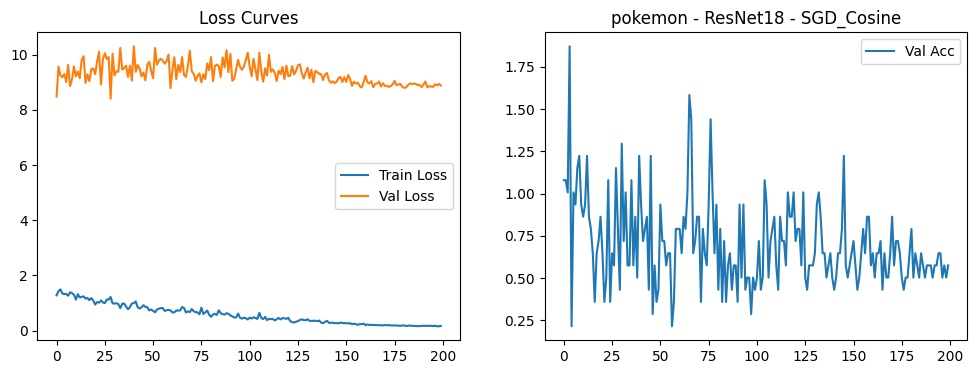


--- Model: ResNet18, Config: Adam_NoReg ---


  1%|          | 1/100 [00:17<28:15, 17.13s/it]

Epoch   1/100 | Train Loss: 1.4752 | Val Loss: 9.2891 | Val Acc: 0.65%


  2%|▏         | 2/100 [00:34<28:04, 17.19s/it]

Epoch   2/100 | Train Loss: 1.3455 | Val Loss: 8.8354 | Val Acc: 1.01%


  3%|▎         | 3/100 [00:51<27:53, 17.25s/it]

Epoch   3/100 | Train Loss: 1.2523 | Val Loss: 9.5226 | Val Acc: 1.01%


  4%|▍         | 4/100 [01:08<27:30, 17.19s/it]

Epoch   4/100 | Train Loss: 1.2296 | Val Loss: 10.4894 | Val Acc: 0.58%


  5%|▌         | 5/100 [01:26<27:18, 17.25s/it]

Epoch   5/100 | Train Loss: 1.1975 | Val Loss: 10.5037 | Val Acc: 0.43%


  6%|▌         | 6/100 [01:43<27:05, 17.29s/it]

Epoch   6/100 | Train Loss: 1.1485 | Val Loss: 9.6151 | Val Acc: 0.79%


  7%|▋         | 7/100 [02:00<26:33, 17.13s/it]

Epoch   7/100 | Train Loss: 1.2199 | Val Loss: 9.7523 | Val Acc: 0.72%


  8%|▊         | 8/100 [02:18<26:39, 17.38s/it]

Epoch   8/100 | Train Loss: 1.0729 | Val Loss: 9.6485 | Val Acc: 1.08%


  9%|▉         | 9/100 [02:35<26:11, 17.27s/it]

Epoch   9/100 | Train Loss: 1.0781 | Val Loss: 9.9592 | Val Acc: 0.29%


 10%|█         | 10/100 [02:52<25:45, 17.18s/it]

Epoch  10/100 | Train Loss: 0.9823 | Val Loss: 10.4640 | Val Acc: 0.22%


 11%|█         | 11/100 [03:09<25:38, 17.29s/it]

Epoch  11/100 | Train Loss: 1.0170 | Val Loss: 10.1052 | Val Acc: 0.58%


 12%|█▏        | 12/100 [03:26<25:13, 17.20s/it]

Epoch  12/100 | Train Loss: 1.0473 | Val Loss: 10.8584 | Val Acc: 0.94%


 13%|█▎        | 13/100 [03:43<24:50, 17.13s/it]

Epoch  13/100 | Train Loss: 1.0078 | Val Loss: 10.1538 | Val Acc: 0.58%


 14%|█▍        | 14/100 [04:01<24:38, 17.20s/it]

Epoch  14/100 | Train Loss: 0.9290 | Val Loss: 10.8528 | Val Acc: 1.08%


 15%|█▌        | 15/100 [04:18<24:14, 17.11s/it]

Epoch  15/100 | Train Loss: 0.9533 | Val Loss: 9.4105 | Val Acc: 0.65%


 16%|█▌        | 16/100 [04:35<23:55, 17.08s/it]

Epoch  16/100 | Train Loss: 0.9833 | Val Loss: 10.6928 | Val Acc: 0.43%


 17%|█▋        | 17/100 [04:52<23:46, 17.19s/it]

Epoch  17/100 | Train Loss: 0.9533 | Val Loss: 10.0557 | Val Acc: 0.72%


 18%|█▊        | 18/100 [05:09<23:24, 17.13s/it]

Epoch  18/100 | Train Loss: 0.9160 | Val Loss: 10.4250 | Val Acc: 0.50%


 19%|█▉        | 19/100 [05:26<23:09, 17.15s/it]

Epoch  19/100 | Train Loss: 0.8647 | Val Loss: 10.5326 | Val Acc: 0.86%


 20%|██        | 20/100 [05:43<22:50, 17.14s/it]

Epoch  20/100 | Train Loss: 0.8415 | Val Loss: 10.5277 | Val Acc: 0.58%


 21%|██        | 21/100 [06:00<22:29, 17.08s/it]

Epoch  21/100 | Train Loss: 0.7857 | Val Loss: 10.4893 | Val Acc: 0.72%


 22%|██▏       | 22/100 [06:18<22:23, 17.22s/it]

Epoch  22/100 | Train Loss: 0.8065 | Val Loss: 10.6079 | Val Acc: 0.79%


 23%|██▎       | 23/100 [06:35<22:00, 17.15s/it]

Epoch  23/100 | Train Loss: 0.7537 | Val Loss: 10.4385 | Val Acc: 0.86%


 24%|██▍       | 24/100 [06:52<21:41, 17.12s/it]

Epoch  24/100 | Train Loss: 0.8489 | Val Loss: 10.9382 | Val Acc: 0.58%


 25%|██▌       | 25/100 [07:10<21:42, 17.36s/it]

Epoch  25/100 | Train Loss: 0.7179 | Val Loss: 10.5443 | Val Acc: 0.79%


 26%|██▌       | 26/100 [07:27<21:13, 17.21s/it]

Epoch  26/100 | Train Loss: 0.6507 | Val Loss: 10.4142 | Val Acc: 0.72%


 27%|██▋       | 27/100 [07:44<20:51, 17.15s/it]

Epoch  27/100 | Train Loss: 0.7141 | Val Loss: 11.1907 | Val Acc: 0.72%


 28%|██▊       | 28/100 [08:01<20:42, 17.25s/it]

Epoch  28/100 | Train Loss: 0.6831 | Val Loss: 11.1769 | Val Acc: 0.72%


 29%|██▉       | 29/100 [08:18<20:20, 17.19s/it]

Epoch  29/100 | Train Loss: 0.7789 | Val Loss: 11.1820 | Val Acc: 0.94%


 30%|███       | 30/100 [08:35<19:57, 17.11s/it]

Epoch  30/100 | Train Loss: 0.6703 | Val Loss: 10.8058 | Val Acc: 0.43%


 31%|███       | 31/100 [08:52<19:45, 17.18s/it]

Epoch  31/100 | Train Loss: 0.6432 | Val Loss: 10.9296 | Val Acc: 0.94%


 32%|███▏      | 32/100 [09:09<19:26, 17.15s/it]

Epoch  32/100 | Train Loss: 0.6436 | Val Loss: 10.8932 | Val Acc: 0.58%


 33%|███▎      | 33/100 [09:27<19:07, 17.12s/it]

Epoch  33/100 | Train Loss: 0.6847 | Val Loss: 10.6547 | Val Acc: 0.50%


 34%|███▍      | 34/100 [09:44<18:55, 17.20s/it]

Epoch  34/100 | Train Loss: 0.6562 | Val Loss: 11.3005 | Val Acc: 0.50%


 35%|███▌      | 35/100 [10:01<18:30, 17.09s/it]

Epoch  35/100 | Train Loss: 0.6173 | Val Loss: 10.9989 | Val Acc: 0.50%


 36%|███▌      | 36/100 [10:18<18:13, 17.09s/it]

Epoch  36/100 | Train Loss: 0.6714 | Val Loss: 11.2119 | Val Acc: 0.65%


 37%|███▋      | 37/100 [10:35<18:00, 17.14s/it]

Epoch  37/100 | Train Loss: 0.6955 | Val Loss: 11.2969 | Val Acc: 0.79%


 38%|███▊      | 38/100 [10:52<17:42, 17.14s/it]

Epoch  38/100 | Train Loss: 0.6464 | Val Loss: 10.5933 | Val Acc: 0.58%


 39%|███▉      | 39/100 [11:10<17:32, 17.25s/it]

Epoch  39/100 | Train Loss: 0.5906 | Val Loss: 11.7674 | Val Acc: 0.50%


 40%|████      | 40/100 [11:27<17:13, 17.23s/it]

Epoch  40/100 | Train Loss: 0.5580 | Val Loss: 11.1164 | Val Acc: 0.72%


 41%|████      | 41/100 [11:44<16:50, 17.13s/it]

Epoch  41/100 | Train Loss: 0.6327 | Val Loss: 10.9053 | Val Acc: 0.72%


 42%|████▏     | 42/100 [12:01<16:37, 17.20s/it]

Epoch  42/100 | Train Loss: 0.5826 | Val Loss: 11.3866 | Val Acc: 0.86%


 43%|████▎     | 43/100 [12:18<16:17, 17.15s/it]

Epoch  43/100 | Train Loss: 0.6380 | Val Loss: 11.3913 | Val Acc: 0.50%


 44%|████▍     | 44/100 [12:35<16:00, 17.15s/it]

Epoch  44/100 | Train Loss: 0.5383 | Val Loss: 11.5448 | Val Acc: 0.50%


 45%|████▌     | 45/100 [12:53<15:54, 17.35s/it]

Epoch  45/100 | Train Loss: 0.6146 | Val Loss: 10.9842 | Val Acc: 0.94%


 46%|████▌     | 46/100 [13:10<15:31, 17.25s/it]

Epoch  46/100 | Train Loss: 0.6525 | Val Loss: 11.7358 | Val Acc: 0.50%


 47%|████▋     | 47/100 [13:27<15:12, 17.22s/it]

Epoch  47/100 | Train Loss: 0.5969 | Val Loss: 11.1486 | Val Acc: 0.79%


 48%|████▊     | 48/100 [13:45<15:01, 17.34s/it]

Epoch  48/100 | Train Loss: 0.6034 | Val Loss: 11.1692 | Val Acc: 1.15%


 49%|████▉     | 49/100 [14:02<14:38, 17.23s/it]

Epoch  49/100 | Train Loss: 0.6444 | Val Loss: 11.0064 | Val Acc: 0.43%


 50%|█████     | 50/100 [14:19<14:16, 17.14s/it]

Epoch  50/100 | Train Loss: 0.5412 | Val Loss: 11.0537 | Val Acc: 0.72%


 51%|█████     | 51/100 [14:36<14:00, 17.16s/it]

Epoch  51/100 | Train Loss: 0.5138 | Val Loss: 10.9559 | Val Acc: 0.43%


 52%|█████▏    | 52/100 [14:53<13:42, 17.13s/it]

Epoch  52/100 | Train Loss: 0.4874 | Val Loss: 11.1789 | Val Acc: 1.01%


 53%|█████▎    | 53/100 [15:10<13:21, 17.05s/it]

Epoch  53/100 | Train Loss: 0.5787 | Val Loss: 12.1271 | Val Acc: 0.29%


 54%|█████▍    | 54/100 [15:27<13:08, 17.15s/it]

Epoch  54/100 | Train Loss: 0.5627 | Val Loss: 11.1175 | Val Acc: 0.65%


 55%|█████▌    | 55/100 [15:44<12:50, 17.13s/it]

Epoch  55/100 | Train Loss: 0.5230 | Val Loss: 11.5517 | Val Acc: 0.29%


 56%|█████▌    | 56/100 [16:02<12:37, 17.20s/it]

Epoch  56/100 | Train Loss: 0.5288 | Val Loss: 11.3737 | Val Acc: 0.79%


 57%|█████▋    | 57/100 [16:19<12:22, 17.27s/it]

Epoch  57/100 | Train Loss: 0.4990 | Val Loss: 11.3396 | Val Acc: 0.79%


 58%|█████▊    | 58/100 [16:36<12:00, 17.16s/it]

Epoch  58/100 | Train Loss: 0.4408 | Val Loss: 11.6219 | Val Acc: 0.58%


 59%|█████▉    | 59/100 [16:54<11:48, 17.29s/it]

Epoch  59/100 | Train Loss: 0.4571 | Val Loss: 11.3201 | Val Acc: 0.43%


 60%|██████    | 60/100 [17:11<11:29, 17.25s/it]

Epoch  60/100 | Train Loss: 0.4787 | Val Loss: 11.8246 | Val Acc: 0.58%


 61%|██████    | 61/100 [17:28<11:09, 17.18s/it]

Epoch  61/100 | Train Loss: 0.4139 | Val Loss: 11.2038 | Val Acc: 0.72%


 62%|██████▏   | 62/100 [17:46<10:58, 17.34s/it]

Epoch  62/100 | Train Loss: 0.4355 | Val Loss: 11.2872 | Val Acc: 1.01%


 63%|██████▎   | 63/100 [18:03<10:39, 17.27s/it]

Epoch  63/100 | Train Loss: 0.5060 | Val Loss: 11.6981 | Val Acc: 0.65%


 64%|██████▍   | 64/100 [18:20<10:16, 17.13s/it]

Epoch  64/100 | Train Loss: 0.5184 | Val Loss: 11.4945 | Val Acc: 0.65%


 65%|██████▌   | 65/100 [18:37<10:02, 17.21s/it]

Epoch  65/100 | Train Loss: 0.4915 | Val Loss: 11.5724 | Val Acc: 0.94%


 66%|██████▌   | 66/100 [18:54<09:40, 17.08s/it]

Epoch  66/100 | Train Loss: 0.4384 | Val Loss: 11.8830 | Val Acc: 0.50%


 67%|██████▋   | 67/100 [19:11<09:23, 17.09s/it]

Epoch  67/100 | Train Loss: 0.4972 | Val Loss: 11.5960 | Val Acc: 0.79%


 68%|██████▊   | 68/100 [19:28<09:09, 17.17s/it]

Epoch  68/100 | Train Loss: 0.4802 | Val Loss: 11.2182 | Val Acc: 0.65%


 69%|██████▉   | 69/100 [19:45<08:49, 17.07s/it]

Epoch  69/100 | Train Loss: 0.4707 | Val Loss: 11.4794 | Val Acc: 0.65%


 70%|███████   | 70/100 [20:02<08:32, 17.09s/it]

Epoch  70/100 | Train Loss: 0.4468 | Val Loss: 11.4246 | Val Acc: 0.94%


 71%|███████   | 71/100 [20:20<08:17, 17.17s/it]

Epoch  71/100 | Train Loss: 0.3704 | Val Loss: 11.7553 | Val Acc: 0.50%


 72%|███████▏  | 72/100 [20:36<07:59, 17.12s/it]

Epoch  72/100 | Train Loss: 0.3292 | Val Loss: 11.9389 | Val Acc: 0.43%


 73%|███████▎  | 73/100 [20:54<07:42, 17.12s/it]

Epoch  73/100 | Train Loss: 0.3326 | Val Loss: 11.9459 | Val Acc: 0.50%


 74%|███████▍  | 74/100 [21:11<07:25, 17.14s/it]

Epoch  74/100 | Train Loss: 0.4280 | Val Loss: 12.1536 | Val Acc: 0.79%


 75%|███████▌  | 75/100 [21:28<07:07, 17.10s/it]

Epoch  75/100 | Train Loss: 0.4091 | Val Loss: 12.0468 | Val Acc: 0.43%


 76%|███████▌  | 76/100 [21:46<06:54, 17.28s/it]

Epoch  76/100 | Train Loss: 0.3788 | Val Loss: 11.7308 | Val Acc: 0.72%


 77%|███████▋  | 77/100 [22:02<06:34, 17.17s/it]

Epoch  77/100 | Train Loss: 0.4509 | Val Loss: 11.8394 | Val Acc: 0.58%


 78%|███████▊  | 78/100 [22:20<06:17, 17.17s/it]

Epoch  78/100 | Train Loss: 0.4530 | Val Loss: 11.5510 | Val Acc: 1.01%


 79%|███████▉  | 79/100 [22:37<06:01, 17.20s/it]

Epoch  79/100 | Train Loss: 0.4212 | Val Loss: 11.5548 | Val Acc: 0.86%


 80%|████████  | 80/100 [22:54<05:42, 17.12s/it]

Epoch  80/100 | Train Loss: 0.3505 | Val Loss: 11.7600 | Val Acc: 0.86%


 81%|████████  | 81/100 [23:11<05:24, 17.07s/it]

Epoch  81/100 | Train Loss: 0.4304 | Val Loss: 11.8807 | Val Acc: 0.86%


 82%|████████▏ | 82/100 [23:28<05:09, 17.18s/it]

Epoch  82/100 | Train Loss: 0.3976 | Val Loss: 12.4298 | Val Acc: 0.65%


 83%|████████▎ | 83/100 [23:45<04:50, 17.11s/it]

Epoch  83/100 | Train Loss: 0.4313 | Val Loss: 11.7601 | Val Acc: 0.86%


 84%|████████▍ | 84/100 [24:02<04:32, 17.03s/it]

Epoch  84/100 | Train Loss: 0.3583 | Val Loss: 12.1543 | Val Acc: 0.65%


 85%|████████▌ | 85/100 [24:19<04:16, 17.08s/it]

Epoch  85/100 | Train Loss: 0.3896 | Val Loss: 12.1332 | Val Acc: 0.65%


 86%|████████▌ | 86/100 [24:36<03:57, 17.00s/it]

Epoch  86/100 | Train Loss: 0.4236 | Val Loss: 12.5393 | Val Acc: 0.65%


 87%|████████▋ | 87/100 [24:53<03:41, 17.02s/it]

Epoch  87/100 | Train Loss: 0.3762 | Val Loss: 12.0566 | Val Acc: 0.50%


 88%|████████▊ | 88/100 [25:10<03:25, 17.14s/it]

Epoch  88/100 | Train Loss: 0.3455 | Val Loss: 12.4726 | Val Acc: 0.65%


 89%|████████▉ | 89/100 [25:28<03:08, 17.14s/it]

Epoch  89/100 | Train Loss: 0.3753 | Val Loss: 12.2976 | Val Acc: 0.50%


 90%|█████████ | 90/100 [25:45<02:51, 17.13s/it]

Epoch  90/100 | Train Loss: 0.3461 | Val Loss: 12.2495 | Val Acc: 0.72%


 91%|█████████ | 91/100 [26:02<02:34, 17.16s/it]

Epoch  91/100 | Train Loss: 0.3559 | Val Loss: 12.3842 | Val Acc: 0.86%


 92%|█████████▏| 92/100 [26:19<02:16, 17.08s/it]

Epoch  92/100 | Train Loss: 0.3707 | Val Loss: 12.4852 | Val Acc: 0.36%


 93%|█████████▎| 93/100 [26:36<01:59, 17.08s/it]

Epoch  93/100 | Train Loss: 0.2878 | Val Loss: 12.0629 | Val Acc: 1.08%


 94%|█████████▍| 94/100 [26:53<01:42, 17.11s/it]

Epoch  94/100 | Train Loss: 0.3337 | Val Loss: 12.9911 | Val Acc: 0.79%


 95%|█████████▌| 95/100 [27:10<01:25, 17.10s/it]

Epoch  95/100 | Train Loss: 0.3665 | Val Loss: 12.8403 | Val Acc: 0.36%


 96%|█████████▌| 96/100 [27:27<01:08, 17.14s/it]

Epoch  96/100 | Train Loss: 0.3061 | Val Loss: 12.4497 | Val Acc: 0.65%


 97%|█████████▋| 97/100 [27:44<00:51, 17.10s/it]

Epoch  97/100 | Train Loss: 0.3374 | Val Loss: 12.7558 | Val Acc: 0.79%


 98%|█████████▊| 98/100 [28:01<00:34, 17.05s/it]

Epoch  98/100 | Train Loss: 0.3539 | Val Loss: 12.6049 | Val Acc: 0.65%


 99%|█████████▉| 99/100 [28:19<00:17, 17.24s/it]

Epoch  99/100 | Train Loss: 0.2919 | Val Loss: 12.5425 | Val Acc: 0.86%


100%|██████████| 100/100 [28:36<00:00, 17.16s/it]

Epoch 100/100 | Train Loss: 0.3799 | Val Loss: 12.6633 | Val Acc: 0.65%


FINAL TEST ACCURACY: 2.87%



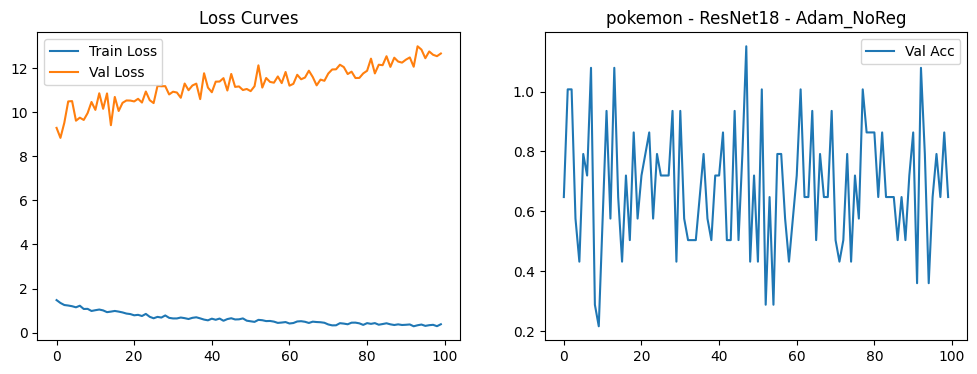


--- Model: ResNet18, Config: Adam_WD ---


  1%|          | 1/150 [00:17<43:13, 17.41s/it]

Epoch   1/150 | Train Loss: 0.4748 | Val Loss: 11.3003 | Val Acc: 0.72%


  1%|▏         | 2/150 [00:34<43:01, 17.44s/it]

Epoch   2/150 | Train Loss: 0.4205 | Val Loss: 11.1144 | Val Acc: 0.50%


  2%|▏         | 3/150 [00:51<42:17, 17.26s/it]

Epoch   3/150 | Train Loss: 0.4302 | Val Loss: 11.4235 | Val Acc: 0.65%


  3%|▎         | 4/150 [01:09<42:27, 17.45s/it]

Epoch   4/150 | Train Loss: 0.4146 | Val Loss: 11.3581 | Val Acc: 0.65%


  3%|▎         | 5/150 [01:26<41:50, 17.31s/it]

Epoch   5/150 | Train Loss: 0.4136 | Val Loss: 11.7635 | Val Acc: 0.43%


  4%|▍         | 6/150 [01:43<41:21, 17.23s/it]

Epoch   6/150 | Train Loss: 0.4181 | Val Loss: 11.3102 | Val Acc: 0.65%


  5%|▍         | 7/150 [02:01<41:27, 17.40s/it]

Epoch   7/150 | Train Loss: 0.4375 | Val Loss: 11.5587 | Val Acc: 0.43%


  5%|▌         | 8/150 [02:18<40:59, 17.32s/it]

Epoch   8/150 | Train Loss: 0.4116 | Val Loss: 11.2764 | Val Acc: 0.94%


  6%|▌         | 9/150 [02:35<40:36, 17.28s/it]

Epoch   9/150 | Train Loss: 0.4098 | Val Loss: 11.3783 | Val Acc: 0.65%


  7%|▋         | 10/150 [02:53<40:34, 17.39s/it]

Epoch  10/150 | Train Loss: 0.3912 | Val Loss: 11.6679 | Val Acc: 0.65%


  7%|▋         | 11/150 [03:10<39:57, 17.25s/it]

Epoch  11/150 | Train Loss: 0.4078 | Val Loss: 11.4037 | Val Acc: 0.65%


  8%|▊         | 12/150 [03:27<39:34, 17.21s/it]

Epoch  12/150 | Train Loss: 0.3939 | Val Loss: 11.4578 | Val Acc: 0.58%


  9%|▊         | 13/150 [03:45<39:33, 17.32s/it]

Epoch  13/150 | Train Loss: 0.3760 | Val Loss: 11.5287 | Val Acc: 0.58%


  9%|▉         | 14/150 [04:02<39:05, 17.24s/it]

Epoch  14/150 | Train Loss: 0.3491 | Val Loss: 11.6512 | Val Acc: 0.65%


 10%|█         | 15/150 [04:19<38:44, 17.21s/it]

Epoch  15/150 | Train Loss: 0.3280 | Val Loss: 11.4493 | Val Acc: 0.86%


 11%|█         | 16/150 [04:36<38:34, 17.27s/it]

Epoch  16/150 | Train Loss: 0.3159 | Val Loss: 11.5395 | Val Acc: 0.79%


 11%|█▏        | 17/150 [04:53<38:14, 17.25s/it]

Epoch  17/150 | Train Loss: 0.3181 | Val Loss: 11.3769 | Val Acc: 0.79%


 12%|█▏        | 18/150 [05:11<38:06, 17.33s/it]

Epoch  18/150 | Train Loss: 0.3116 | Val Loss: 11.5039 | Val Acc: 0.72%


 13%|█▎        | 19/150 [05:28<37:47, 17.31s/it]

Epoch  19/150 | Train Loss: 0.2942 | Val Loss: 11.3250 | Val Acc: 0.79%


 13%|█▎        | 20/150 [05:45<37:22, 17.25s/it]

Epoch  20/150 | Train Loss: 0.2971 | Val Loss: 11.3998 | Val Acc: 0.86%


 14%|█▍        | 21/150 [06:03<37:22, 17.38s/it]

Epoch  21/150 | Train Loss: 0.2799 | Val Loss: 11.5867 | Val Acc: 0.86%


 15%|█▍        | 22/150 [06:20<36:49, 17.26s/it]

Epoch  22/150 | Train Loss: 0.2972 | Val Loss: 11.2560 | Val Acc: 0.72%


 15%|█▌        | 23/150 [06:37<36:25, 17.21s/it]

Epoch  23/150 | Train Loss: 0.2791 | Val Loss: 11.3257 | Val Acc: 0.65%


 16%|█▌        | 24/150 [06:55<36:26, 17.35s/it]

Epoch  24/150 | Train Loss: 0.2988 | Val Loss: 11.4162 | Val Acc: 0.86%


 17%|█▋        | 25/150 [07:12<35:58, 17.27s/it]

Epoch  25/150 | Train Loss: 0.2907 | Val Loss: 11.4712 | Val Acc: 0.65%


 17%|█▋        | 26/150 [07:29<35:29, 17.17s/it]

Epoch  26/150 | Train Loss: 0.2780 | Val Loss: 11.1401 | Val Acc: 0.86%


 18%|█▊        | 27/150 [07:46<35:23, 17.27s/it]

Epoch  27/150 | Train Loss: 0.2953 | Val Loss: 11.4017 | Val Acc: 0.65%


 19%|█▊        | 28/150 [08:03<34:56, 17.19s/it]

Epoch  28/150 | Train Loss: 0.2825 | Val Loss: 11.2528 | Val Acc: 0.72%


 19%|█▉        | 29/150 [08:20<34:33, 17.13s/it]

Epoch  29/150 | Train Loss: 0.2908 | Val Loss: 11.2734 | Val Acc: 0.79%


 20%|██        | 30/150 [08:38<34:26, 17.22s/it]

Epoch  30/150 | Train Loss: 0.2853 | Val Loss: 11.2575 | Val Acc: 0.79%


 21%|██        | 31/150 [08:55<34:01, 17.16s/it]

Epoch  31/150 | Train Loss: 0.2673 | Val Loss: 11.4150 | Val Acc: 0.72%


 21%|██▏       | 32/150 [09:12<33:36, 17.09s/it]

Epoch  32/150 | Train Loss: 0.3029 | Val Loss: 11.3275 | Val Acc: 0.72%


 22%|██▏       | 33/150 [09:29<33:36, 17.24s/it]

Epoch  33/150 | Train Loss: 0.2718 | Val Loss: 11.3783 | Val Acc: 0.72%


 23%|██▎       | 34/150 [09:46<33:06, 17.13s/it]

Epoch  34/150 | Train Loss: 0.2997 | Val Loss: 11.4504 | Val Acc: 0.65%


 23%|██▎       | 35/150 [10:03<32:42, 17.06s/it]

Epoch  35/150 | Train Loss: 0.2946 | Val Loss: 11.3183 | Val Acc: 0.72%


 24%|██▍       | 36/150 [10:21<32:41, 17.21s/it]

Epoch  36/150 | Train Loss: 0.2718 | Val Loss: 11.2747 | Val Acc: 0.72%


 25%|██▍       | 37/150 [10:38<32:21, 17.18s/it]

Epoch  37/150 | Train Loss: 0.2867 | Val Loss: 11.6720 | Val Acc: 0.65%


 25%|██▌       | 38/150 [10:55<32:03, 17.17s/it]

Epoch  38/150 | Train Loss: 0.2810 | Val Loss: 11.1973 | Val Acc: 0.72%


 26%|██▌       | 39/150 [11:12<31:51, 17.22s/it]

Epoch  39/150 | Train Loss: 0.2901 | Val Loss: 11.2720 | Val Acc: 0.72%


 27%|██▋       | 40/150 [11:29<31:22, 17.12s/it]

Epoch  40/150 | Train Loss: 0.2832 | Val Loss: 11.3154 | Val Acc: 0.79%


 27%|██▋       | 41/150 [11:47<31:26, 17.30s/it]

Epoch  41/150 | Train Loss: 0.2743 | Val Loss: 11.3902 | Val Acc: 0.72%


 28%|██▊       | 42/150 [12:04<31:03, 17.25s/it]

Epoch  42/150 | Train Loss: 0.2762 | Val Loss: 11.2046 | Val Acc: 0.58%


 29%|██▊       | 43/150 [12:21<30:35, 17.15s/it]

Epoch  43/150 | Train Loss: 0.2809 | Val Loss: 11.4037 | Val Acc: 0.65%


 29%|██▉       | 44/150 [12:39<30:40, 17.36s/it]

Epoch  44/150 | Train Loss: 0.2651 | Val Loss: 11.2598 | Val Acc: 0.79%


 30%|███       | 45/150 [12:56<30:19, 17.33s/it]

Epoch  45/150 | Train Loss: 0.2708 | Val Loss: 11.4198 | Val Acc: 0.72%


 31%|███       | 46/150 [13:13<29:54, 17.25s/it]

Epoch  46/150 | Train Loss: 0.2604 | Val Loss: 11.3357 | Val Acc: 0.65%


 31%|███▏      | 47/150 [13:31<29:48, 17.36s/it]

Epoch  47/150 | Train Loss: 0.2756 | Val Loss: 11.3114 | Val Acc: 0.79%


 32%|███▏      | 48/150 [13:48<29:20, 17.26s/it]

Epoch  48/150 | Train Loss: 0.2889 | Val Loss: 11.5002 | Val Acc: 0.65%


 33%|███▎      | 49/150 [14:05<28:55, 17.18s/it]

Epoch  49/150 | Train Loss: 0.2706 | Val Loss: 11.3932 | Val Acc: 0.86%


 33%|███▎      | 50/150 [14:22<28:42, 17.23s/it]

Epoch  50/150 | Train Loss: 0.2889 | Val Loss: 11.2619 | Val Acc: 0.72%


 34%|███▍      | 51/150 [14:39<28:21, 17.18s/it]

Epoch  51/150 | Train Loss: 0.3009 | Val Loss: 11.2096 | Val Acc: 0.79%


 35%|███▍      | 52/150 [14:56<27:58, 17.12s/it]

Epoch  52/150 | Train Loss: 0.2689 | Val Loss: 11.3355 | Val Acc: 0.65%


 35%|███▌      | 53/150 [15:14<27:51, 17.23s/it]

Epoch  53/150 | Train Loss: 0.2915 | Val Loss: 11.3987 | Val Acc: 0.72%


 36%|███▌      | 54/150 [15:31<27:30, 17.19s/it]

Epoch  54/150 | Train Loss: 0.2897 | Val Loss: 11.4619 | Val Acc: 0.65%


 37%|███▋      | 55/150 [15:48<27:04, 17.10s/it]

Epoch  55/150 | Train Loss: 0.2927 | Val Loss: 11.3468 | Val Acc: 0.65%


 37%|███▋      | 56/150 [16:05<26:56, 17.20s/it]

Epoch  56/150 | Train Loss: 0.2914 | Val Loss: 11.2988 | Val Acc: 0.79%


 38%|███▊      | 57/150 [16:22<26:34, 17.15s/it]

Epoch  57/150 | Train Loss: 0.3035 | Val Loss: 11.3703 | Val Acc: 0.79%


 39%|███▊      | 58/150 [16:40<26:32, 17.31s/it]

Epoch  58/150 | Train Loss: 0.2867 | Val Loss: 11.4896 | Val Acc: 0.58%


 39%|███▉      | 59/150 [16:57<26:11, 17.27s/it]

Epoch  59/150 | Train Loss: 0.2813 | Val Loss: 11.5037 | Val Acc: 0.65%


 40%|████      | 60/150 [17:14<25:53, 17.26s/it]

Epoch  60/150 | Train Loss: 0.2997 | Val Loss: 11.2783 | Val Acc: 0.65%


 41%|████      | 61/150 [17:32<25:46, 17.38s/it]

Epoch  61/150 | Train Loss: 0.2913 | Val Loss: 11.3224 | Val Acc: 0.58%


 41%|████▏     | 62/150 [17:49<25:18, 17.26s/it]

Epoch  62/150 | Train Loss: 0.2897 | Val Loss: 11.3875 | Val Acc: 0.86%


 42%|████▏     | 63/150 [18:06<24:55, 17.19s/it]

Epoch  63/150 | Train Loss: 0.2911 | Val Loss: 11.3242 | Val Acc: 0.79%


 43%|████▎     | 64/150 [18:23<24:49, 17.32s/it]

Epoch  64/150 | Train Loss: 0.2888 | Val Loss: 11.4387 | Val Acc: 0.65%


 43%|████▎     | 65/150 [18:40<24:24, 17.23s/it]

Epoch  65/150 | Train Loss: 0.2984 | Val Loss: 11.3349 | Val Acc: 0.79%


 44%|████▍     | 66/150 [18:58<24:05, 17.20s/it]

Epoch  66/150 | Train Loss: 0.2734 | Val Loss: 11.0753 | Val Acc: 0.94%


 45%|████▍     | 67/150 [19:15<23:54, 17.28s/it]

Epoch  67/150 | Train Loss: 0.2831 | Val Loss: 11.3349 | Val Acc: 0.58%


 45%|████▌     | 68/150 [19:32<23:28, 17.18s/it]

Epoch  68/150 | Train Loss: 0.2772 | Val Loss: 11.1390 | Val Acc: 0.72%


 46%|████▌     | 69/150 [19:49<23:04, 17.09s/it]

Epoch  69/150 | Train Loss: 0.2833 | Val Loss: 11.4688 | Val Acc: 0.72%


 47%|████▋     | 70/150 [20:06<22:55, 17.19s/it]

Epoch  70/150 | Train Loss: 0.2827 | Val Loss: 11.2608 | Val Acc: 0.65%


 47%|████▋     | 71/150 [20:23<22:32, 17.12s/it]

Epoch  71/150 | Train Loss: 0.2907 | Val Loss: 11.2981 | Val Acc: 0.72%


 48%|████▊     | 72/150 [20:40<22:08, 17.03s/it]

Epoch  72/150 | Train Loss: 0.3079 | Val Loss: 11.3586 | Val Acc: 0.72%


 49%|████▊     | 73/150 [20:57<21:56, 17.10s/it]

Epoch  73/150 | Train Loss: 0.2872 | Val Loss: 11.5117 | Val Acc: 0.72%


 49%|████▉     | 74/150 [21:14<21:37, 17.07s/it]

Epoch  74/150 | Train Loss: 0.2699 | Val Loss: 11.2261 | Val Acc: 0.72%


 50%|█████     | 75/150 [21:31<21:17, 17.04s/it]

Epoch  75/150 | Train Loss: 0.2683 | Val Loss: 11.4736 | Val Acc: 0.65%


 51%|█████     | 76/150 [21:49<21:11, 17.18s/it]

Epoch  76/150 | Train Loss: 0.2924 | Val Loss: 11.3986 | Val Acc: 0.72%


 51%|█████▏    | 77/150 [22:06<20:52, 17.16s/it]

Epoch  77/150 | Train Loss: 0.2812 | Val Loss: 11.2755 | Val Acc: 0.72%


 52%|█████▏    | 78/150 [22:24<20:48, 17.34s/it]

Epoch  78/150 | Train Loss: 0.2975 | Val Loss: 11.4686 | Val Acc: 0.65%


 53%|█████▎    | 79/150 [22:41<20:23, 17.23s/it]

Epoch  79/150 | Train Loss: 0.2826 | Val Loss: 11.2809 | Val Acc: 0.86%


 53%|█████▎    | 80/150 [22:58<20:02, 17.18s/it]

Epoch  80/150 | Train Loss: 0.2736 | Val Loss: 11.4290 | Val Acc: 0.79%


 54%|█████▍    | 81/150 [23:15<19:58, 17.36s/it]

Epoch  81/150 | Train Loss: 0.2939 | Val Loss: 11.6412 | Val Acc: 0.50%


 55%|█████▍    | 82/150 [23:33<19:34, 17.27s/it]

Epoch  82/150 | Train Loss: 0.2775 | Val Loss: 11.3712 | Val Acc: 0.58%


 55%|█████▌    | 83/150 [23:50<19:12, 17.21s/it]

Epoch  83/150 | Train Loss: 0.2884 | Val Loss: 11.3636 | Val Acc: 0.72%


 56%|█████▌    | 84/150 [24:07<18:57, 17.23s/it]

Epoch  84/150 | Train Loss: 0.2856 | Val Loss: 11.4443 | Val Acc: 0.79%


 57%|█████▋    | 85/150 [24:24<18:37, 17.20s/it]

Epoch  85/150 | Train Loss: 0.2762 | Val Loss: 11.2978 | Val Acc: 0.86%


 57%|█████▋    | 86/150 [24:41<18:14, 17.10s/it]

Epoch  86/150 | Train Loss: 0.2741 | Val Loss: 11.2989 | Val Acc: 0.72%


 58%|█████▊    | 87/150 [24:58<18:02, 17.18s/it]

Epoch  87/150 | Train Loss: 0.2742 | Val Loss: 11.1059 | Val Acc: 0.79%


 59%|█████▊    | 88/150 [25:15<17:40, 17.11s/it]

Epoch  88/150 | Train Loss: 0.2966 | Val Loss: 11.4372 | Val Acc: 0.72%


 59%|█████▉    | 89/150 [25:32<17:21, 17.08s/it]

Epoch  89/150 | Train Loss: 0.2633 | Val Loss: 11.3884 | Val Acc: 0.94%


 60%|██████    | 90/150 [25:50<17:09, 17.16s/it]

Epoch  90/150 | Train Loss: 0.2902 | Val Loss: 11.2154 | Val Acc: 0.72%


 61%|██████    | 91/150 [26:07<16:50, 17.12s/it]

Epoch  91/150 | Train Loss: 0.2722 | Val Loss: 11.3692 | Val Acc: 0.65%


 61%|██████▏   | 92/150 [26:24<16:31, 17.10s/it]

Epoch  92/150 | Train Loss: 0.2683 | Val Loss: 11.3896 | Val Acc: 0.65%


 62%|██████▏   | 93/150 [26:41<16:21, 17.22s/it]

Epoch  93/150 | Train Loss: 0.2766 | Val Loss: 11.3715 | Val Acc: 0.72%


 63%|██████▎   | 94/150 [26:58<16:01, 17.16s/it]

Epoch  94/150 | Train Loss: 0.3067 | Val Loss: 11.2916 | Val Acc: 0.72%


 63%|██████▎   | 95/150 [27:15<15:45, 17.20s/it]

Epoch  95/150 | Train Loss: 0.2927 | Val Loss: 11.2782 | Val Acc: 0.72%


 64%|██████▍   | 96/150 [27:33<15:34, 17.31s/it]

Epoch  96/150 | Train Loss: 0.2661 | Val Loss: 11.3467 | Val Acc: 0.65%


 65%|██████▍   | 97/150 [27:50<15:12, 17.22s/it]

Epoch  97/150 | Train Loss: 0.3013 | Val Loss: 11.2930 | Val Acc: 0.65%


 65%|██████▌   | 98/150 [28:08<15:02, 17.35s/it]

Epoch  98/150 | Train Loss: 0.2933 | Val Loss: 11.5162 | Val Acc: 0.58%


 66%|██████▌   | 99/150 [28:24<14:36, 17.19s/it]

Epoch  99/150 | Train Loss: 0.2981 | Val Loss: 11.3255 | Val Acc: 0.79%


 67%|██████▋   | 100/150 [28:42<14:19, 17.19s/it]

Epoch 100/150 | Train Loss: 0.3103 | Val Loss: 11.3852 | Val Acc: 0.65%


 67%|██████▋   | 101/150 [28:59<14:10, 17.36s/it]

Epoch 101/150 | Train Loss: 0.2807 | Val Loss: 11.2581 | Val Acc: 0.65%


 68%|██████▊   | 102/150 [29:16<13:49, 17.27s/it]

Epoch 102/150 | Train Loss: 0.2901 | Val Loss: 11.3322 | Val Acc: 0.72%


 69%|██████▊   | 103/150 [29:34<13:29, 17.21s/it]

Epoch 103/150 | Train Loss: 0.2844 | Val Loss: 11.1836 | Val Acc: 0.79%


 69%|██████▉   | 104/150 [29:51<13:15, 17.30s/it]

Epoch 104/150 | Train Loss: 0.2855 | Val Loss: 11.3649 | Val Acc: 0.72%


 70%|███████   | 105/150 [30:08<12:52, 17.16s/it]

Epoch 105/150 | Train Loss: 0.2548 | Val Loss: 11.4894 | Val Acc: 0.65%


 71%|███████   | 106/150 [30:25<12:29, 17.04s/it]

Epoch 106/150 | Train Loss: 0.2919 | Val Loss: 11.4264 | Val Acc: 0.72%


 71%|███████▏  | 107/150 [30:42<12:18, 17.19s/it]

Epoch 107/150 | Train Loss: 0.2773 | Val Loss: 11.3858 | Val Acc: 0.65%


 72%|███████▏  | 108/150 [30:59<11:56, 17.07s/it]

Epoch 108/150 | Train Loss: 0.3020 | Val Loss: 11.4791 | Val Acc: 0.65%


 73%|███████▎  | 109/150 [31:16<11:38, 17.04s/it]

Epoch 109/150 | Train Loss: 0.2603 | Val Loss: 11.3922 | Val Acc: 0.72%


 73%|███████▎  | 110/150 [31:33<11:25, 17.15s/it]

Epoch 110/150 | Train Loss: 0.2761 | Val Loss: 11.2539 | Val Acc: 0.65%


 74%|███████▍  | 111/150 [31:50<11:06, 17.10s/it]

Epoch 111/150 | Train Loss: 0.2922 | Val Loss: 11.3216 | Val Acc: 0.65%


 75%|███████▍  | 112/150 [32:07<10:47, 17.05s/it]

Epoch 112/150 | Train Loss: 0.2821 | Val Loss: 11.2164 | Val Acc: 0.79%


 75%|███████▌  | 113/150 [32:25<10:35, 17.18s/it]

Epoch 113/150 | Train Loss: 0.2839 | Val Loss: 11.1917 | Val Acc: 0.79%


 76%|███████▌  | 114/150 [32:42<10:15, 17.09s/it]

Epoch 114/150 | Train Loss: 0.2948 | Val Loss: 11.4083 | Val Acc: 0.72%


 77%|███████▋  | 115/150 [32:59<09:58, 17.10s/it]

Epoch 115/150 | Train Loss: 0.2911 | Val Loss: 11.1057 | Val Acc: 0.79%


 77%|███████▋  | 116/150 [33:16<09:45, 17.21s/it]

Epoch 116/150 | Train Loss: 0.2803 | Val Loss: 11.4071 | Val Acc: 0.65%


 78%|███████▊  | 117/150 [33:33<09:25, 17.15s/it]

Epoch 117/150 | Train Loss: 0.2828 | Val Loss: 11.3239 | Val Acc: 0.79%


 79%|███████▊  | 118/150 [33:51<09:10, 17.21s/it]

Epoch 118/150 | Train Loss: 0.2821 | Val Loss: 11.2320 | Val Acc: 0.79%


 79%|███████▉  | 119/150 [34:08<08:55, 17.26s/it]

Epoch 119/150 | Train Loss: 0.2748 | Val Loss: 11.4949 | Val Acc: 0.65%


 80%|████████  | 120/150 [34:25<08:35, 17.19s/it]

Epoch 120/150 | Train Loss: 0.2871 | Val Loss: 11.2388 | Val Acc: 0.72%


 81%|████████  | 121/150 [34:43<08:24, 17.41s/it]

Epoch 121/150 | Train Loss: 0.2878 | Val Loss: 11.3125 | Val Acc: 0.79%


 81%|████████▏ | 122/150 [35:00<08:04, 17.31s/it]

Epoch 122/150 | Train Loss: 0.2773 | Val Loss: 11.3406 | Val Acc: 0.72%


 82%|████████▏ | 123/150 [35:17<07:45, 17.25s/it]

Epoch 123/150 | Train Loss: 0.2790 | Val Loss: 11.5514 | Val Acc: 0.72%


 83%|████████▎ | 124/150 [35:35<07:31, 17.35s/it]

Epoch 124/150 | Train Loss: 0.2944 | Val Loss: 11.2033 | Val Acc: 0.79%


 83%|████████▎ | 125/150 [35:52<07:10, 17.21s/it]

Epoch 125/150 | Train Loss: 0.2797 | Val Loss: 11.3912 | Val Acc: 0.72%


 84%|████████▍ | 126/150 [36:09<06:52, 17.18s/it]

Epoch 126/150 | Train Loss: 0.2669 | Val Loss: 11.3154 | Val Acc: 0.65%


 85%|████████▍ | 127/150 [36:26<06:35, 17.20s/it]

Epoch 127/150 | Train Loss: 0.2835 | Val Loss: 11.2176 | Val Acc: 0.79%


 85%|████████▌ | 128/150 [36:43<06:17, 17.15s/it]

Epoch 128/150 | Train Loss: 0.2828 | Val Loss: 11.2589 | Val Acc: 0.79%


 86%|████████▌ | 129/150 [37:00<05:59, 17.10s/it]

Epoch 129/150 | Train Loss: 0.2985 | Val Loss: 11.2415 | Val Acc: 0.79%


 87%|████████▋ | 130/150 [37:17<05:44, 17.22s/it]

Epoch 130/150 | Train Loss: 0.2890 | Val Loss: 11.4345 | Val Acc: 0.65%


 87%|████████▋ | 131/150 [37:34<05:26, 17.16s/it]

Epoch 131/150 | Train Loss: 0.2863 | Val Loss: 11.3916 | Val Acc: 0.79%


 88%|████████▊ | 132/150 [37:52<05:11, 17.32s/it]

Epoch 132/150 | Train Loss: 0.2728 | Val Loss: 11.4495 | Val Acc: 0.58%


 89%|████████▊ | 133/150 [38:09<04:52, 17.19s/it]

Epoch 133/150 | Train Loss: 0.2775 | Val Loss: 11.3767 | Val Acc: 0.79%


 89%|████████▉ | 134/150 [38:26<04:34, 17.14s/it]

Epoch 134/150 | Train Loss: 0.2951 | Val Loss: 11.2678 | Val Acc: 0.72%


 90%|█████████ | 135/150 [38:44<04:20, 17.38s/it]

Epoch 135/150 | Train Loss: 0.3007 | Val Loss: 11.2646 | Val Acc: 0.72%


 91%|█████████ | 136/150 [39:01<04:02, 17.33s/it]

Epoch 136/150 | Train Loss: 0.2829 | Val Loss: 11.3198 | Val Acc: 0.65%


 91%|█████████▏| 137/150 [39:18<03:43, 17.22s/it]

Epoch 137/150 | Train Loss: 0.2766 | Val Loss: 11.4334 | Val Acc: 0.65%


 92%|█████████▏| 138/150 [39:36<03:28, 17.33s/it]

Epoch 138/150 | Train Loss: 0.2783 | Val Loss: 11.4248 | Val Acc: 0.72%


 93%|█████████▎| 139/150 [39:53<03:09, 17.27s/it]

Epoch 139/150 | Train Loss: 0.2773 | Val Loss: 11.2960 | Val Acc: 0.65%


 93%|█████████▎| 140/150 [40:10<02:52, 17.20s/it]

Epoch 140/150 | Train Loss: 0.2818 | Val Loss: 11.4156 | Val Acc: 0.72%


 94%|█████████▍| 141/150 [40:27<02:35, 17.29s/it]

Epoch 141/150 | Train Loss: 0.2852 | Val Loss: 11.3233 | Val Acc: 0.72%


 95%|█████████▍| 142/150 [40:45<02:17, 17.23s/it]

Epoch 142/150 | Train Loss: 0.2921 | Val Loss: 11.2420 | Val Acc: 0.65%


 95%|█████████▌| 143/150 [41:02<02:00, 17.21s/it]

Epoch 143/150 | Train Loss: 0.2623 | Val Loss: 11.2476 | Val Acc: 0.72%


 96%|█████████▌| 144/150 [41:19<01:43, 17.30s/it]

Epoch 144/150 | Train Loss: 0.2905 | Val Loss: 11.3352 | Val Acc: 0.65%


 97%|█████████▋| 145/150 [41:36<01:25, 17.19s/it]

Epoch 145/150 | Train Loss: 0.2747 | Val Loss: 11.2838 | Val Acc: 0.65%


 97%|█████████▋| 146/150 [41:53<01:08, 17.16s/it]

Epoch 146/150 | Train Loss: 0.2647 | Val Loss: 11.4054 | Val Acc: 0.65%


 98%|█████████▊| 147/150 [42:11<00:51, 17.22s/it]

Epoch 147/150 | Train Loss: 0.2832 | Val Loss: 11.4815 | Val Acc: 0.72%


 99%|█████████▊| 148/150 [42:28<00:34, 17.17s/it]

Epoch 148/150 | Train Loss: 0.2788 | Val Loss: 11.2522 | Val Acc: 0.65%


 99%|█████████▉| 149/150 [42:45<00:17, 17.37s/it]

Epoch 149/150 | Train Loss: 0.2850 | Val Loss: 11.3586 | Val Acc: 0.65%


100%|██████████| 150/150 [43:03<00:00, 17.22s/it]

Epoch 150/150 | Train Loss: 0.2888 | Val Loss: 11.4538 | Val Acc: 0.72%


FINAL TEST ACCURACY: 2.46%



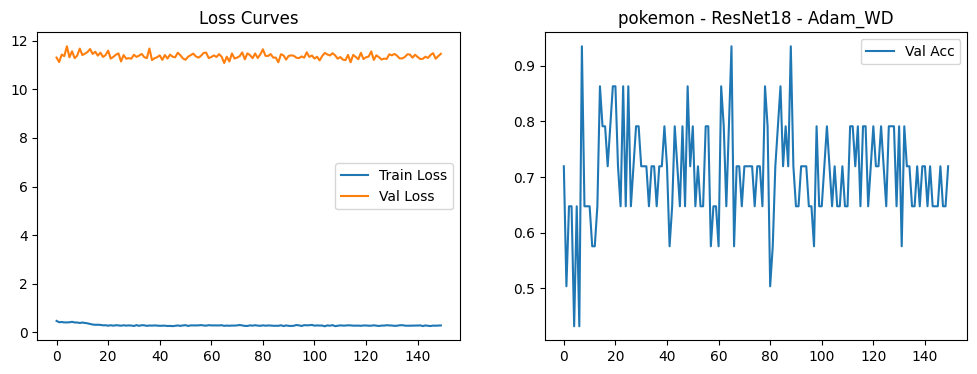

Model training and evaluation complete for all configurations.


In [42]:
num_classes = len(class_names)
results = []
criterion = nn.CrossEntropyLoss()

for model_name in models_to_test:
    print(f"\n----- Training {model_name} -----")
    if model_name == "SimpleCNN":
        model = SimpleCNN(num_classes=num_classes).to(device)
    elif model_name == "VGG11":
        model = VGG11(num_classes=num_classes).to(device)
    elif model_name == "ResNet18":
        model = ResNet18(num_classes=num_classes).to(device)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    for hp in hyperparam_configs:
        print(f"\n--- Model: {model_name}, Config: {hp['name']} ---")

        # Setup Optimizer
        if hp["optimizer"] == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=hp["lr"], momentum=hp["momentum"], weight_decay=hp["weight_decay"])
        elif hp["optimizer"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])
        else:
            raise ValueError(f"Unknown optimizer: {hp['optimizer']}")

        # Setup Scheduler
        scheduler = None
        if hp["scheduler_type"] == "Step":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=hp["epochs"] // 3, gamma=0.1)
        elif hp["scheduler_type"] == "Cosine":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hp["epochs"])
        elif hp["scheduler_type"] == "Reduce":
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

        # Train the model
        history, test_acc = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion,
                                      epochs=hp["epochs"], scheduler=scheduler, scheduler_type=hp["scheduler_type"])

        results.append({'model': model_name, 'config': hp['name'], 'history': history, 'test_acc': test_acc})

print("Model training and evaluation complete for all configurations.")
